# Anomaly Detection 

In [1]:
# Perform Imports 

# please comment the rows below if you don't have the packages
%load_ext jupyternotify
from jupyterthemes import jtplot
jtplot.style()

import sqlite3
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from sklearn import linear_model

DB_FILENAME = '../taxi_trips.db'

<IPython.core.display.Javascript object>

In [2]:
def query_to_df(query):
    with sqlite3.connect(DB_FILENAME) as con:
        cur = con.cursor()
        cur.execute(query)
        if cur.description is None: 
            return
        col_names = []
        row_values = []
        for col_name in cur.description:
            col_names.append(col_name[0])
        for row in cur.fetchall():
            row_values.append(list(row))
            
        return pd.DataFrame(row_values, columns=col_names)

# 1. Iterative gaussian elimination

## 1.1 Prepare data

Collect the following from the database we prepared in previons sessions:

  1. Number of trips by trip duration (in multiplies of 15 seconds)
  1. Number of trips by taxi 
  1. Number of trips per day 
  1. Number of unique taxis working each day
  1. Difference series of 3
  1. Difference series of 4
  1. Ratios series of 3
  1. Ratios series of 4
  
A diffrence series is the change between two consecutive values $ y_i = x_i - x_{i-1} $

A ratios series is the division of two consecutive values $ y_i = x_i / x_{i-1} $

### 1.1.1 Print the first 10 values of 1 and 2 

In [3]:
#  Number of trips by trip duration
query = """SELECT nGPSSamples*15 as LengthInSeconds, count(TRIP_ID) trips_by_length from trips group by nGPSSamples"""
df_trips_duration = query_to_df(query)
df_trips_duration = df_trips_duration.set_index('LengthInSeconds')
df_trips_duration.head(10)

trips_by_length
LengthInSeconds                 
135                         4353
150                         5093
165                         6521
180                         7747
195                         9831
210                        11374
225                        13381
240                        15005
255                        17207
270                        19098

In [4]:
# Number of trips by taxi
query = """SELECT TAXI_ID, count(TRIP_ID) trips_by_taxi_id from trips group by TAXI_ID"""
df_trips_taxis = query_to_df(query)
df_trips_taxis = df_trips_taxis.set_index('TAXI_ID')
df_trips_taxis.head(10)

trips_by_taxi_id
TAXI_ID                   
20000001              2710
20000002              3675
20000003              1835
20000004              4873
20000005              6007
20000006              3323
20000007              5508
20000008              4690
20000009              4641
20000010              5755

### 1.1.2 Plot 3-8 as a function of time
 

In [5]:
"""
Number of trips per day 
Number of unique taxis working each day
Difference series of 3
Difference series of 4
Ratios series of 3
Ratios series of 4"""

SQL = """
    SELECT date(localdatetime) as date, 
        count(*) n_rides, 
        count(DISTINCT TAXI_ID) n_taxis
    FROM trips 
    GROUP BY date(localdatetime)"""
df_rides = query_to_df(SQL)
df_rides = df_rides.set_index('date')
df_rides.index = df_rides.index.astype('datetime64[ns]')
df_rides['diff_trips'] = df_rides['n_rides'] - df_rides['n_rides'].shift(1)
df_rides['diff_taxis'] = df_rides['n_taxis'] - df_rides['n_taxis'].shift(1)
df_rides['ratio_trips'] = df_rides['n_rides'] / df_rides['n_rides'].shift(1)
df_rides['ratio_taxis'] = df_rides['n_taxis'] / df_rides['n_taxis'].shift(1)
df_rides = df_rides[df_rides.index < '2014-07-01']
df_rides.head()

n_rides  n_taxis  diff_trips  diff_taxis  ratio_trips  ratio_taxis
date                                                                          
2013-07-01     4472      393         NaN         NaN          NaN          NaN
2013-07-02     4487      401        15.0         8.0     1.003354     1.020356
2013-07-03     4539      404        52.0         3.0     1.011589     1.007481
2013-07-04     5011      406       472.0         2.0     1.103988     1.004950
2013-07-05     5431      409       420.0         3.0     1.083816     1.007389

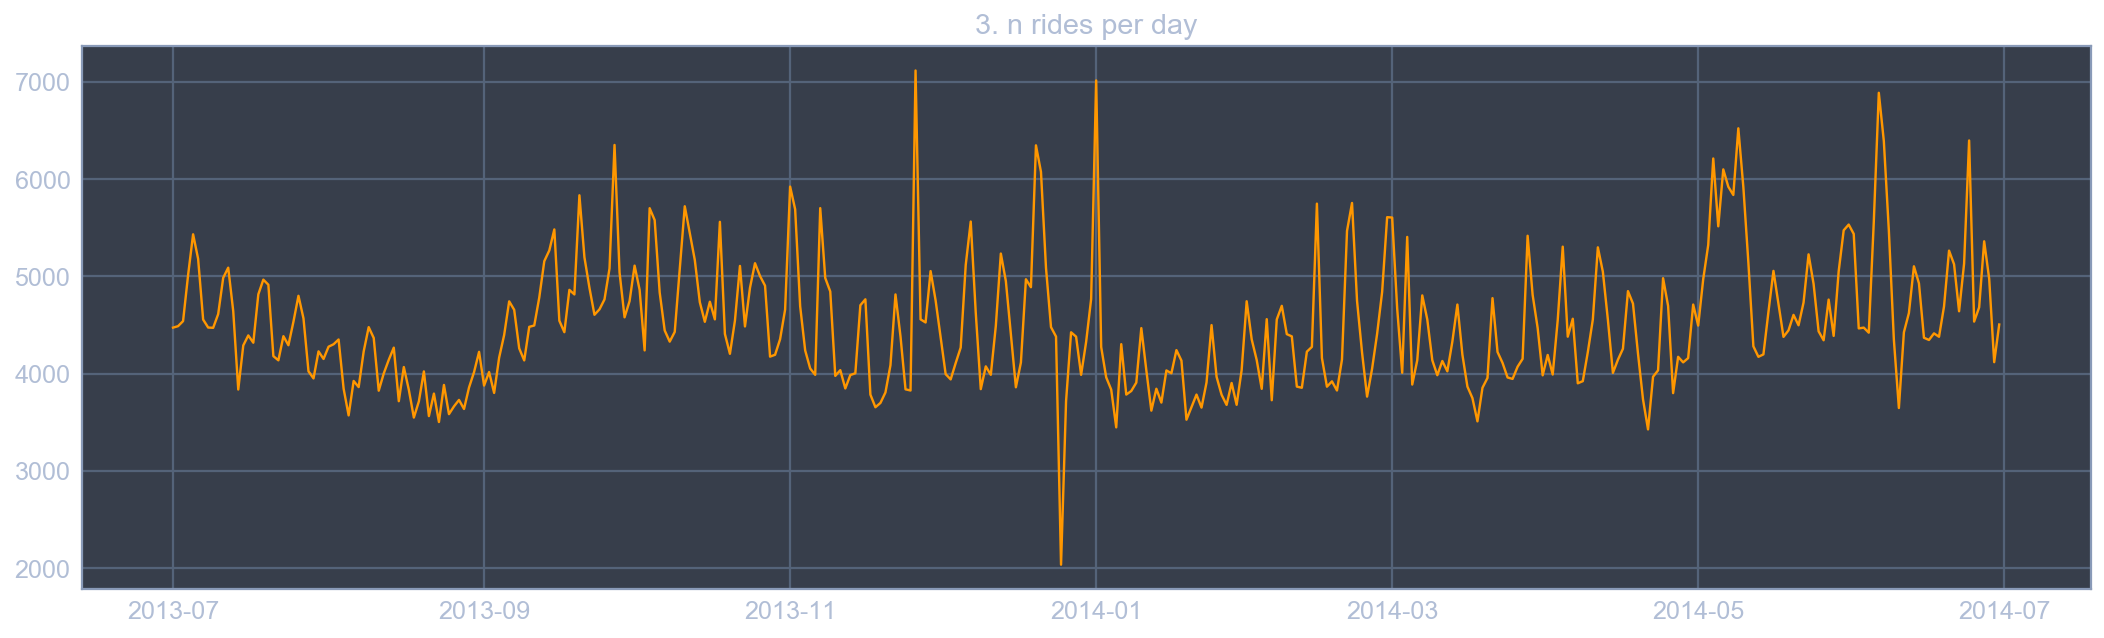

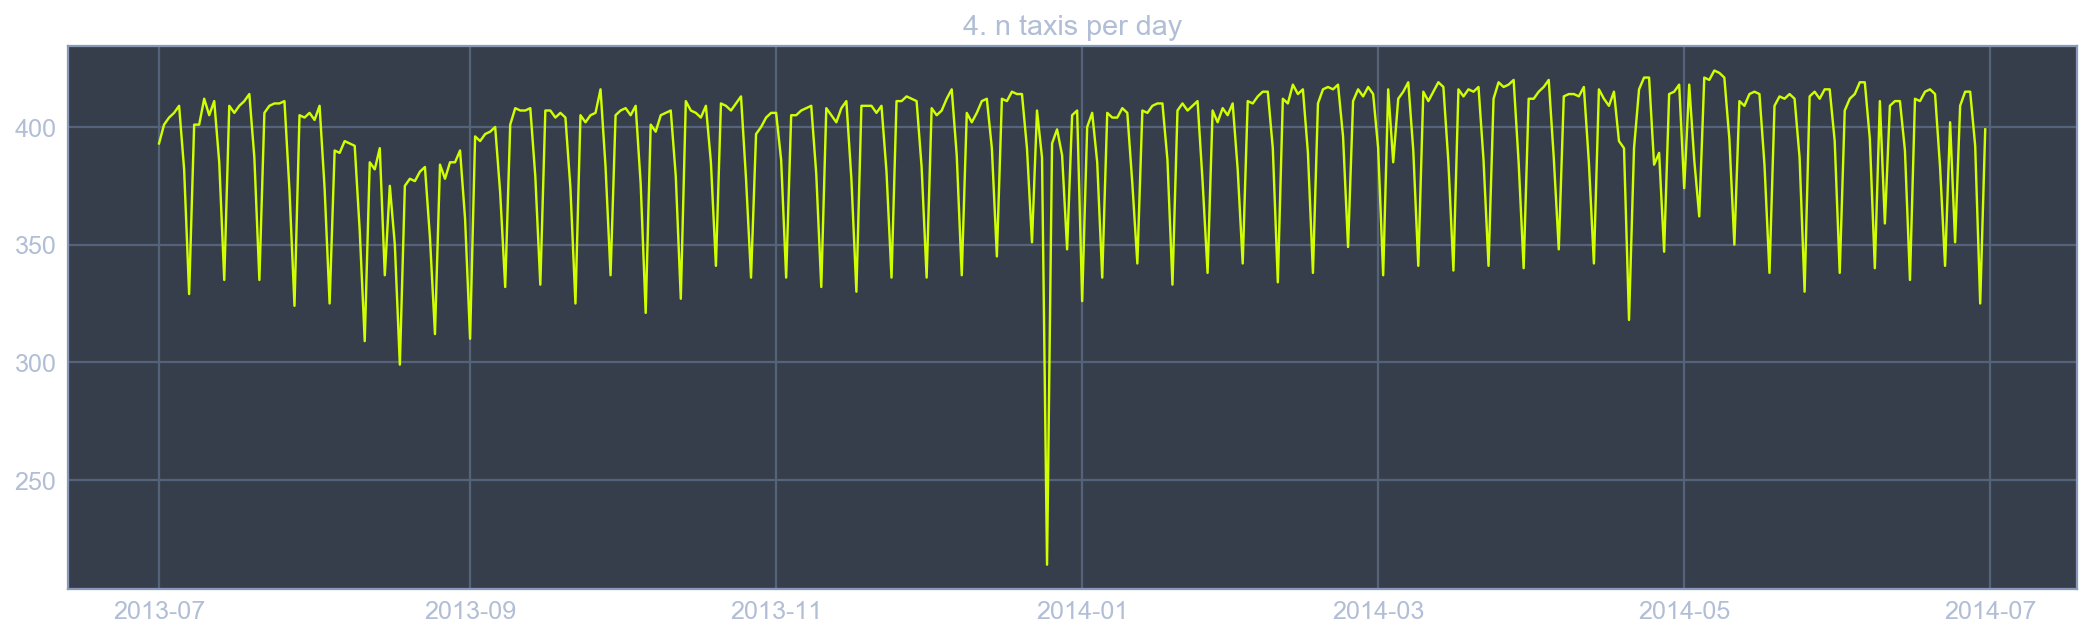

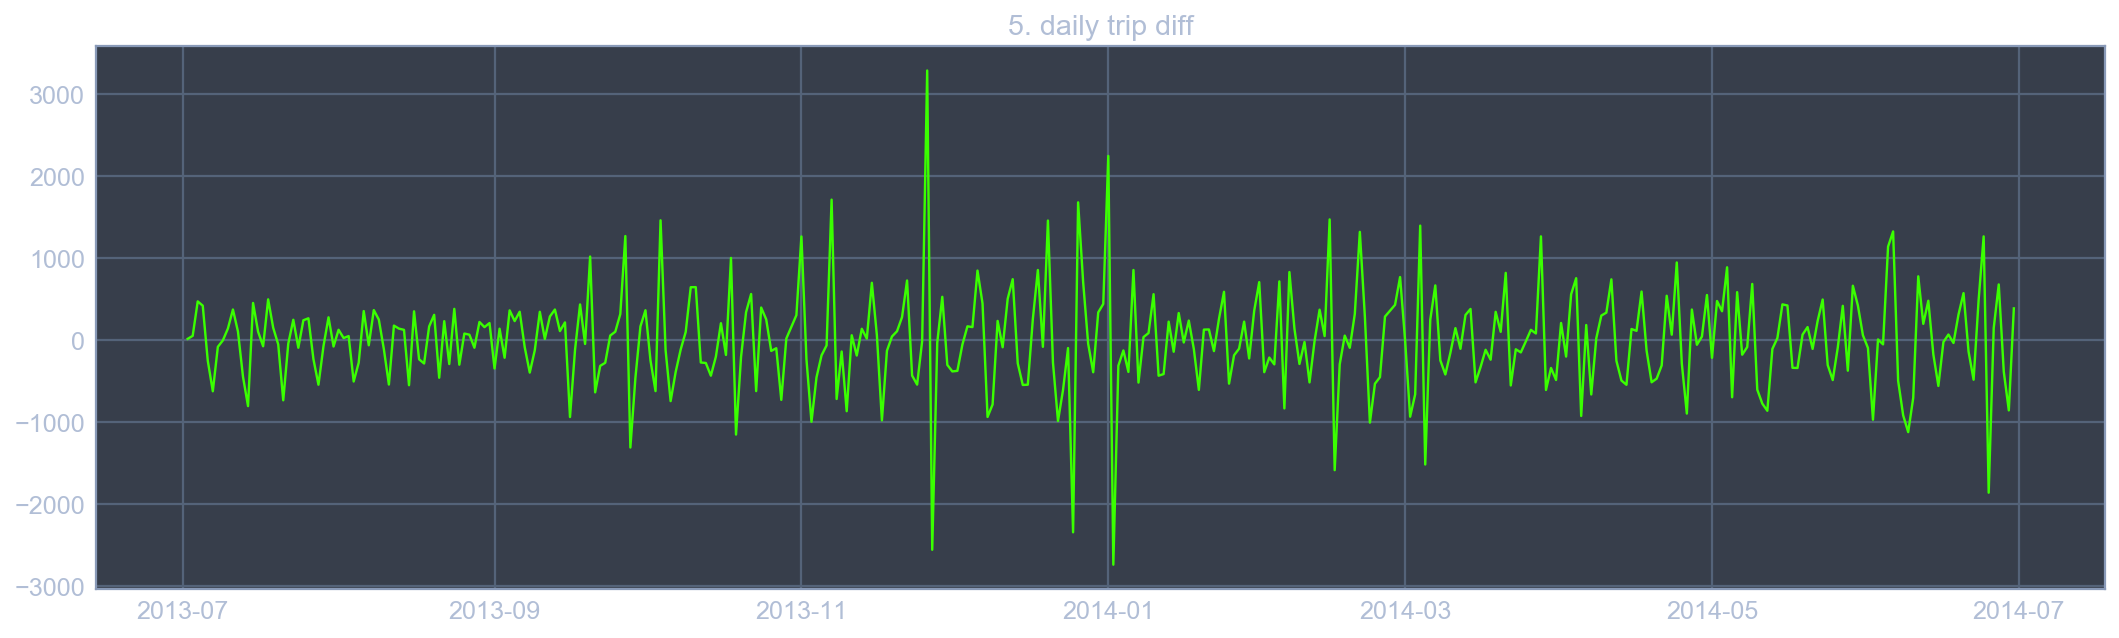

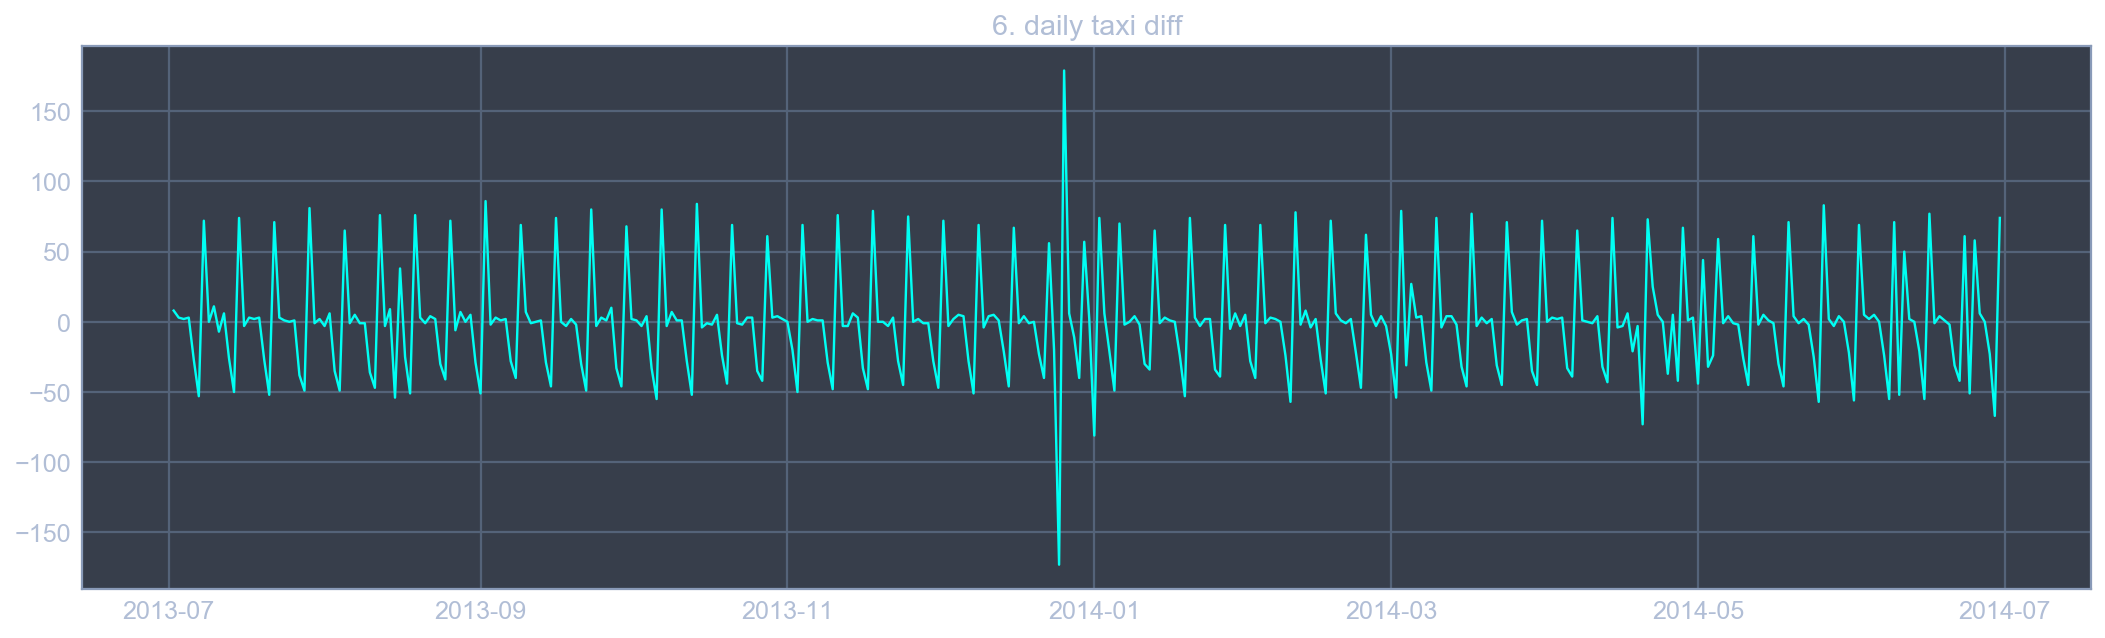

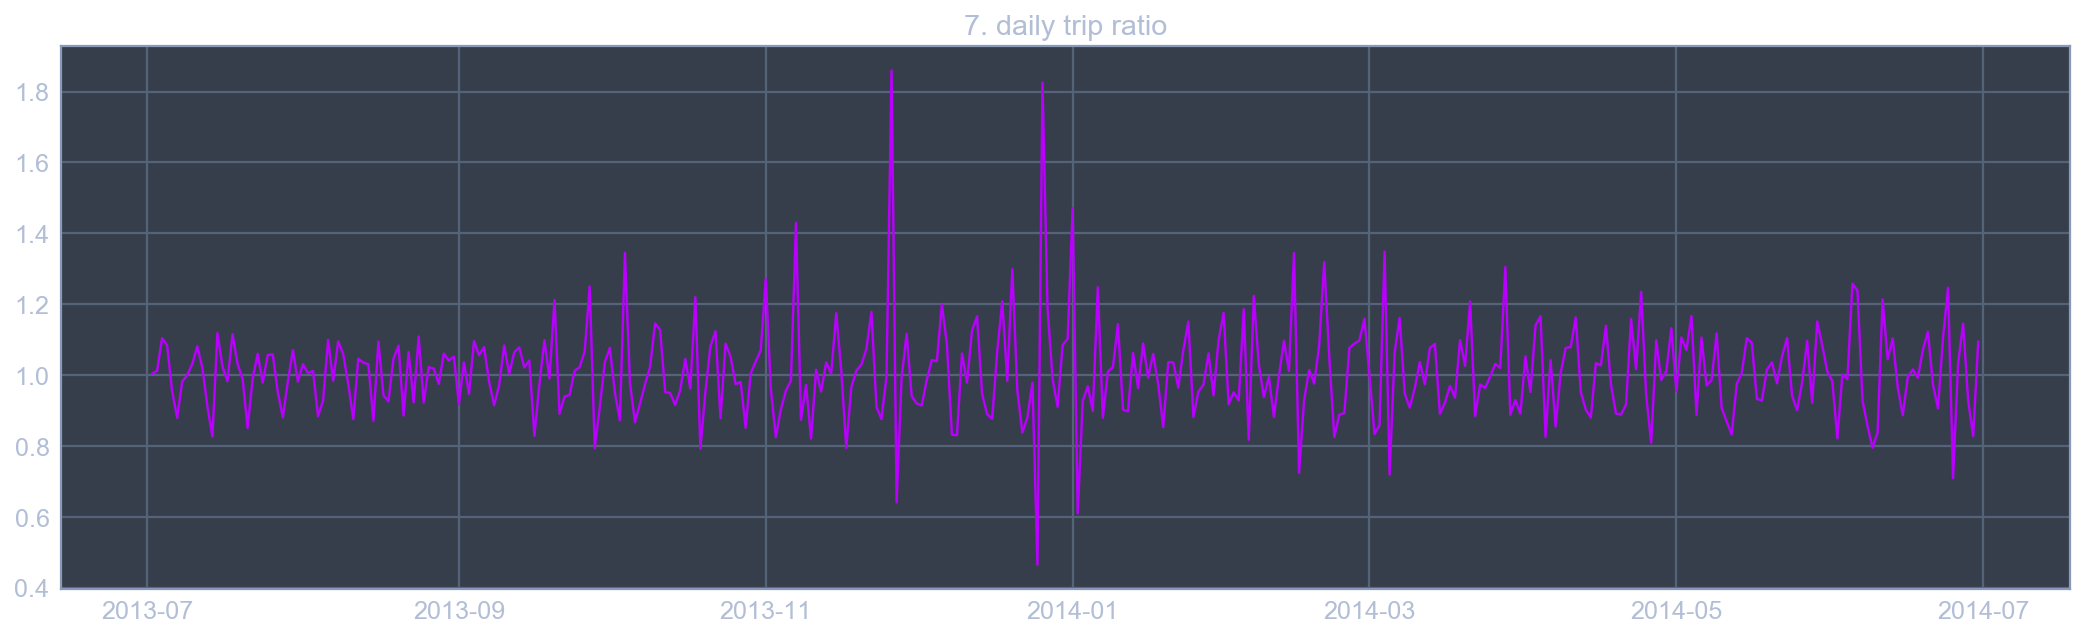

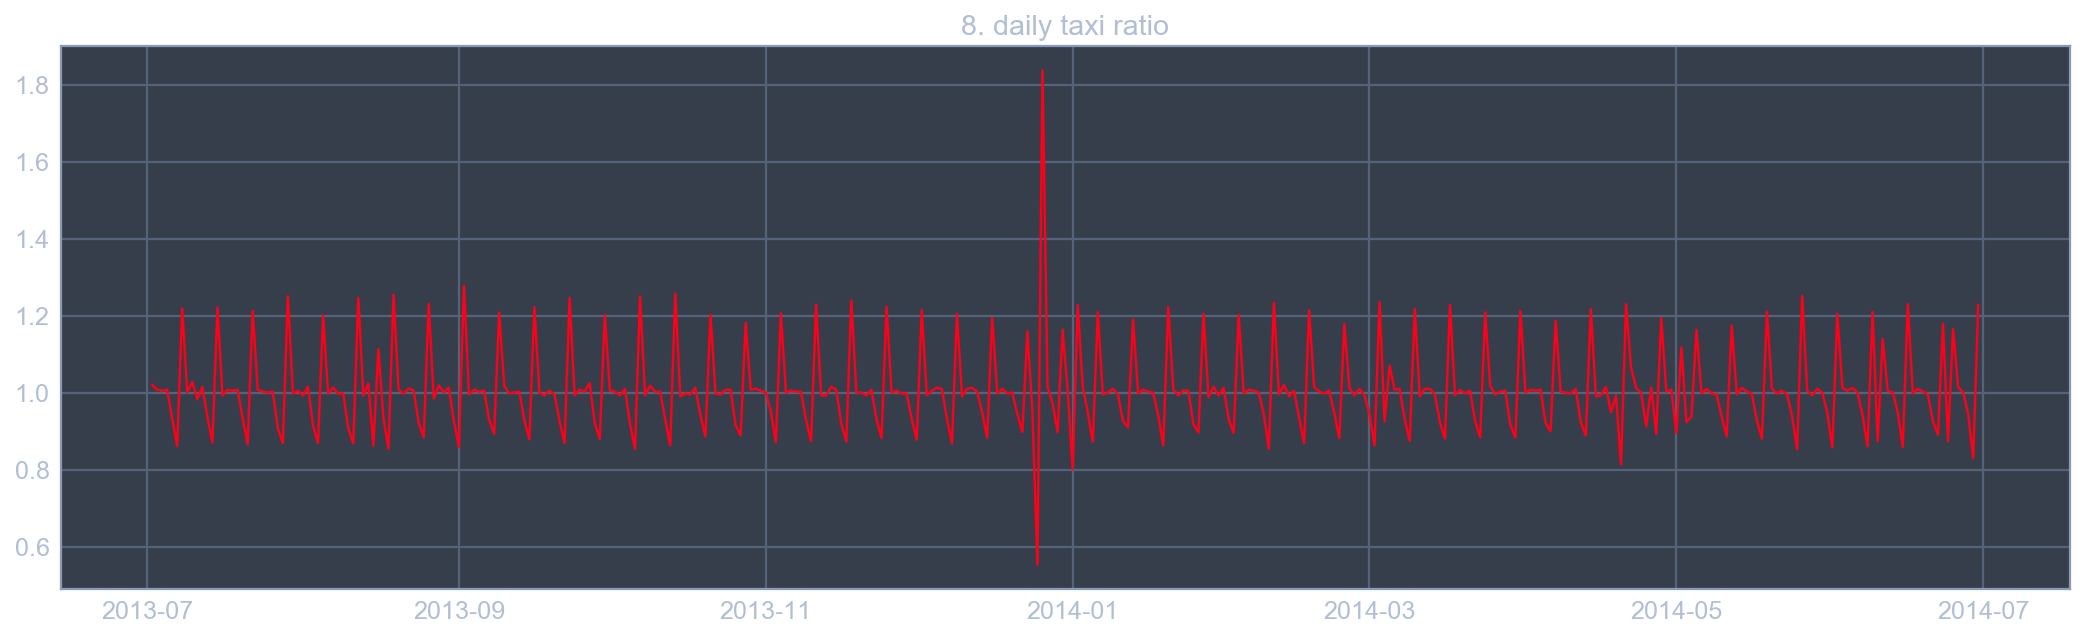

In [6]:
plt.figure(figsize=(18,5))
plt.title('3. n rides per day')
plt.plot(df_rides.index, df_rides.n_rides, c=plt.cm.get_cmap('hsv', 11)(1))
plt.show()

plt.figure(figsize=(18,5))
plt.title('4. n taxis per day')
plt.plot(df_rides.index, df_rides.n_taxis, c=plt.cm.get_cmap('hsv', 11)(2))
plt.show()

plt.figure(figsize=(18,5))
plt.title('5. daily trip diff')
plt.plot(df_rides.index, df_rides.diff_trips, c=plt.cm.get_cmap('hsv', 11)(3))
plt.show()

plt.figure(figsize=(18,5))
plt.title('6. daily taxi diff')
plt.plot(df_rides.index, df_rides.diff_taxis, c=plt.cm.get_cmap('hsv', 11)(5))
plt.show()

plt.figure(figsize=(18,5))
plt.title('7. daily trip ratio')
plt.plot(df_rides.index, df_rides.ratio_trips, c=plt.cm.get_cmap('hsv', 11)(8))
plt.show()

plt.figure(figsize=(18,5))
plt.title('8. daily taxi ratio')
plt.plot(df_rides.index, df_rides.ratio_taxis, c=plt.cm.get_cmap('hsv', 11)(10))
plt.show()

## 1.2 Find anomalies

### 1.2.1 Write a function that accepts a series and a threshold and returns the indices of values that are anomalues 

In [7]:
def get_anomalies(series, threshold, is_histogram=False): # threshold as a multiple of std
    if is_histogram:
        mean = np.dot(series.index, series.values)/series.values.sum()
        std = np.sqrt(np.dot(np.square(series.index-mean),series.values)/series.values.sum())
        return series[abs(series.index-mean) > threshold * std]
    else:
        return series[abs(series.values-series.mean()) > threshold * series.std()]
    
def binify_series(series, bins):
    bin_length = (series.index.max()-series.index.min())/bins
    df = pd.DataFrame(series)
    df['bin'] = df.index // bin_length * bin_length
    df = df.set_index('bin').groupby('bin').sum()
    
    return df[df.columns[0]], bin_length

print(get_anomalies(df_rides.n_rides, 2))
# print(get_anomalies(df_trips_duration.nTrips, 2, is_density=True))

date
2013-09-20    5832
2013-09-27    6349
2013-11-01    5921
2013-11-26    7114
2013-12-20    6345
2013-12-21    6072
2013-12-25    2036
2014-01-01    7012
2014-05-04    6210
2014-05-06    6098
2014-05-07    5920
2014-05-08    5835
2014-05-09    6520
2014-05-10    5916
2014-06-06    6885
2014-06-07    6389
2014-06-24    6395
Name: n_rides, dtype: int64


### 1.2.2 For each of the series apply the iterative gaussian anomaly detection algorithm

1. Plot the histogram before removing anomalies 
1. At each iteration, plot the histogram after removing the anomalous values 
1. Print the number of points removed at each iteration and in total
1. For the time series visualize the anomalies on the time series plot

Use 100 bins in the histogram

Use a threshold of 3 standard deviations 

Series <trips_by_length>


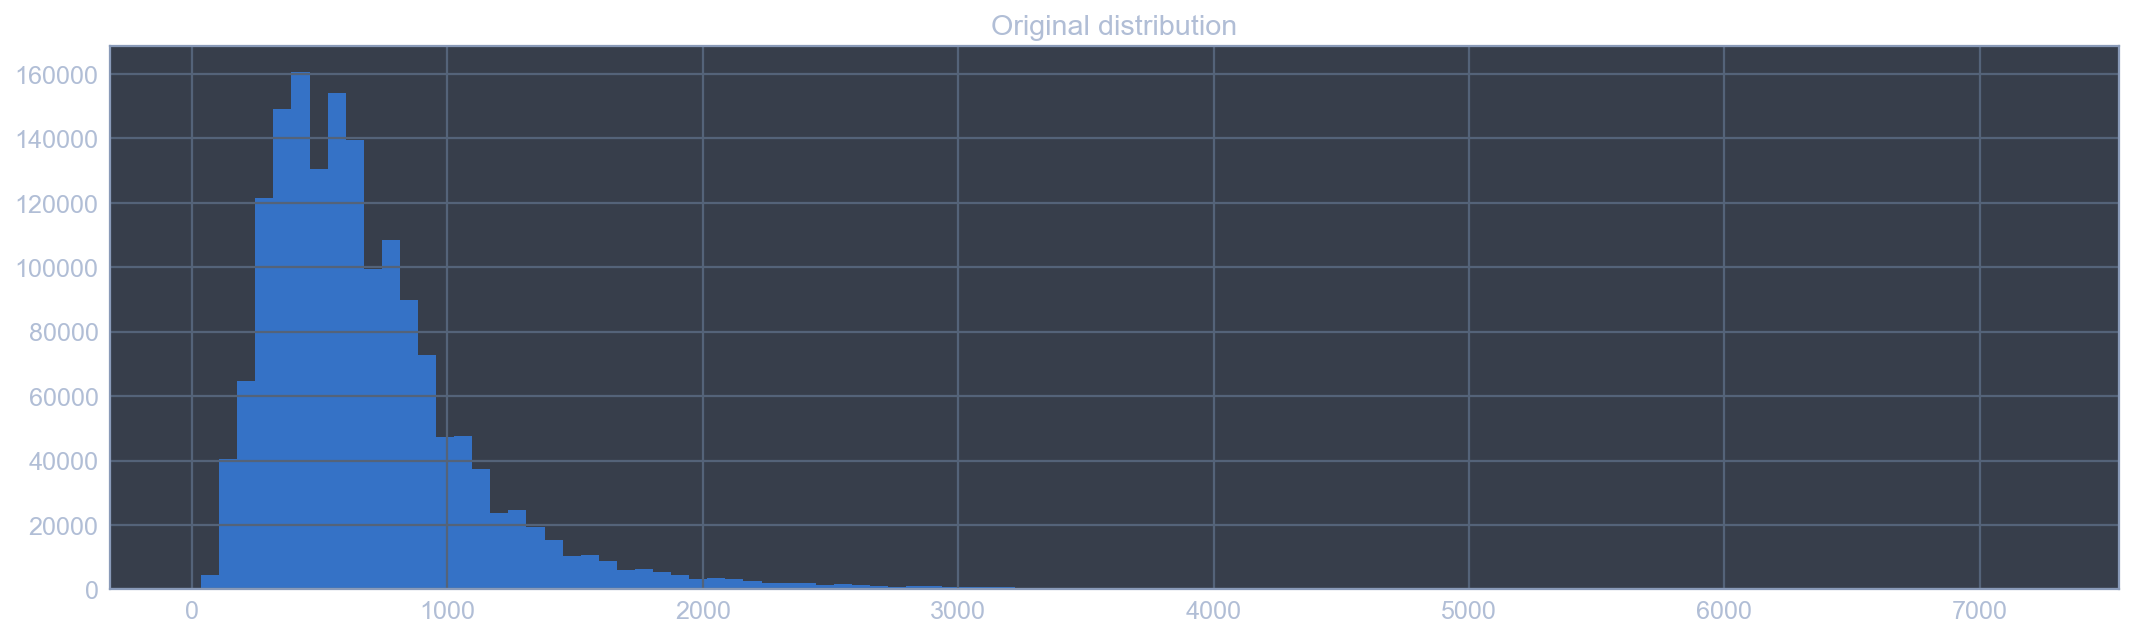

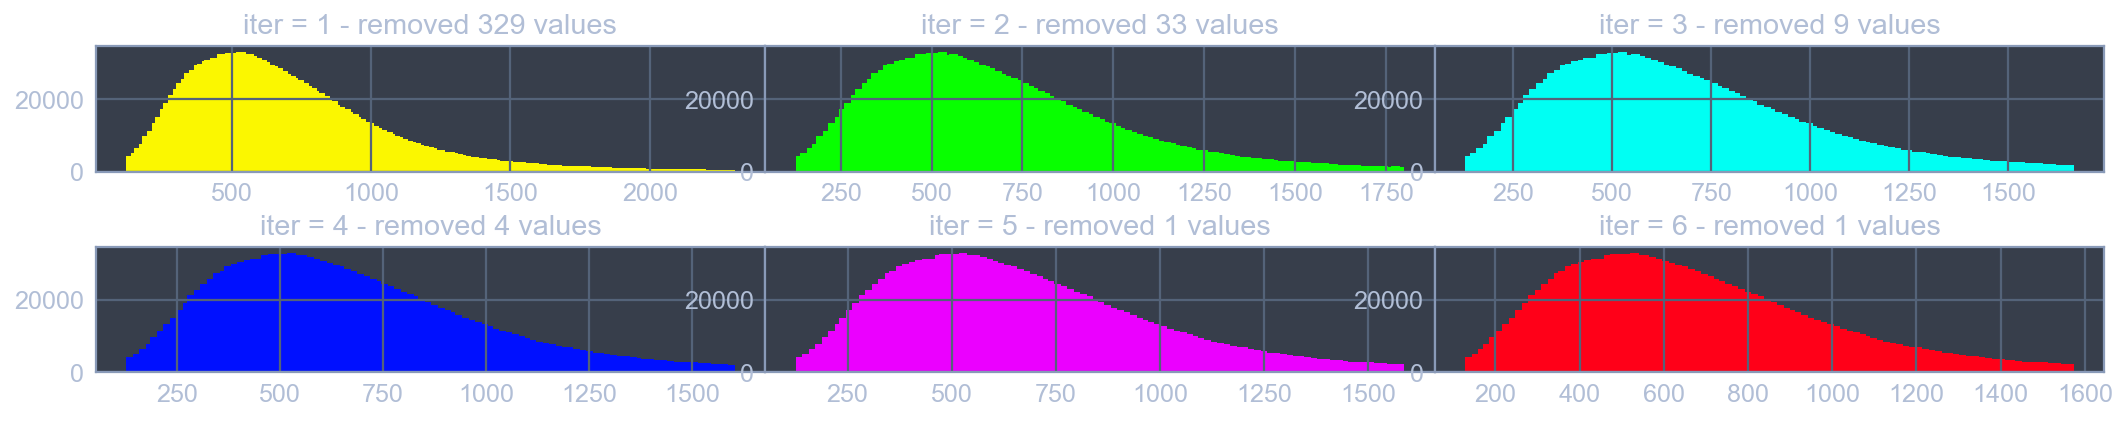

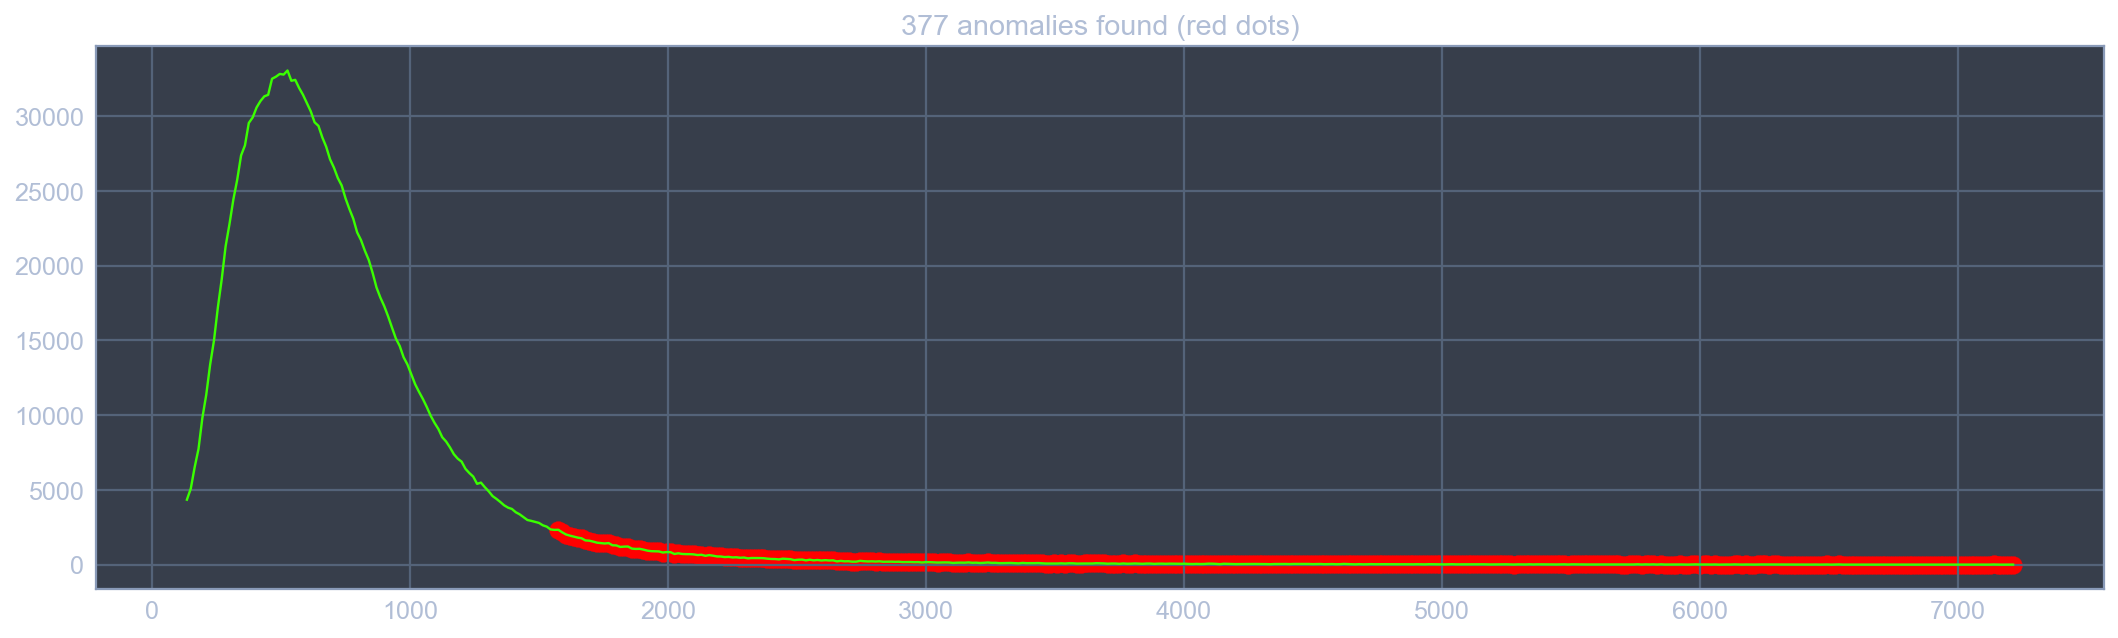

Series <trips_by_taxi_id>


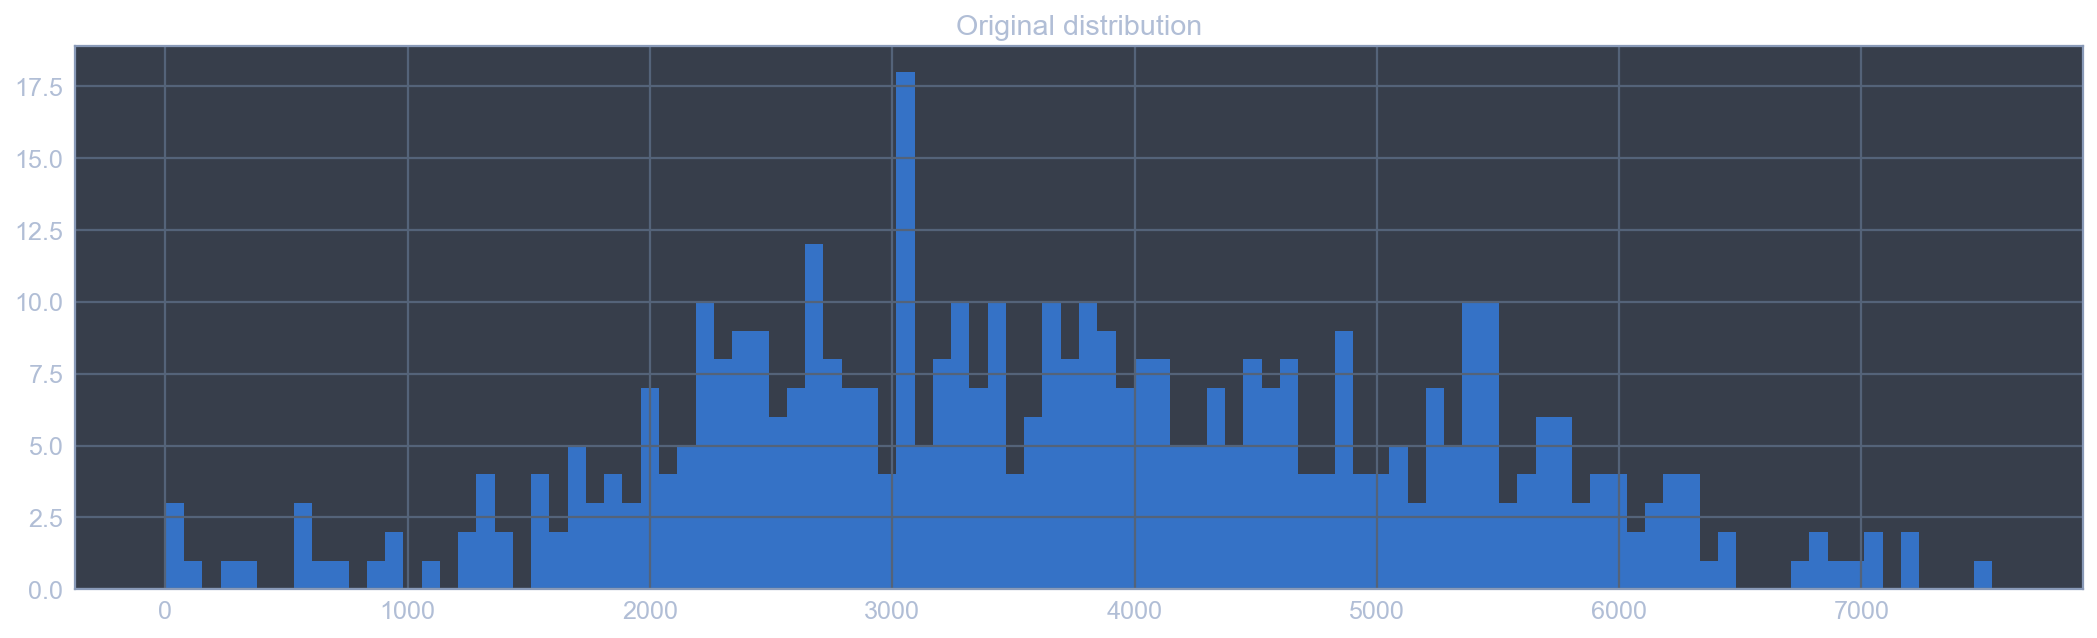

<Figure size 1296x216 with 0 Axes>

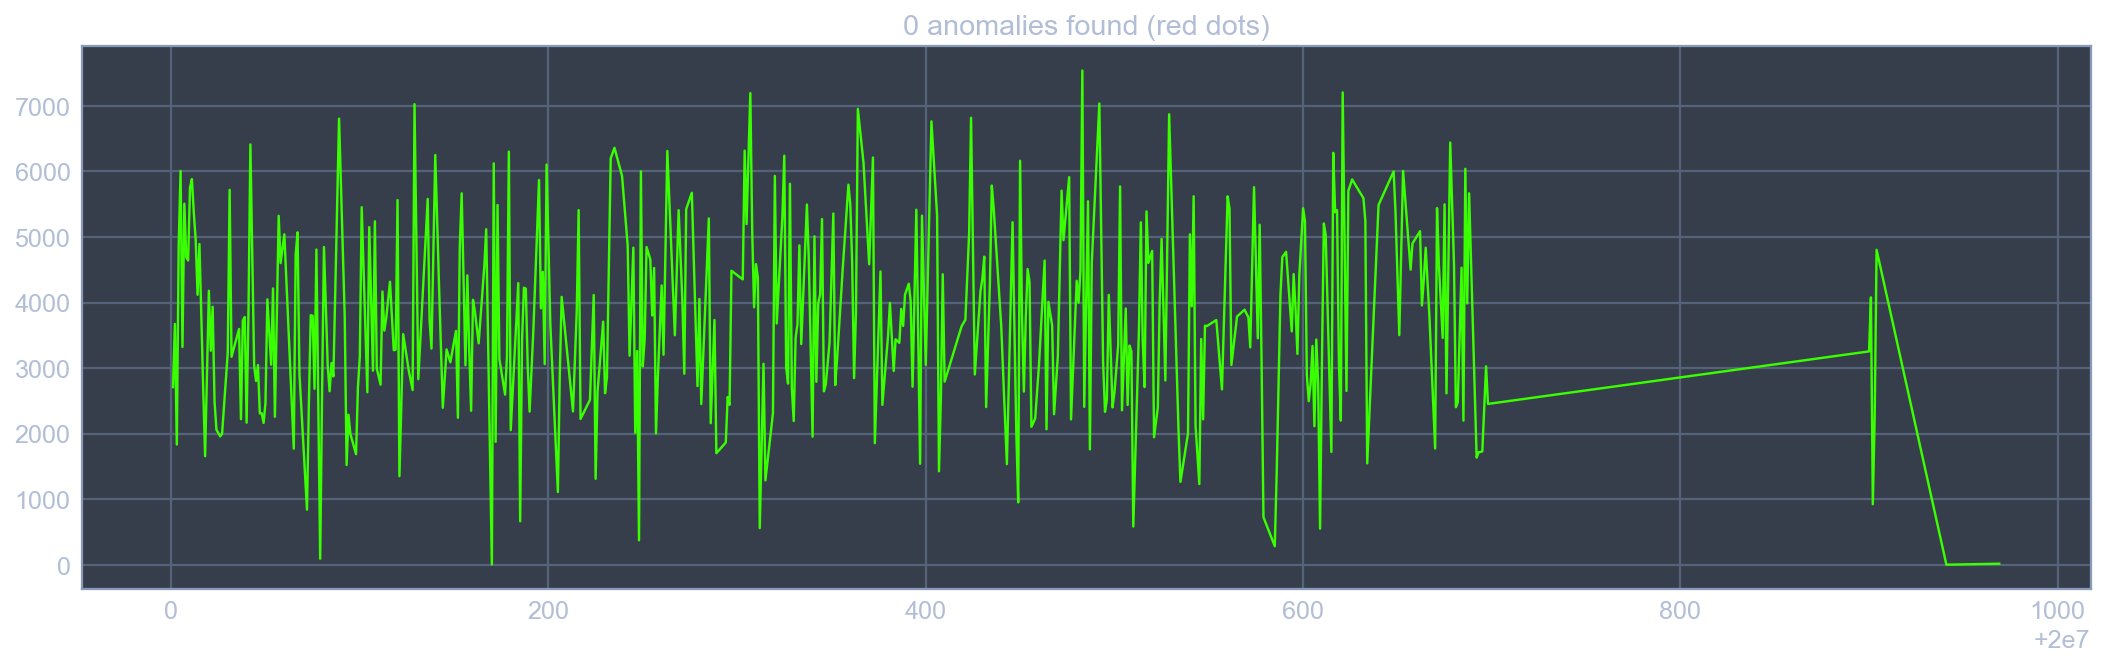

Series <n_rides>


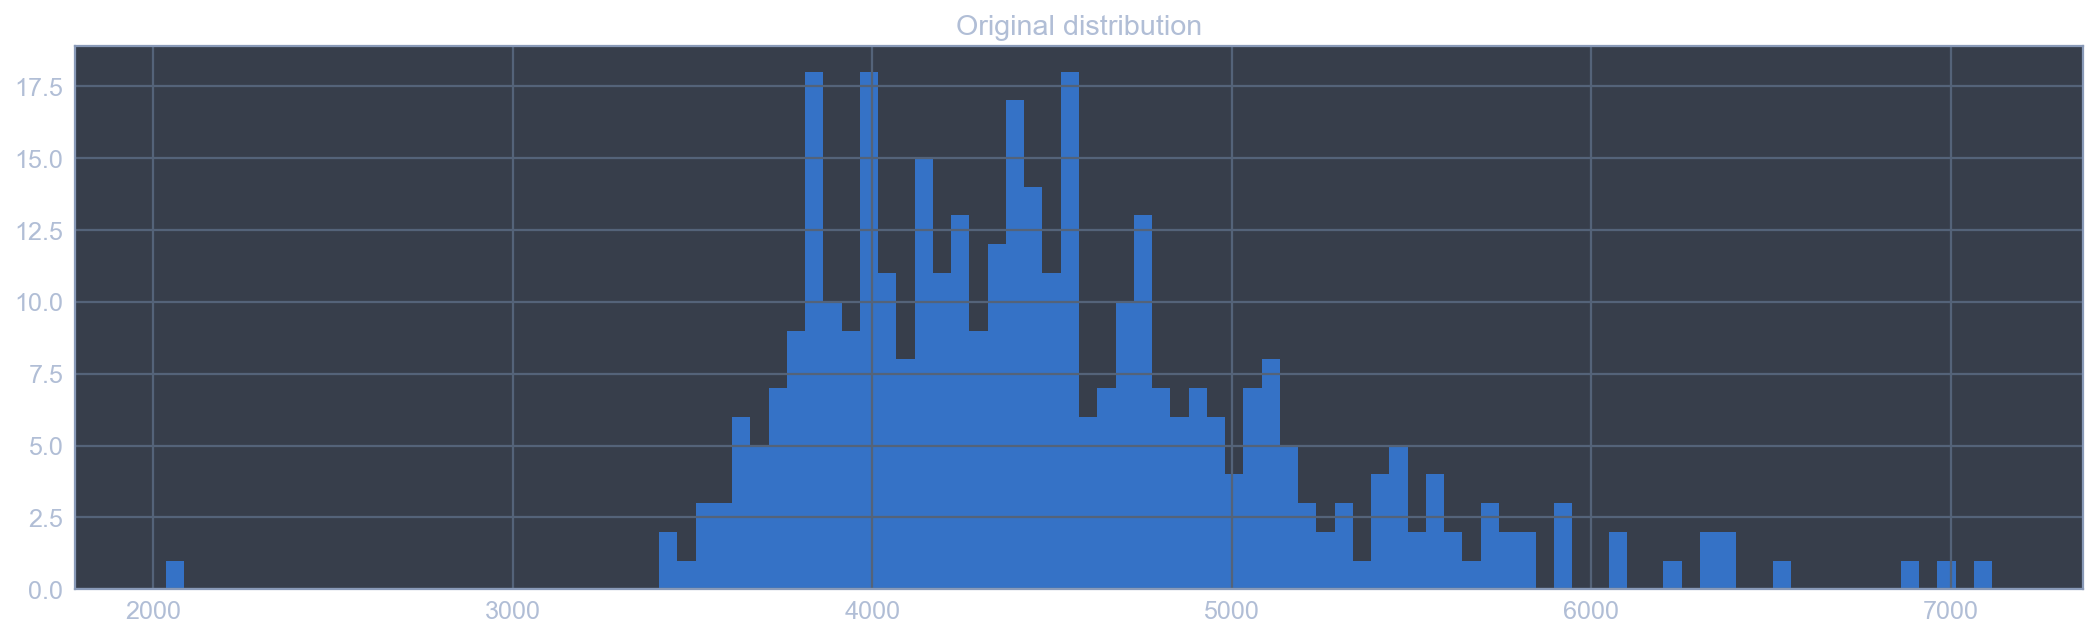

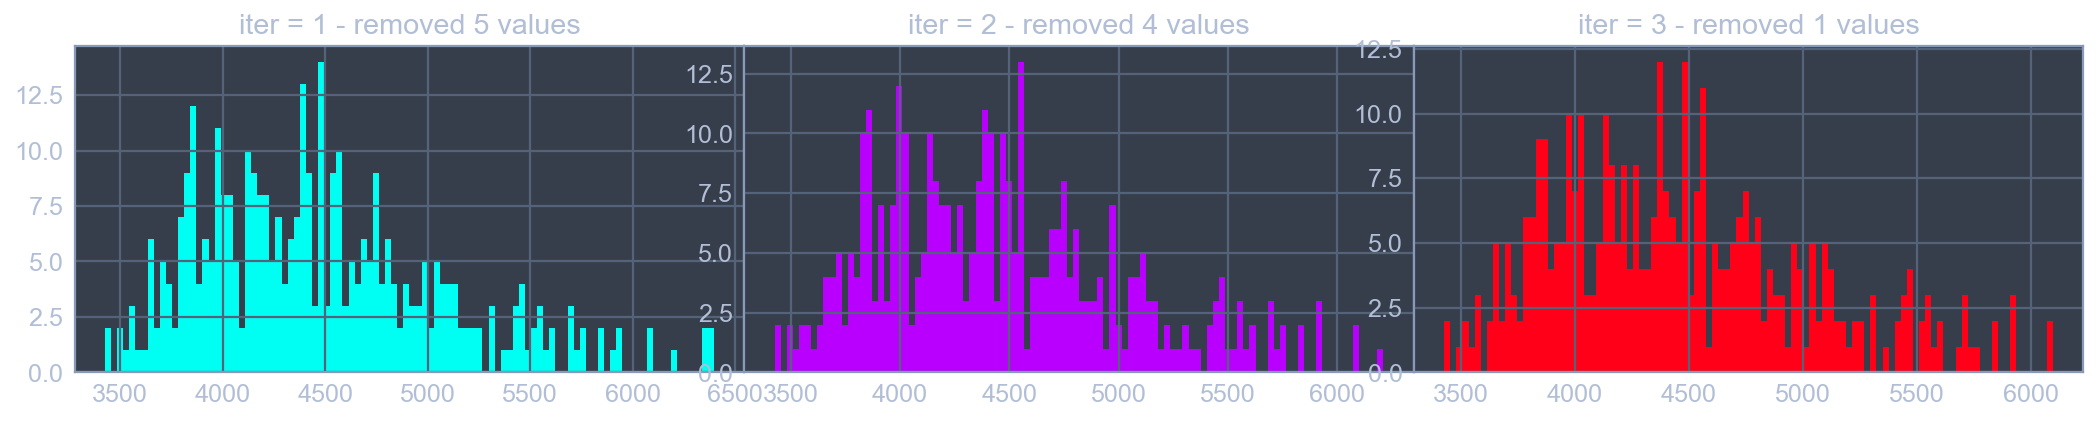

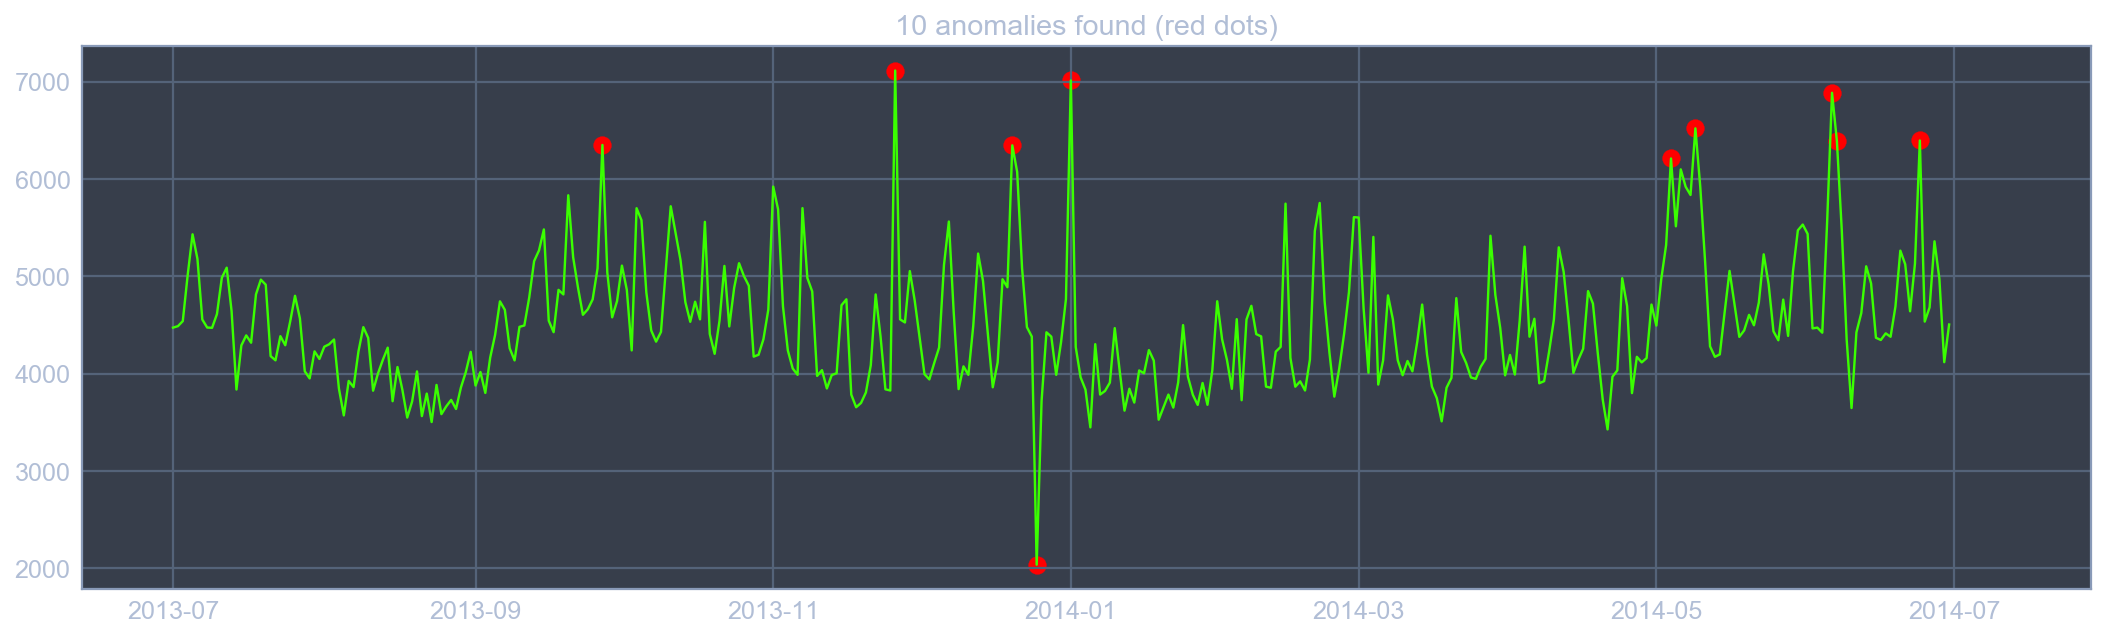

Series <n_taxis>


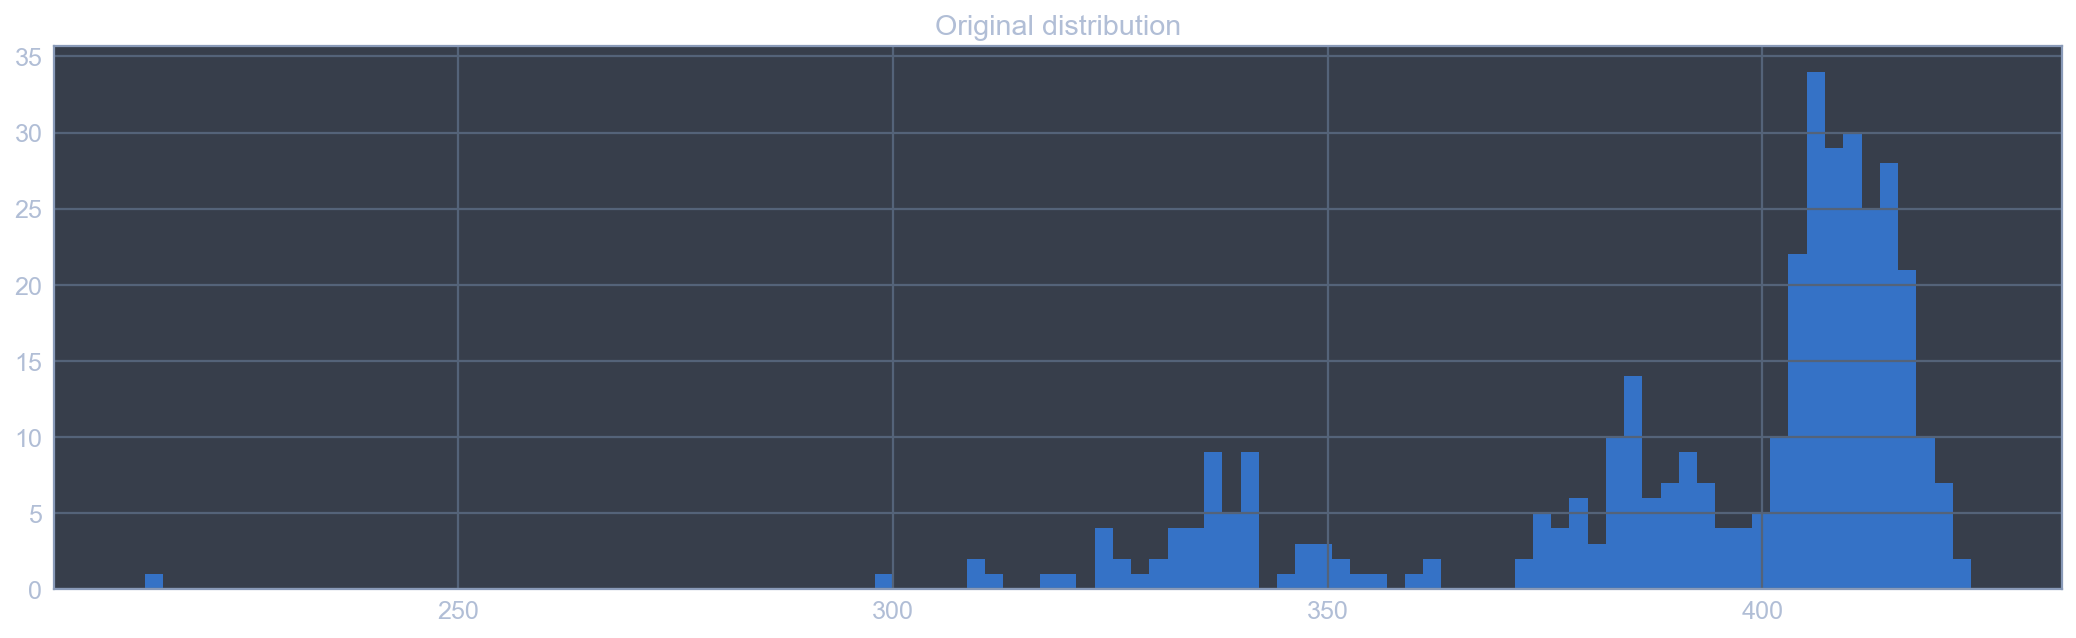

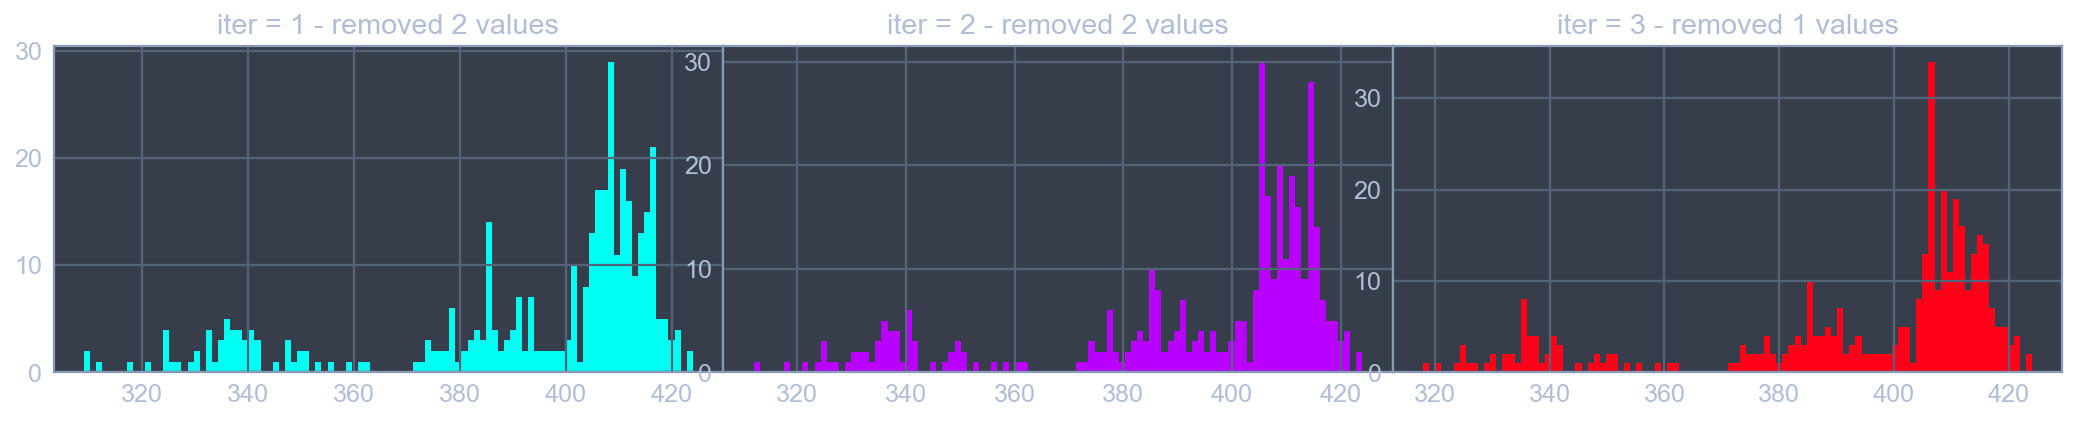

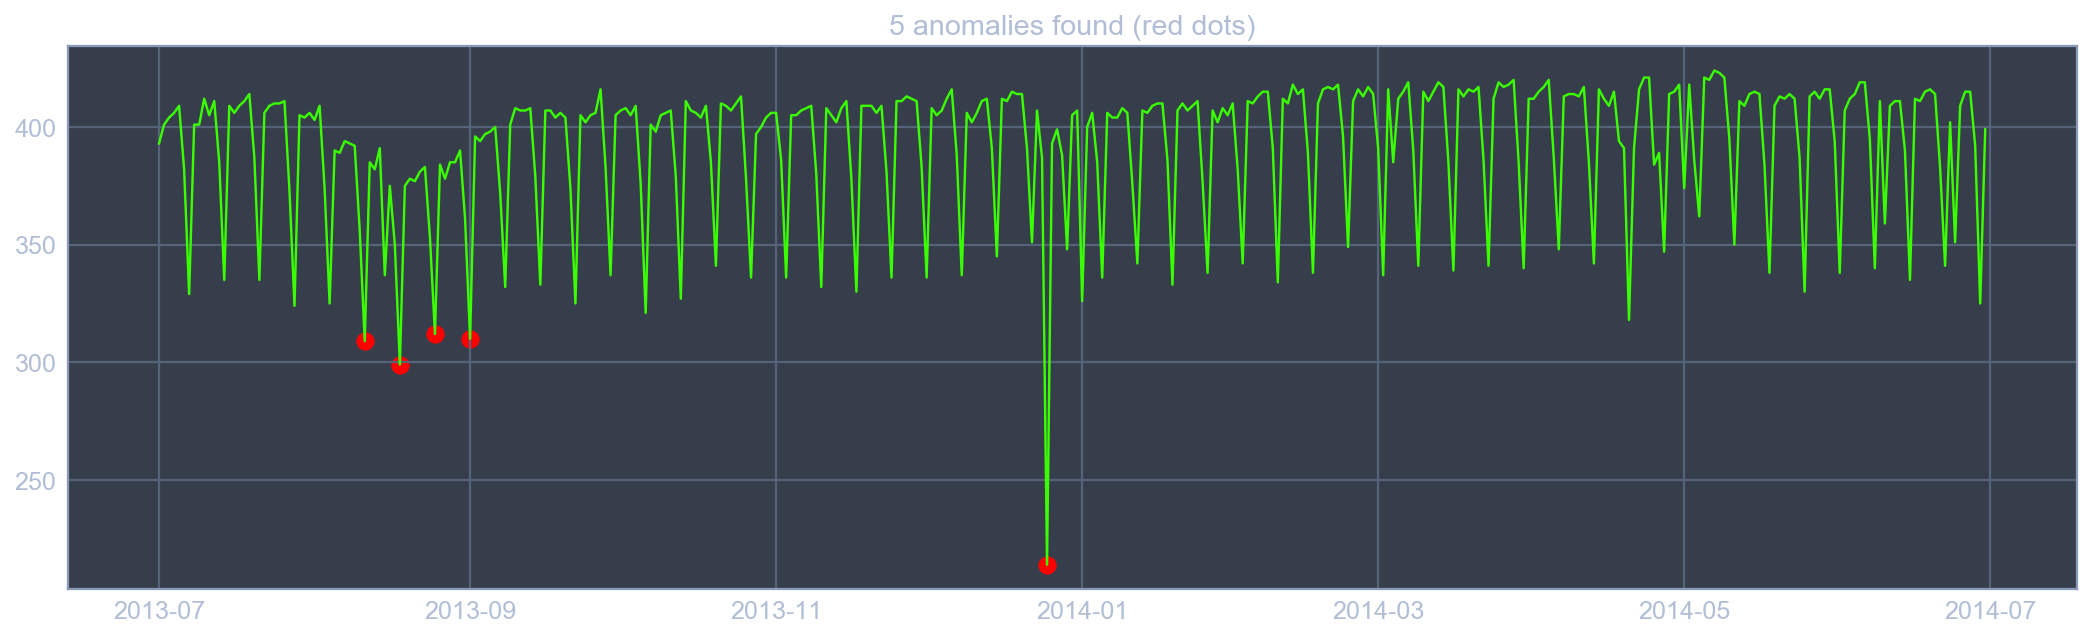

Series <diff_trips>


/Users/jeremybensoussan/anaconda3/envs/ITC/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jeremybensoussan/anaconda3/envs/ITC/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


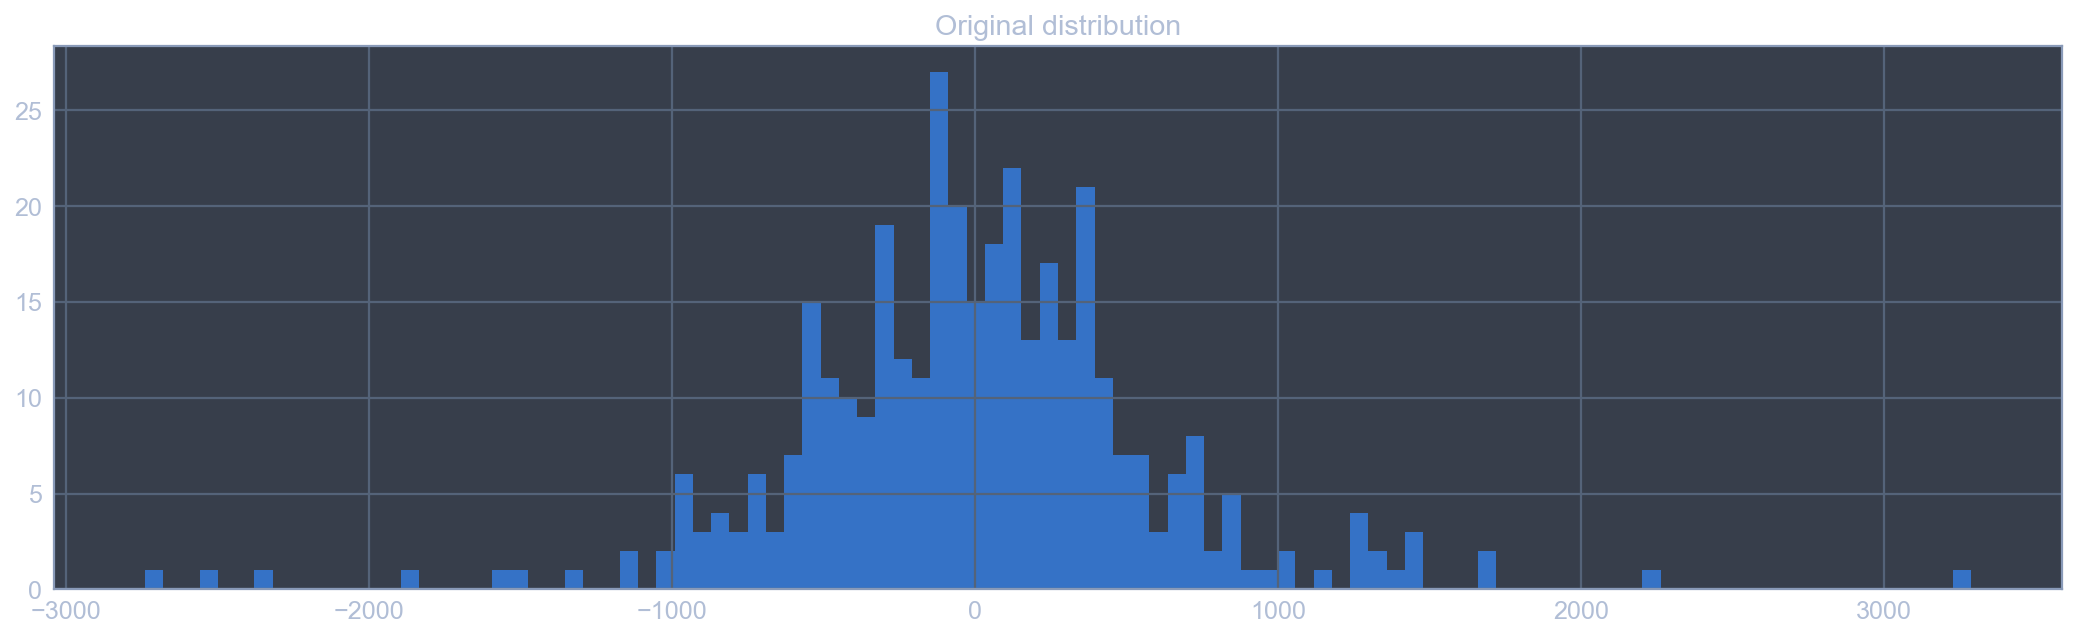

/Users/jeremybensoussan/anaconda3/envs/ITC/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


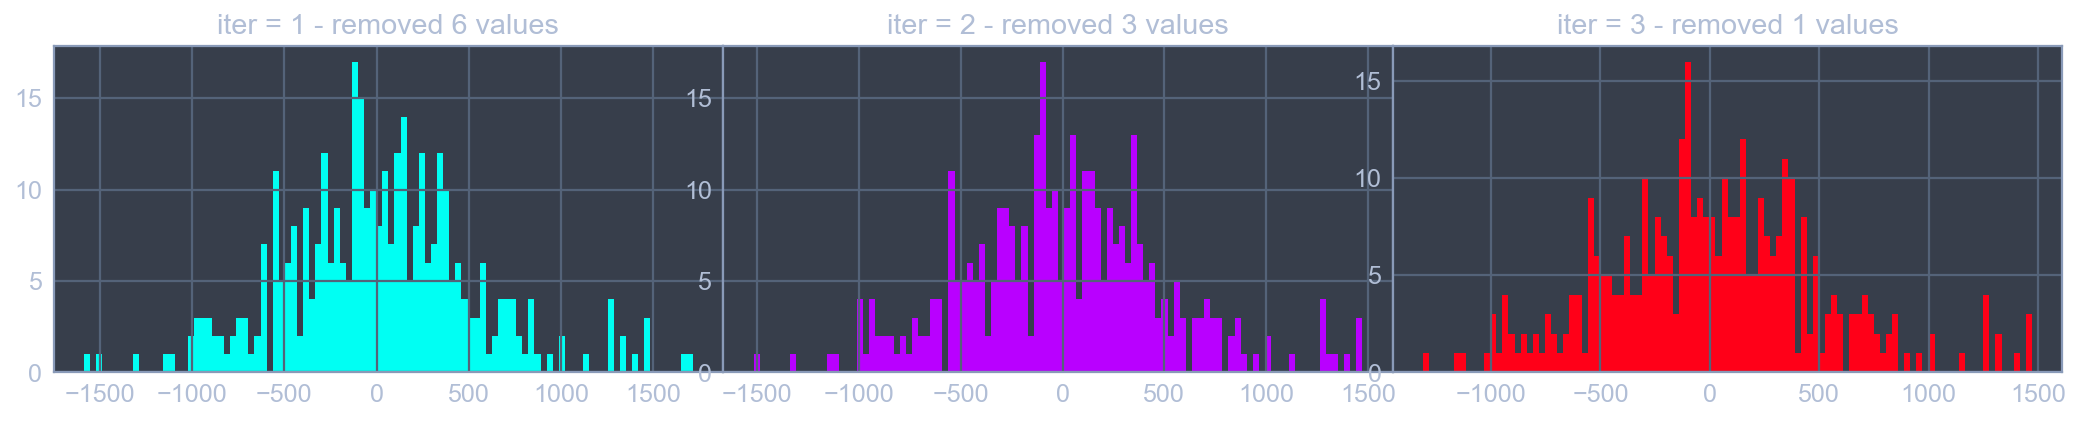

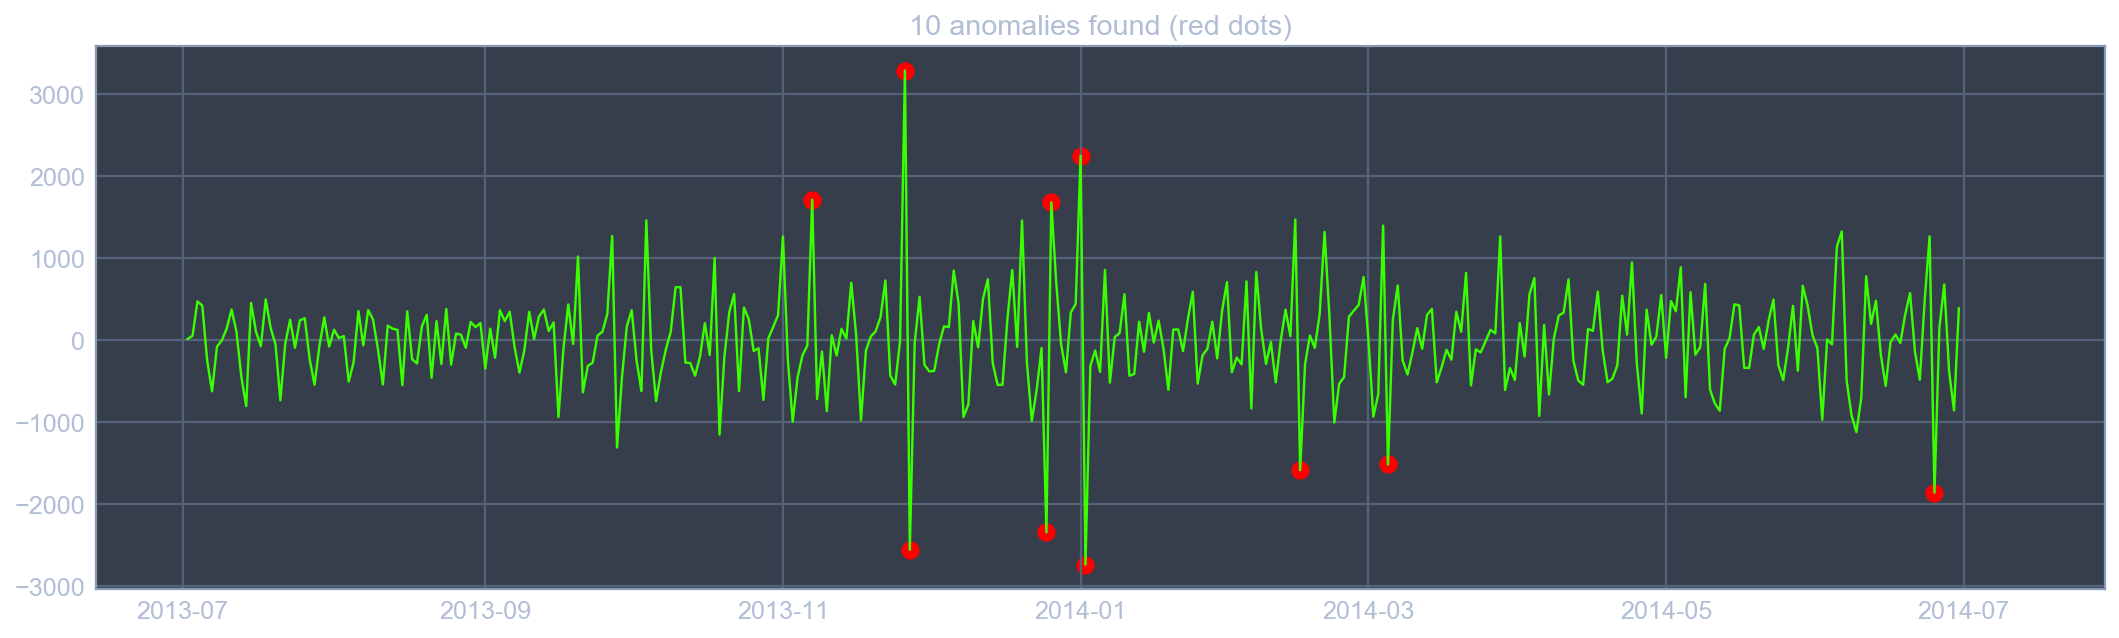

Series <diff_taxis>


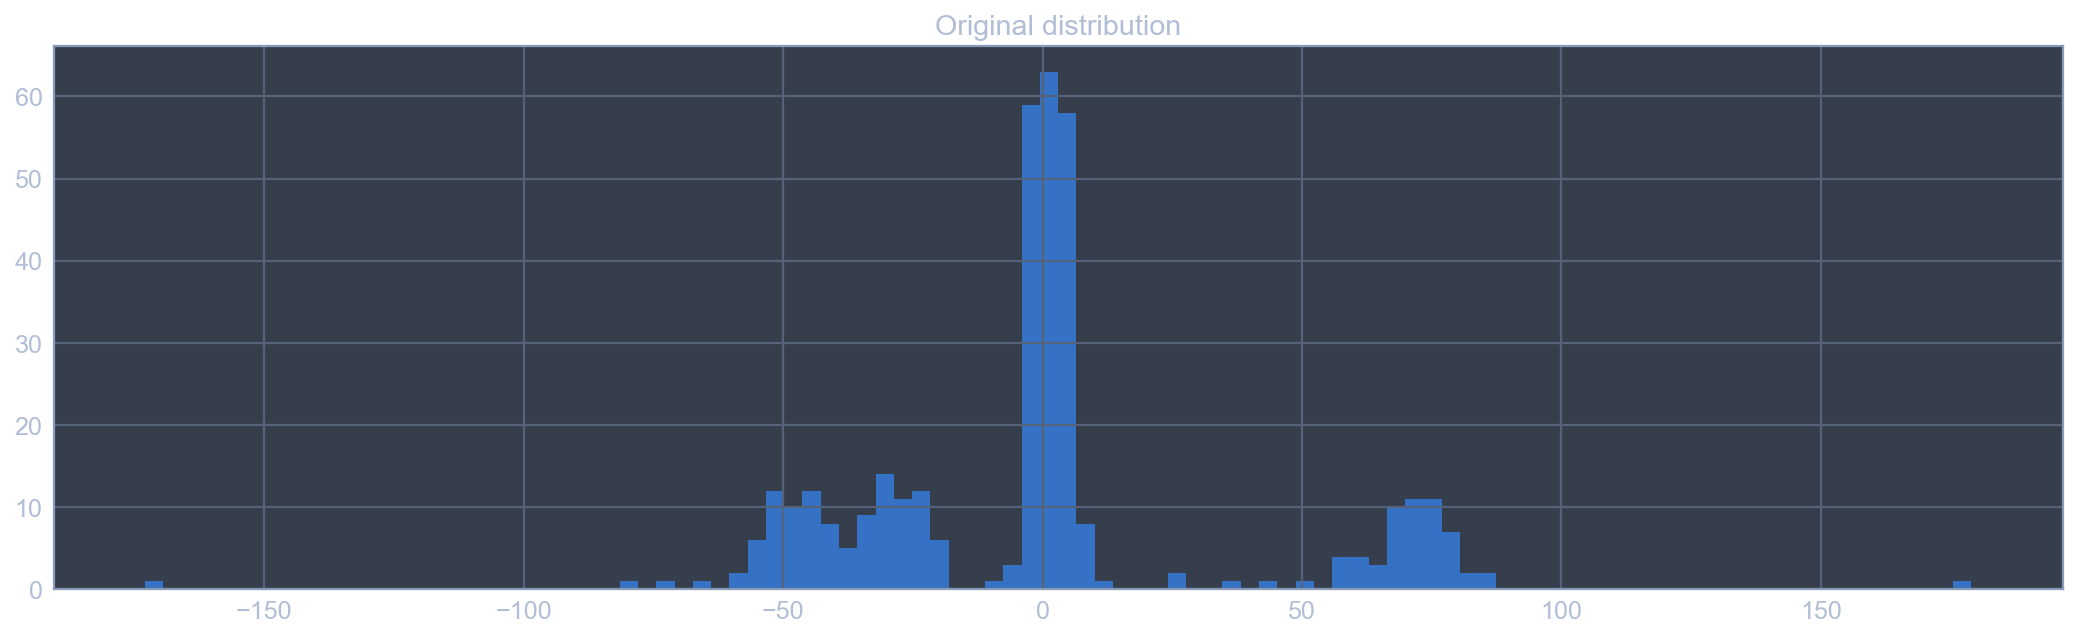

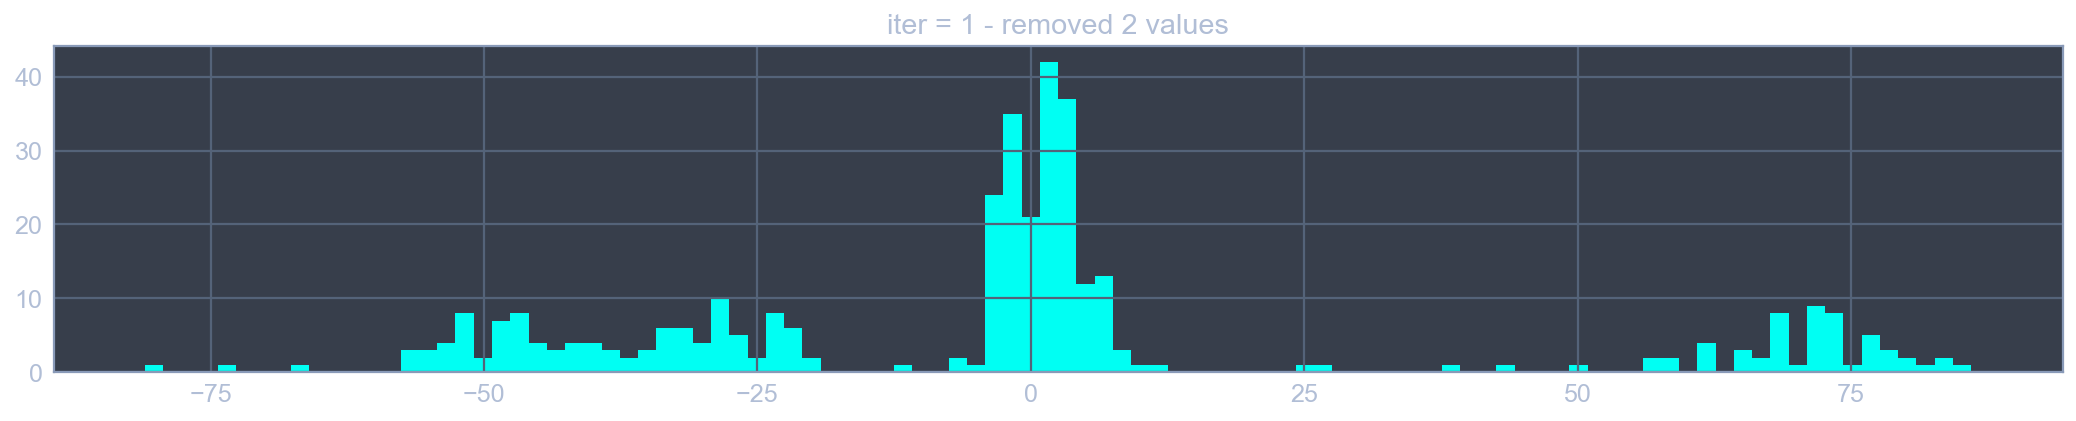

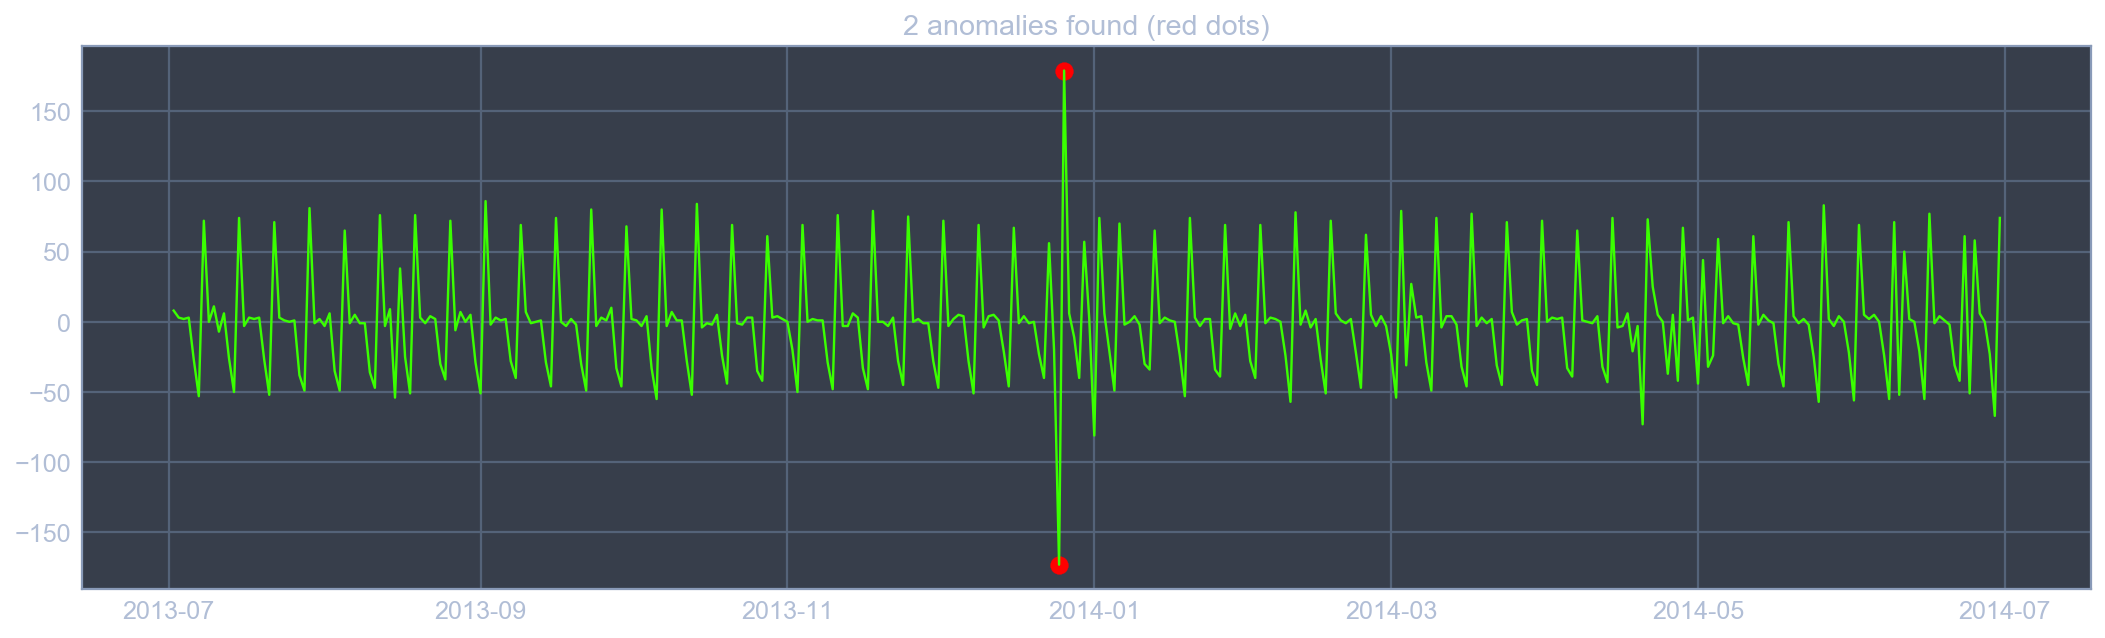

Series <ratio_trips>


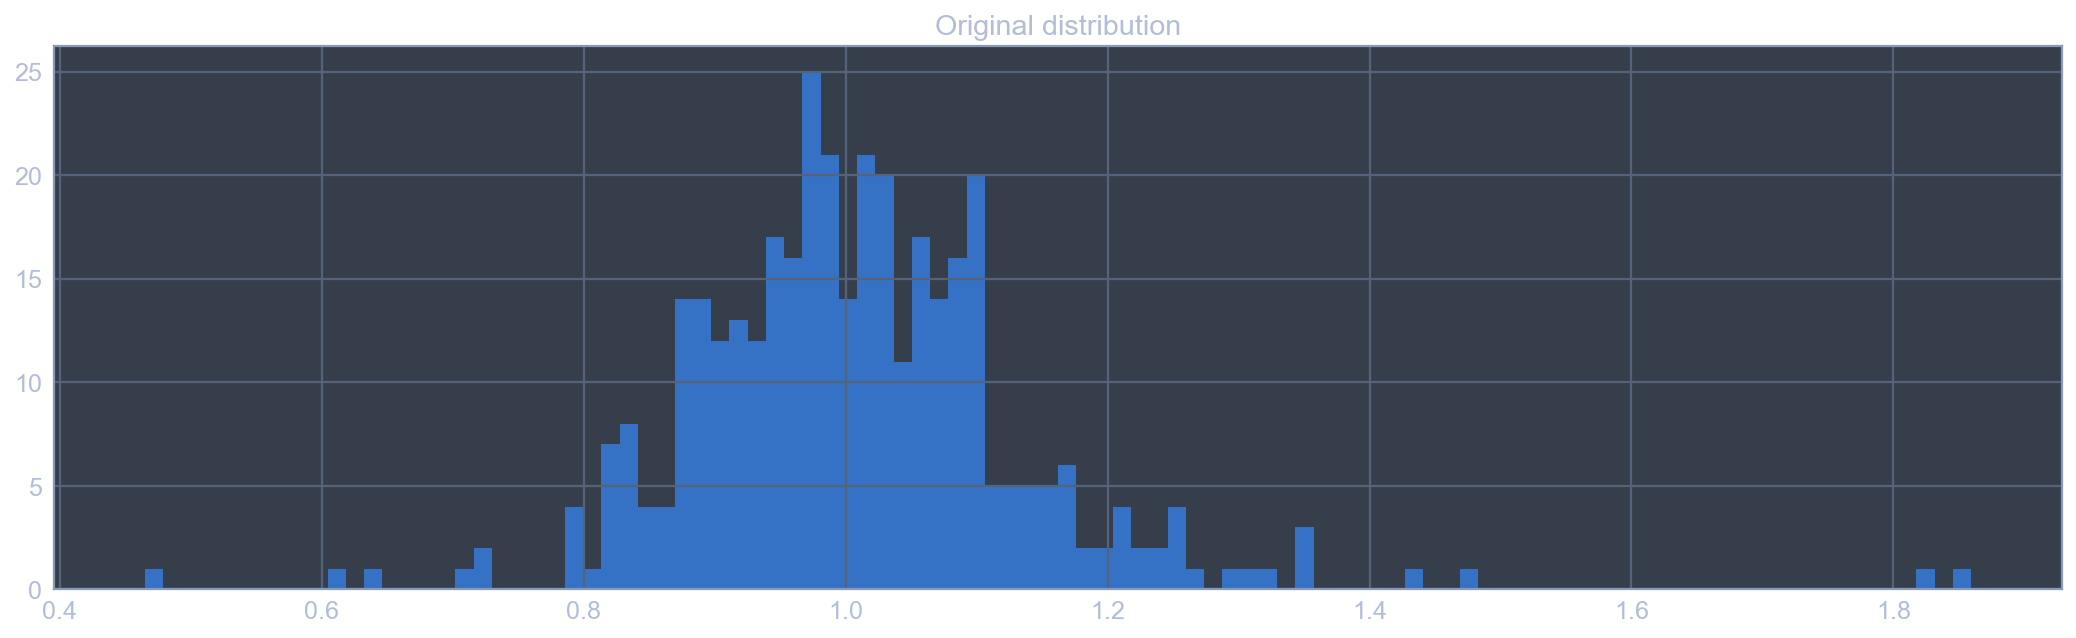

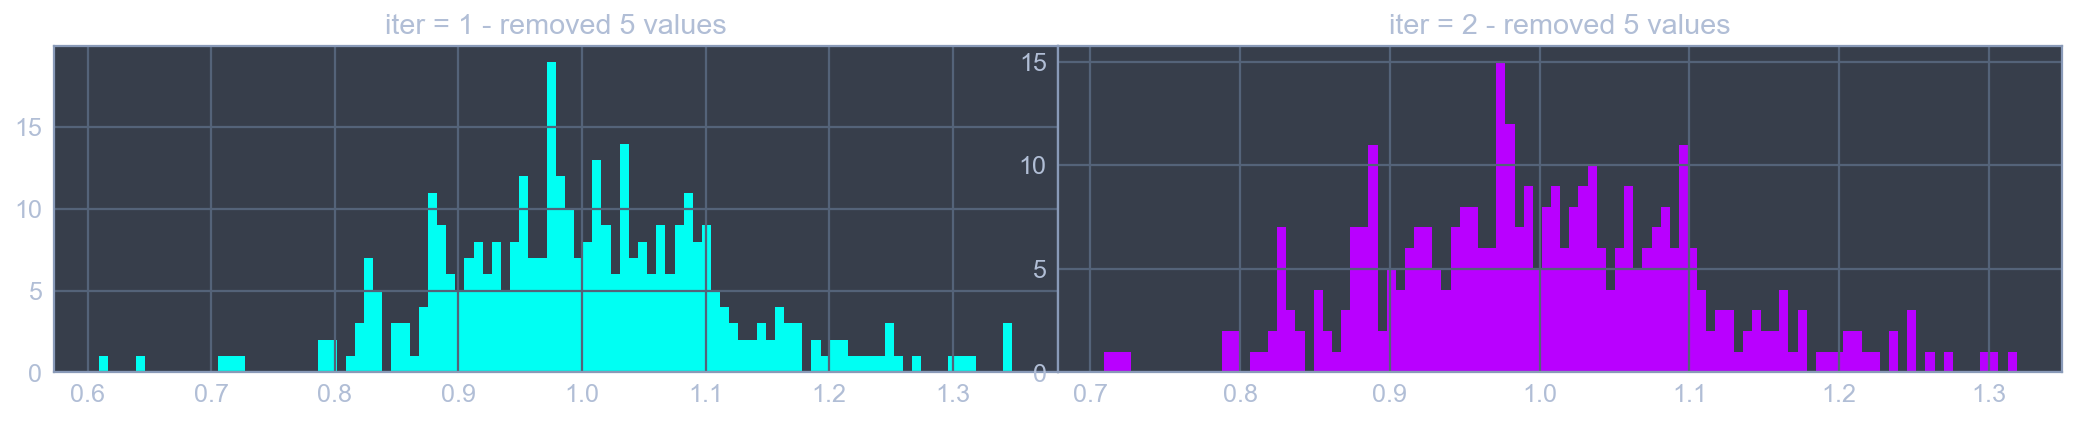

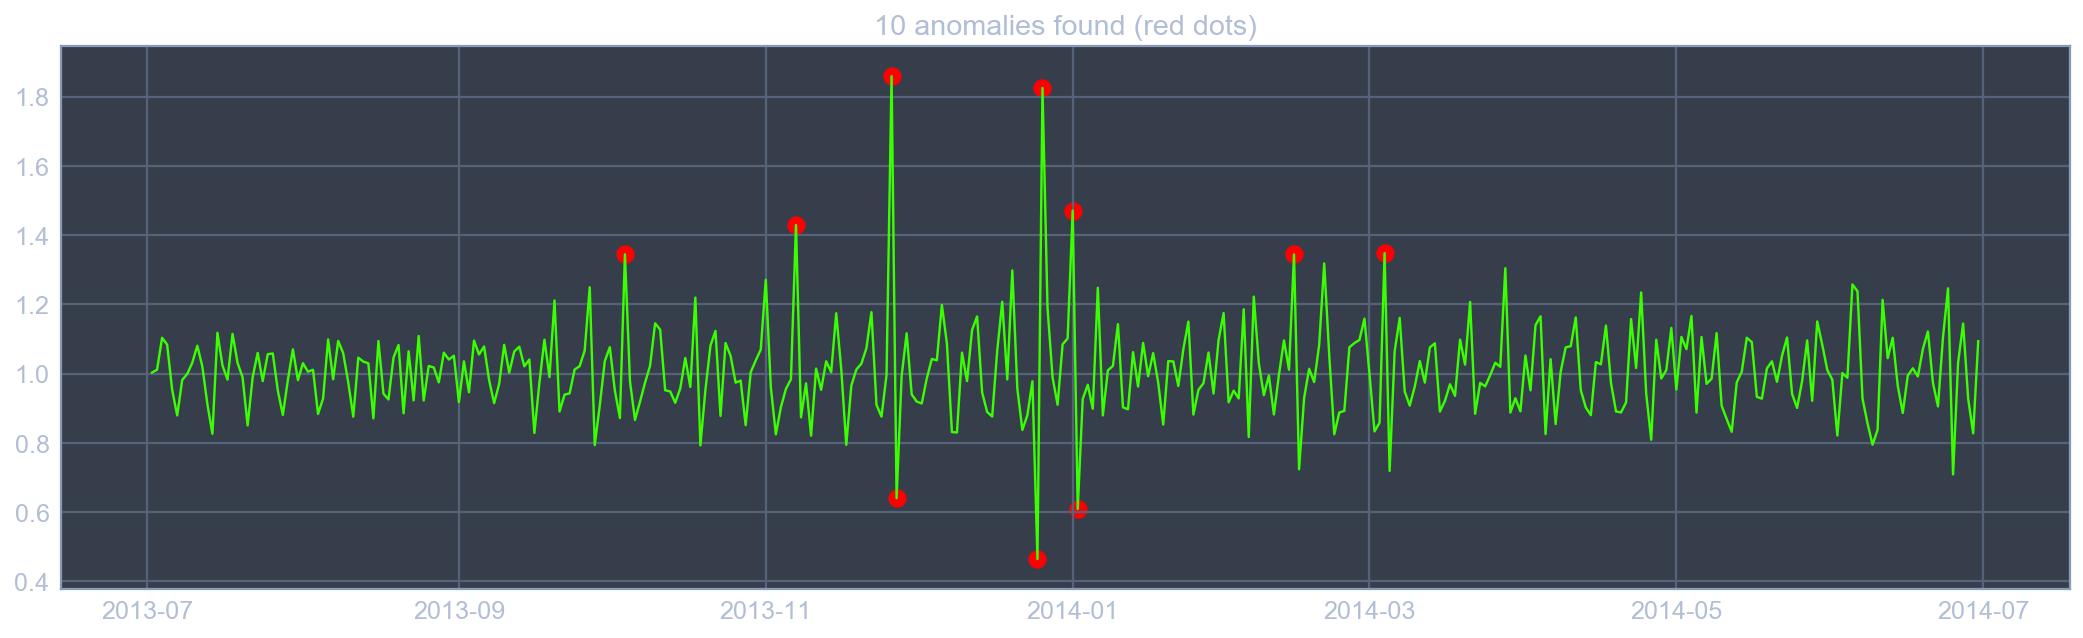

Series <ratio_taxis>


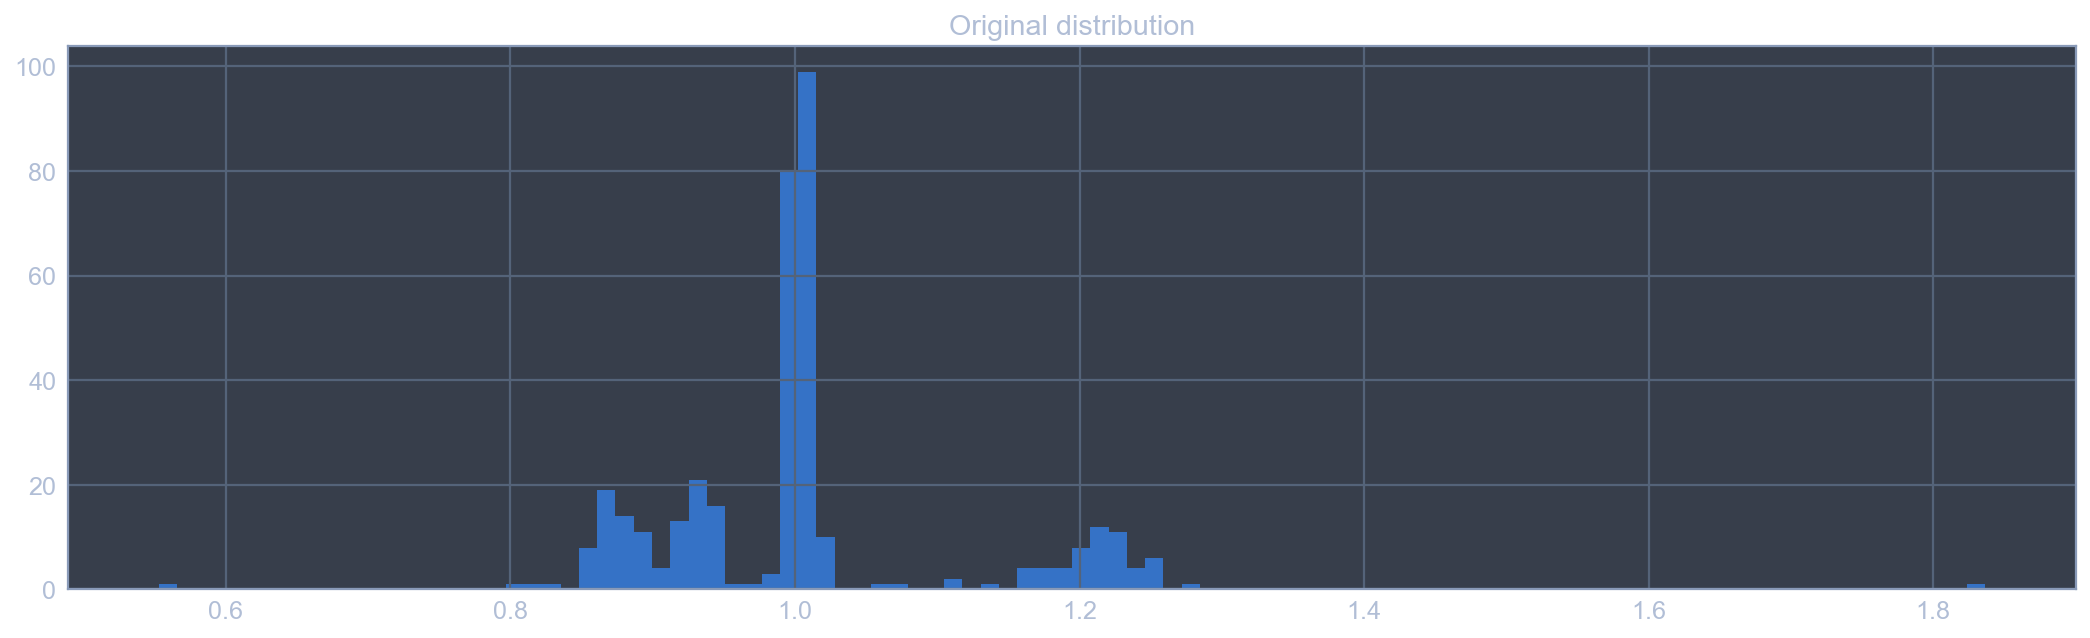

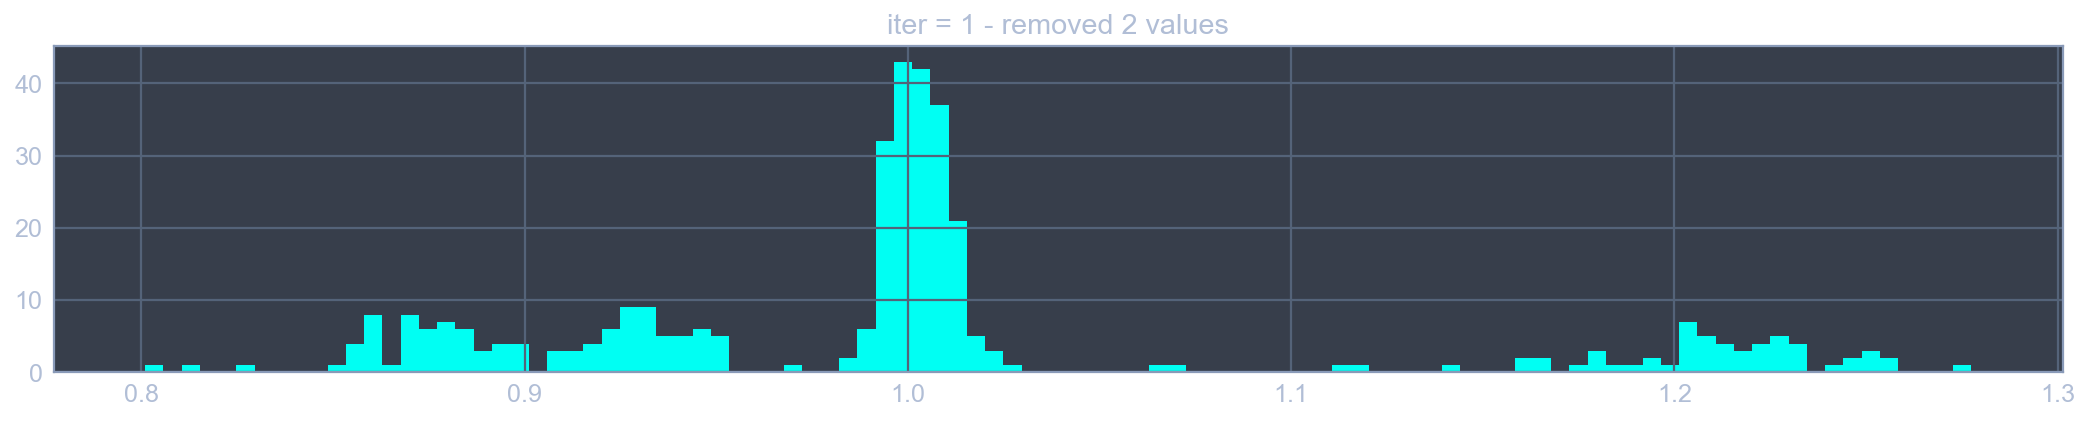

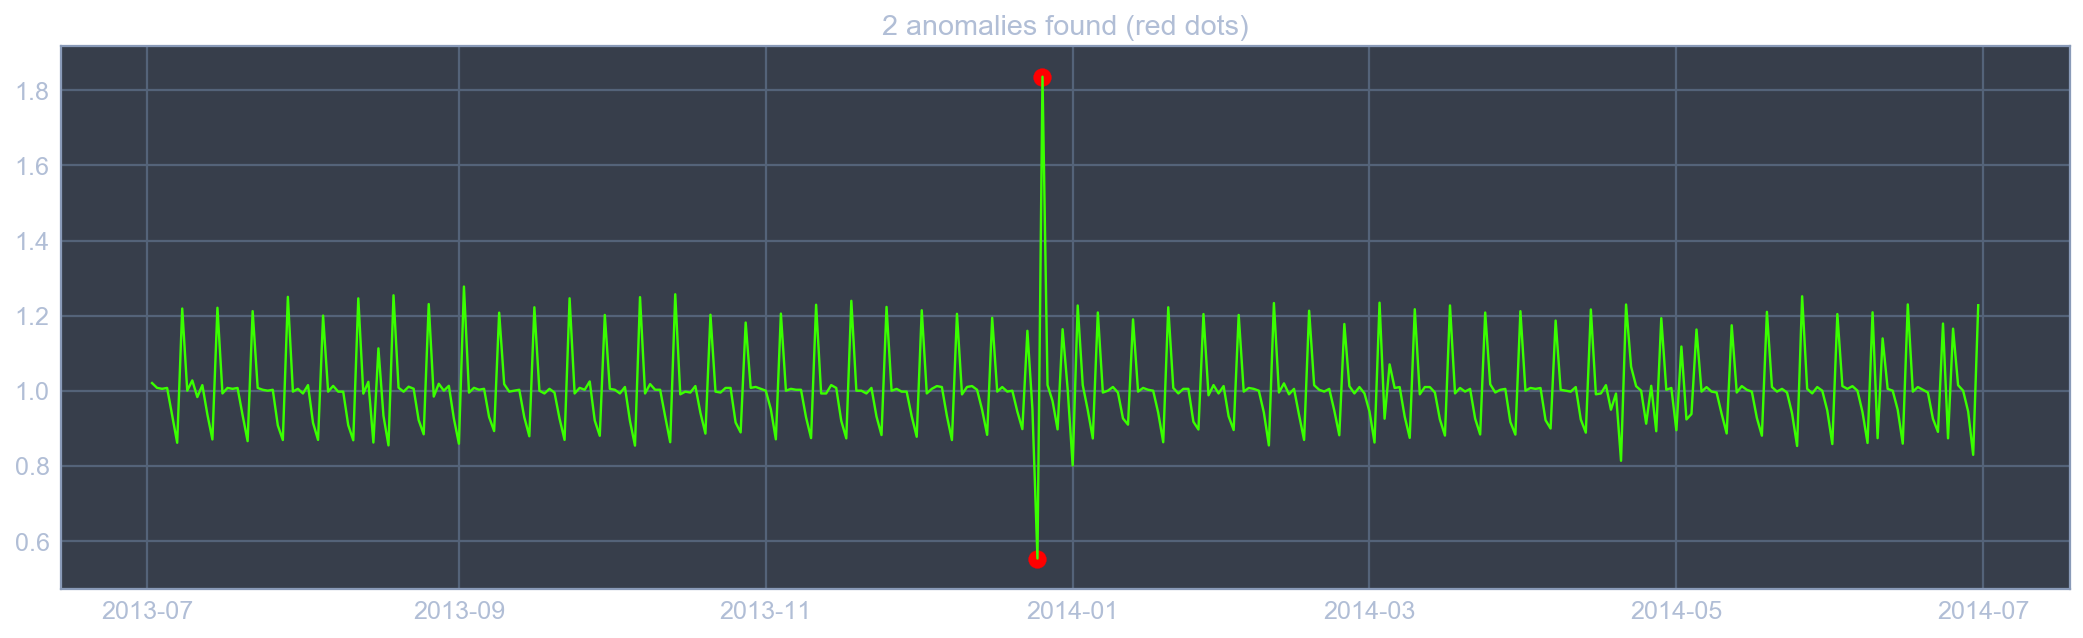

In [8]:
def gaussian_anomaly_detection(orig_series, threshold, is_histogram=False):
    current_series = orig_series.copy()
    series = current_series.name
    print("Series <%s>" % series)
    plt.figure(figsize=(18,5))
    plt.title('Original distribution')
    if is_histogram:
        df_bins, bin_size = binify_series(current_series, bins=100)
        plt.bar(df_bins.index, df_bins.values, bin_size)
    else:
        plt.hist(current_series, bins=100)
    plt.show()

    # Start with one
    fig = plt.figure(figsize=(18,3))
    n_rows = 1
    n_subplots = 0
    plt.subplots_adjust(wspace=0, hspace=0.6)

    itr = 1
    removed_anomalies = pd.Series([])
    while True:
        anomalies = get_anomalies(current_series, threshold, is_histogram)
        if len(anomalies) == 0:
            break
            
        removed_anomalies = pd.concat([removed_anomalies, anomalies])
        current_series = current_series[~current_series.index.isin(anomalies.index)]

        n_rows = (itr-1)//3+1
        n_cols = itr if itr < 3 else 3
        for i in range(len(fig.axes)):
            fig.axes[i].change_geometry(n_rows, n_cols, i+1)
        ax = fig.add_subplot(n_rows, n_cols, itr)
        
        np.random.seed(itr)
        ax.set_title('iter = %d - removed %d values' % (itr, len(anomalies)))
        if is_histogram:
            np.random.seed(itr)
            df_bins, bin_size = binify_series(current_series, bins=100-len(removed_anomalies))
            plt.bar(df_bins.index, df_bins.values, bin_size*4, color=plt.cm.get_cmap('hsv', 7)(itr))
        else:
            ax.hist(current_series, bins=100,  color=plt.cm.get_cmap('hsv', 11)(np.random.randint(11)))

        itr += 1
    
    if itr > 1 :
        plt.show()
#     print('Removed {} anomalies in total'.format(len(removed_anomalies)))
    
    plt.figure(figsize=(18,5))
    plt.title('%d anomalies found (red dots)' % len(removed_anomalies))
    plt.scatter(removed_anomalies.index, removed_anomalies.values, s=80, c='red')
    plt.plot(orig_series.index, orig_series.values, c=plt.cm.get_cmap('hsv', 11)(3))
    plt.show()
    
    return removed_anomalies

# df_trips_duration is already a density series, so it makes no sense to treat it as a time series
# Also, in order to achieve 100 bins we need to make a couple of changes as follows:
gaussian_anomaly_detection(df_trips_duration.trips_by_length, 3, is_histogram=True)
gaussian_anomaly_detection(df_trips_taxis.trips_by_taxi_id, 3)

for series in df_rides.columns:
    gaussian_anomaly_detection(df_rides[series], 3)
    

# 2. Model based anomaly detection

In this part you will use the model you trained in the Time Series Analysis session on trips per day. The model should be trained on the entire data without train/test split. The model should be trained on a history of 7 days. 


## 2.1 Load/Retrain the model and plot the prediction and the actual data

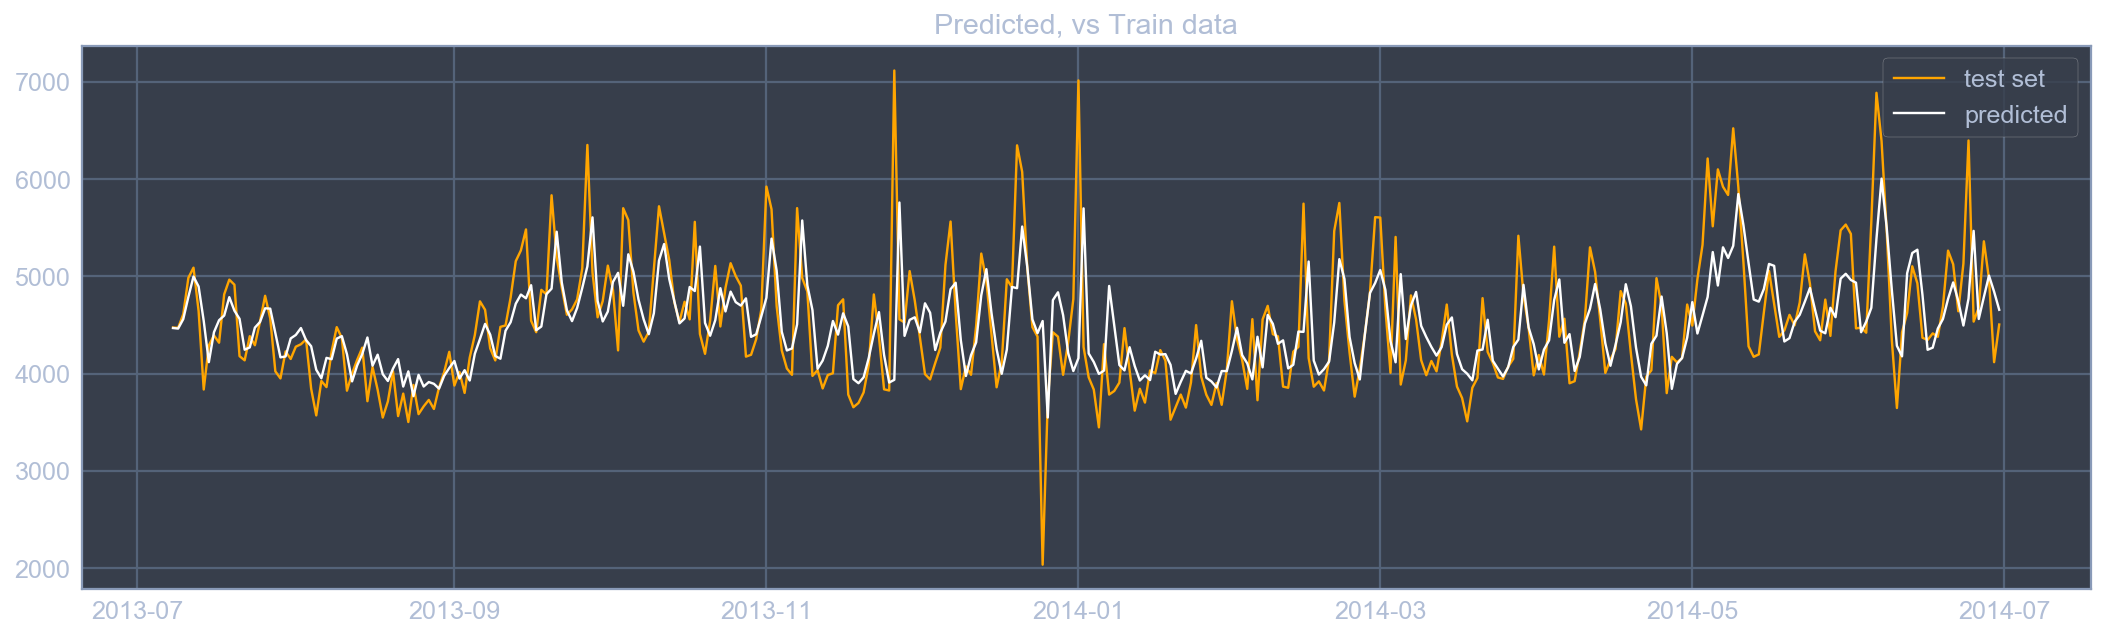

In [9]:
def previous_k_values(df, k):
    result_df = df.copy()
    for i in range(1, k+1):
        result_df['d-%d'%i] = df['n_rides'].shift(i)
    return result_df.dropna()

def train_regression_for_lag(x_train, k):
    # First generate col names from d-1 to d-k
    col_names = ['d-%d' % (i+1) for i in range(k)]
    
    model = linear_model.LinearRegression()
    model.fit(np.array(x_train[col_names]), np.array(x_train['n_rides']).reshape(-1,1))
        
    # Make predictions using the testing set
    predictions = model.predict(np.array(x_train[col_names]))
    
    return model, predictions

X_train = previous_k_values(df_rides, 7)

model, X_train['predictions'] = train_regression_for_lag(X_train, 7)

# Plot the series
plt.figure(figsize=(18,5))
plt.title('Predicted, vs Train data')
plt.plot(X_train.index, X_train['n_rides'], c='orange', label='test set')
plt.plot(X_train.index, X_train['predictions'], c='white', label='predicted')

plt.legend()
plt.show()

## 2.2. Calculate and plot the histogram and time plot of the relative error 
https://en.wikipedia.org/wiki/Approximation_error

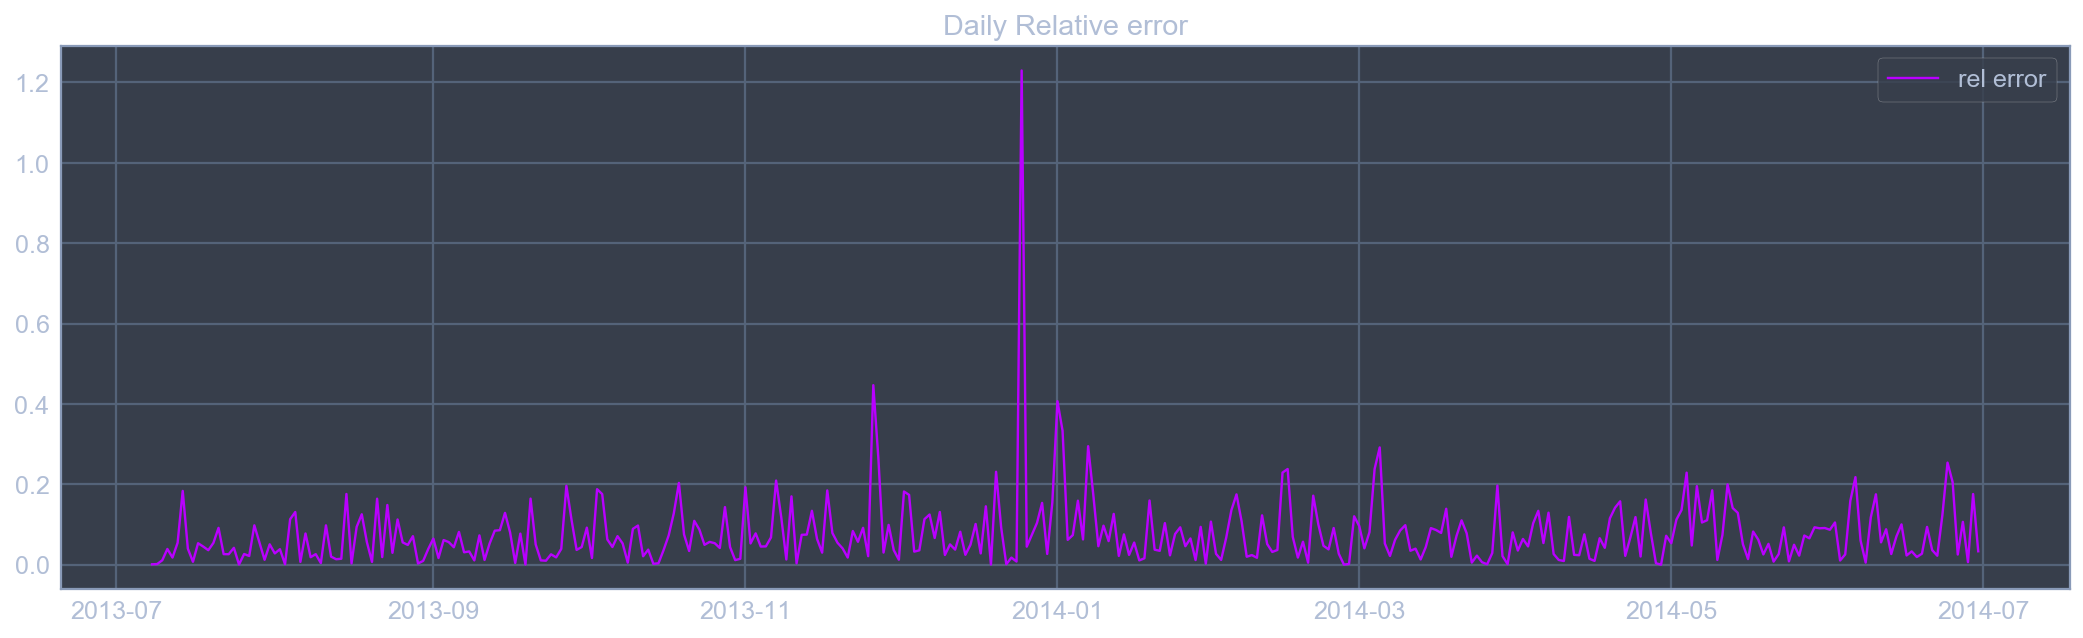

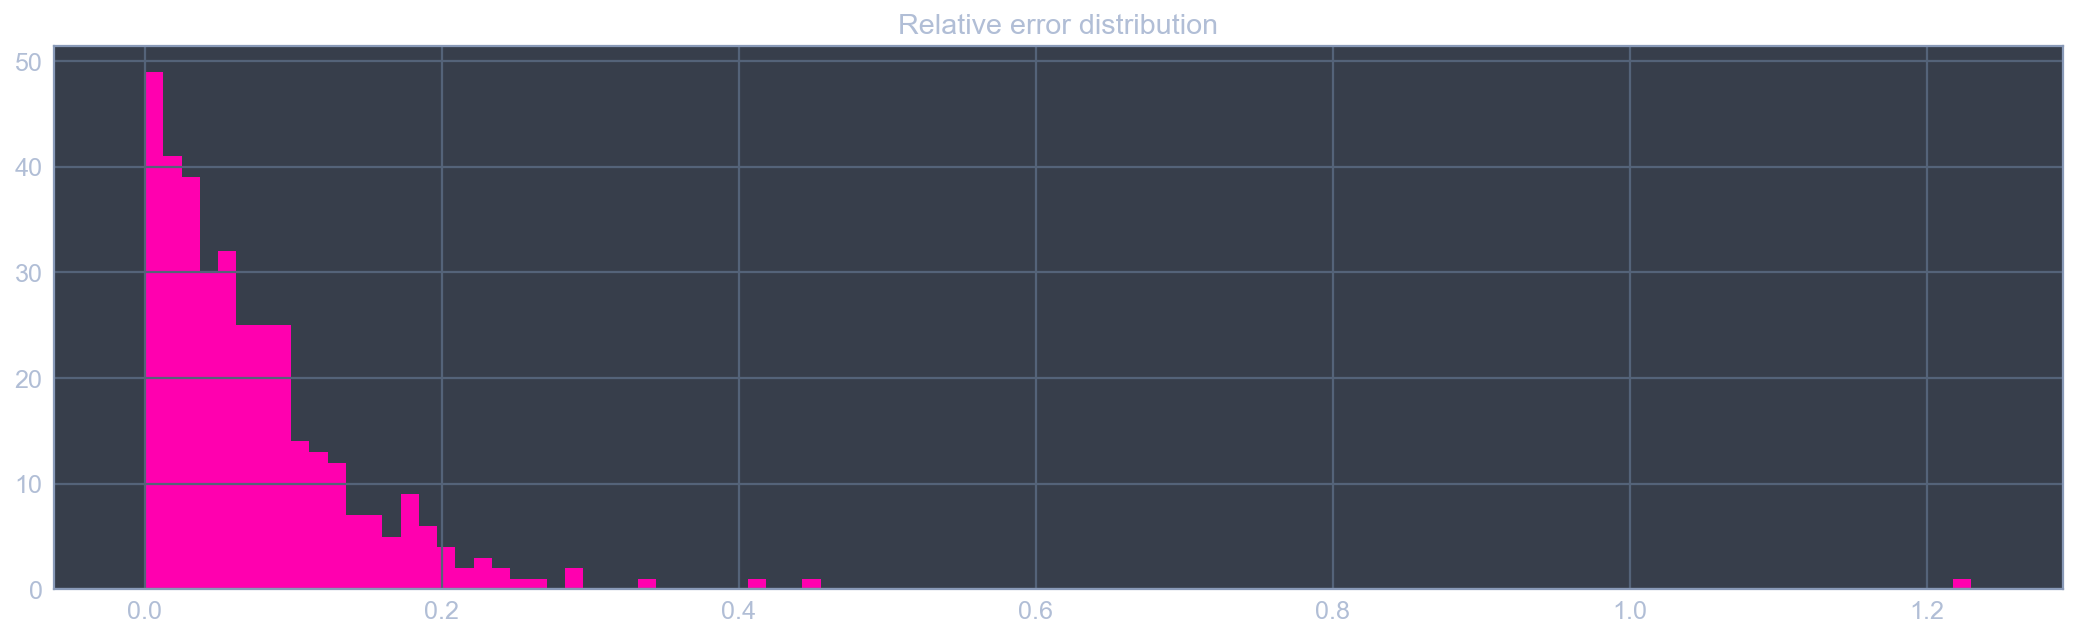

In [10]:
X_train['rel_error'] = np.abs(X_train['n_rides']-X_train['predictions'])/X_train['n_rides']
# Plot the series
plt.figure(figsize=(18,5))
plt.title('Daily Relative error')
plt.plot(X_train.index, X_train['rel_error'], c=plt.cm.get_cmap('hsv', 11)(np.random.randint(11)), label='rel error')
plt.legend()
plt.show()

plt.figure(figsize=(18,5))
plt.title('Relative error distribution')
plt.hist(X_train['rel_error'], bins=100,  color=plt.cm.get_cmap('hsv', 11)(np.random.randint(11)))
plt.show()

## 2.3. Calculate and plot the histogram and time plot of the absolute error 

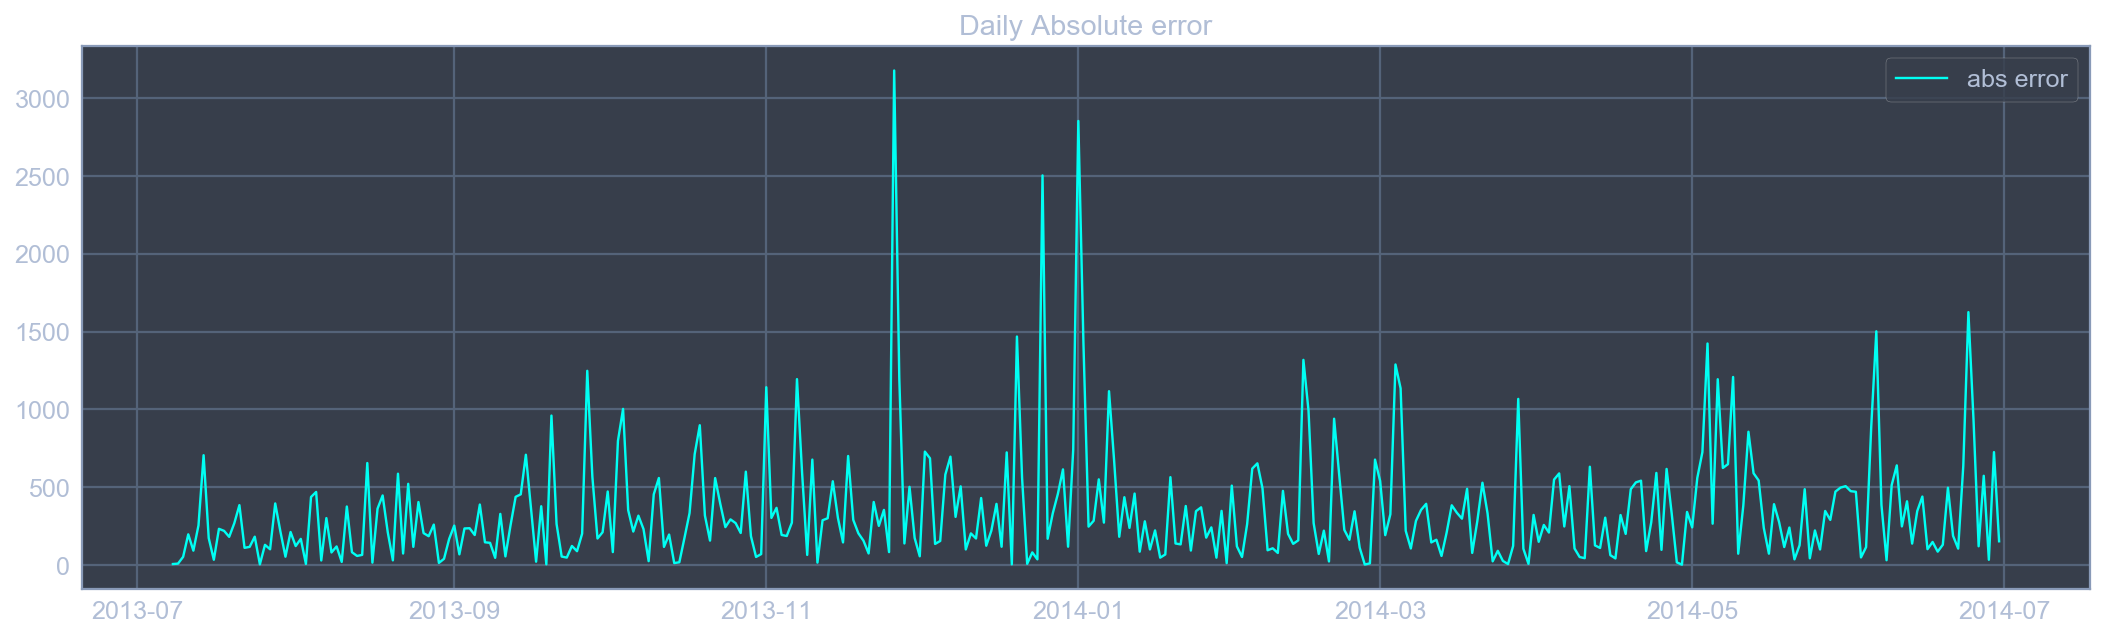

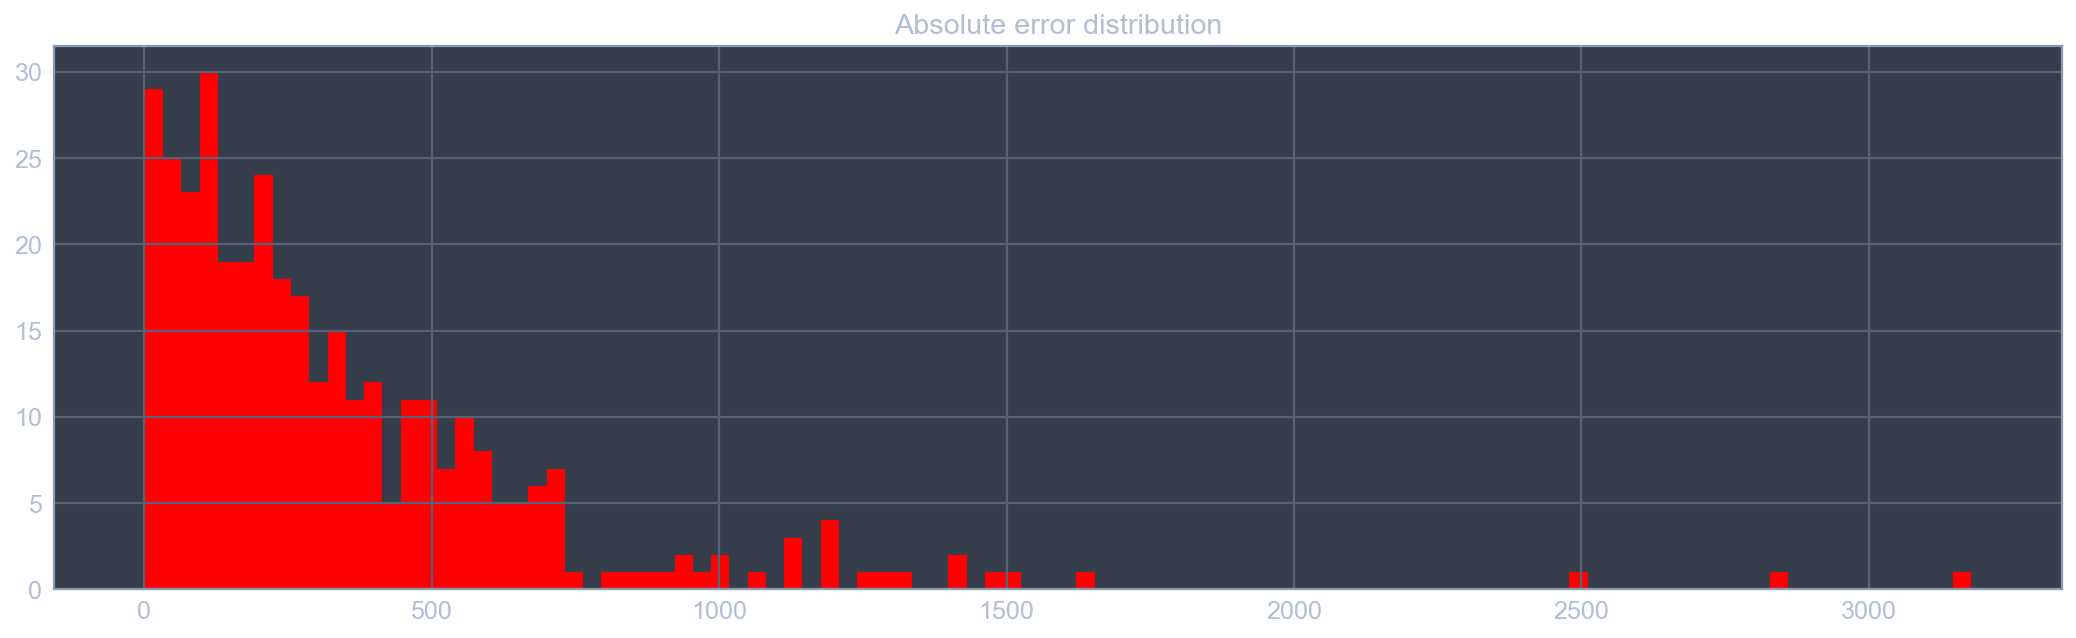

In [11]:
X_train['abs_error'] = np.abs(X_train['n_rides']-X_train['predictions'])
# Plot the series
plt.figure(figsize=(18,5))
plt.title('Daily Absolute error')
plt.plot(X_train.index, X_train['abs_error'], c=plt.cm.get_cmap('hsv', 11)(np.random.randint(11)), label='abs error')
plt.legend()
plt.show()

plt.figure(figsize=(18,5))
plt.title('Absolute error distribution')
plt.hist(X_train['abs_error'], bins=100,  color=plt.cm.get_cmap('hsv', 11)(np.random.randint(11)))
plt.show()

# 2.4 Find anomalies

### 2.4.1 Use the iterative gaussian process to find anomalies in the relative error

try with threshold of 3

plot and visualize anomalies

Series <rel_error>


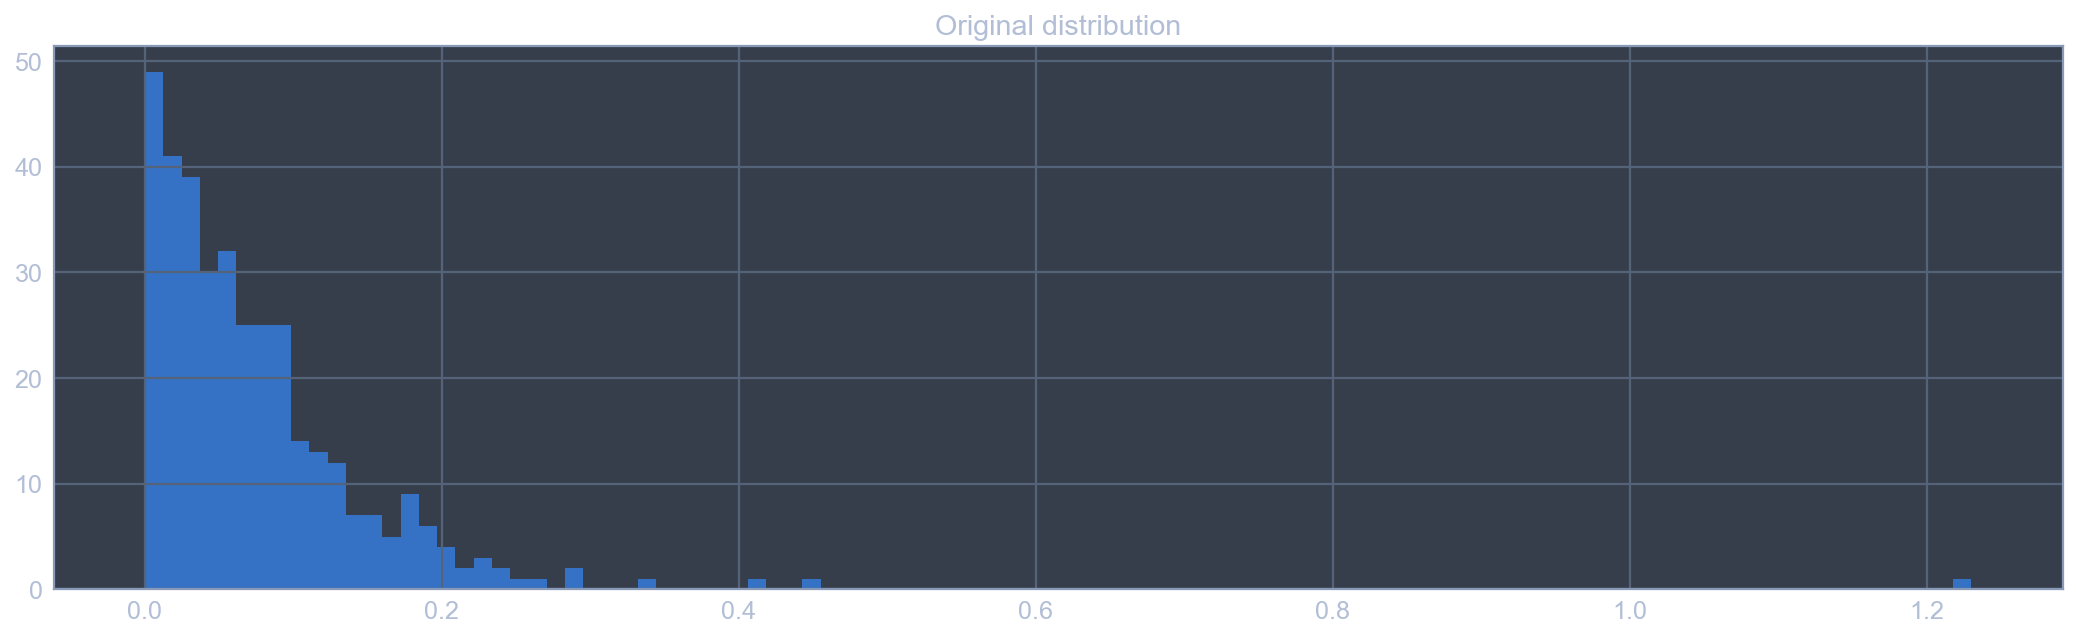

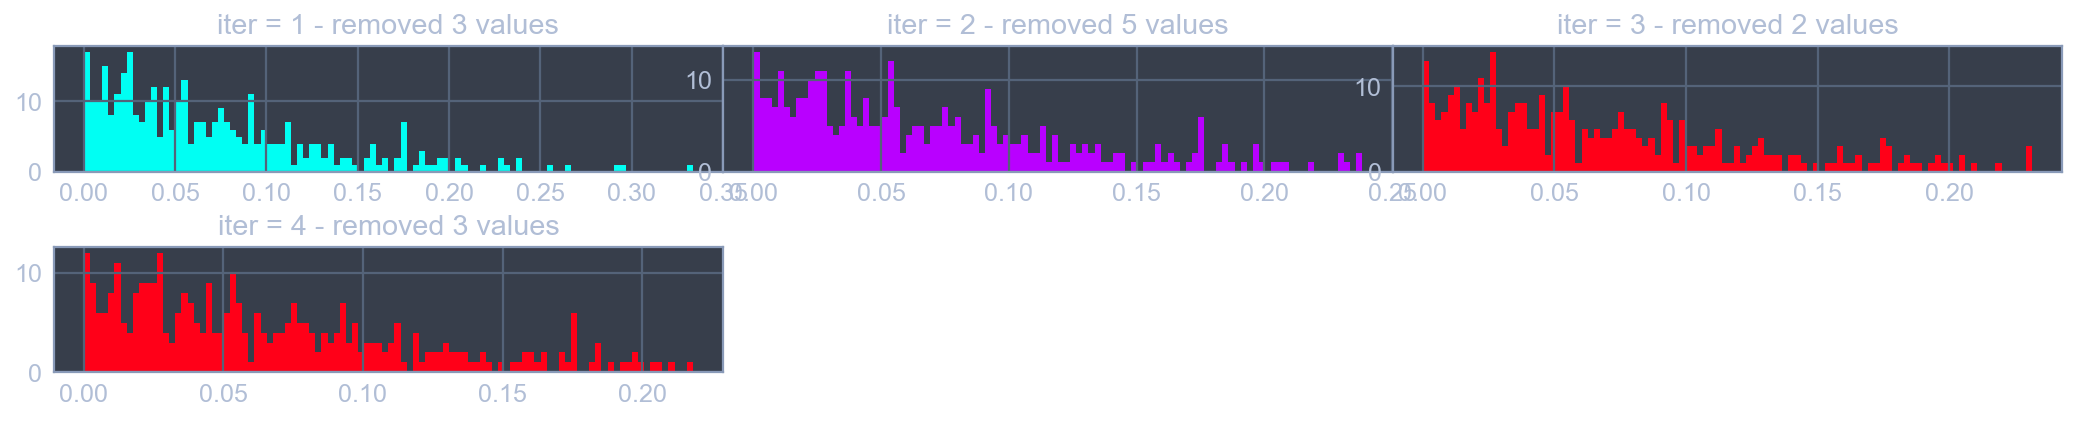

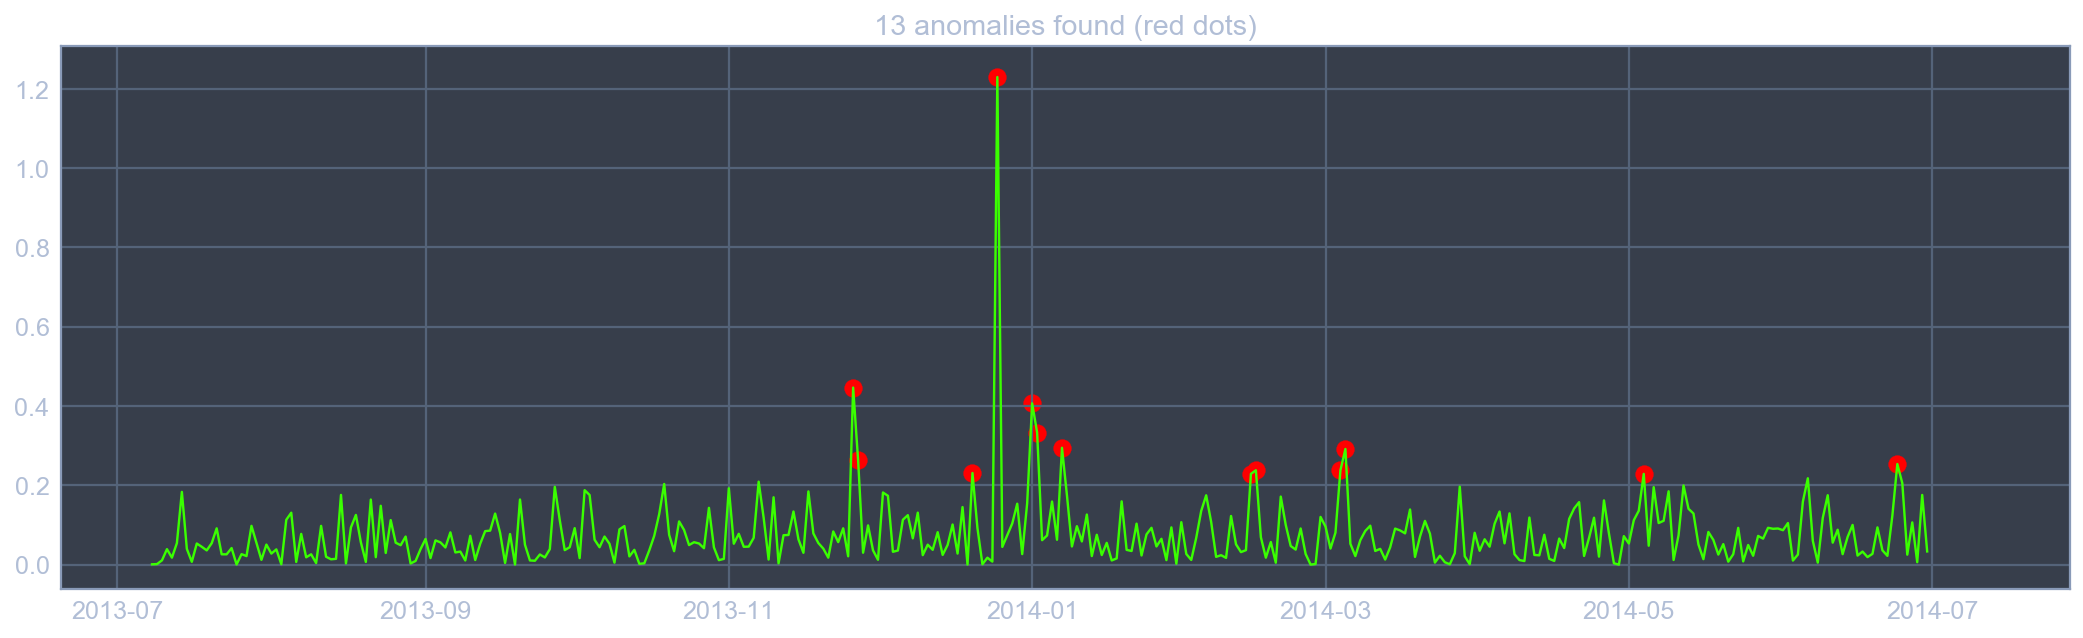

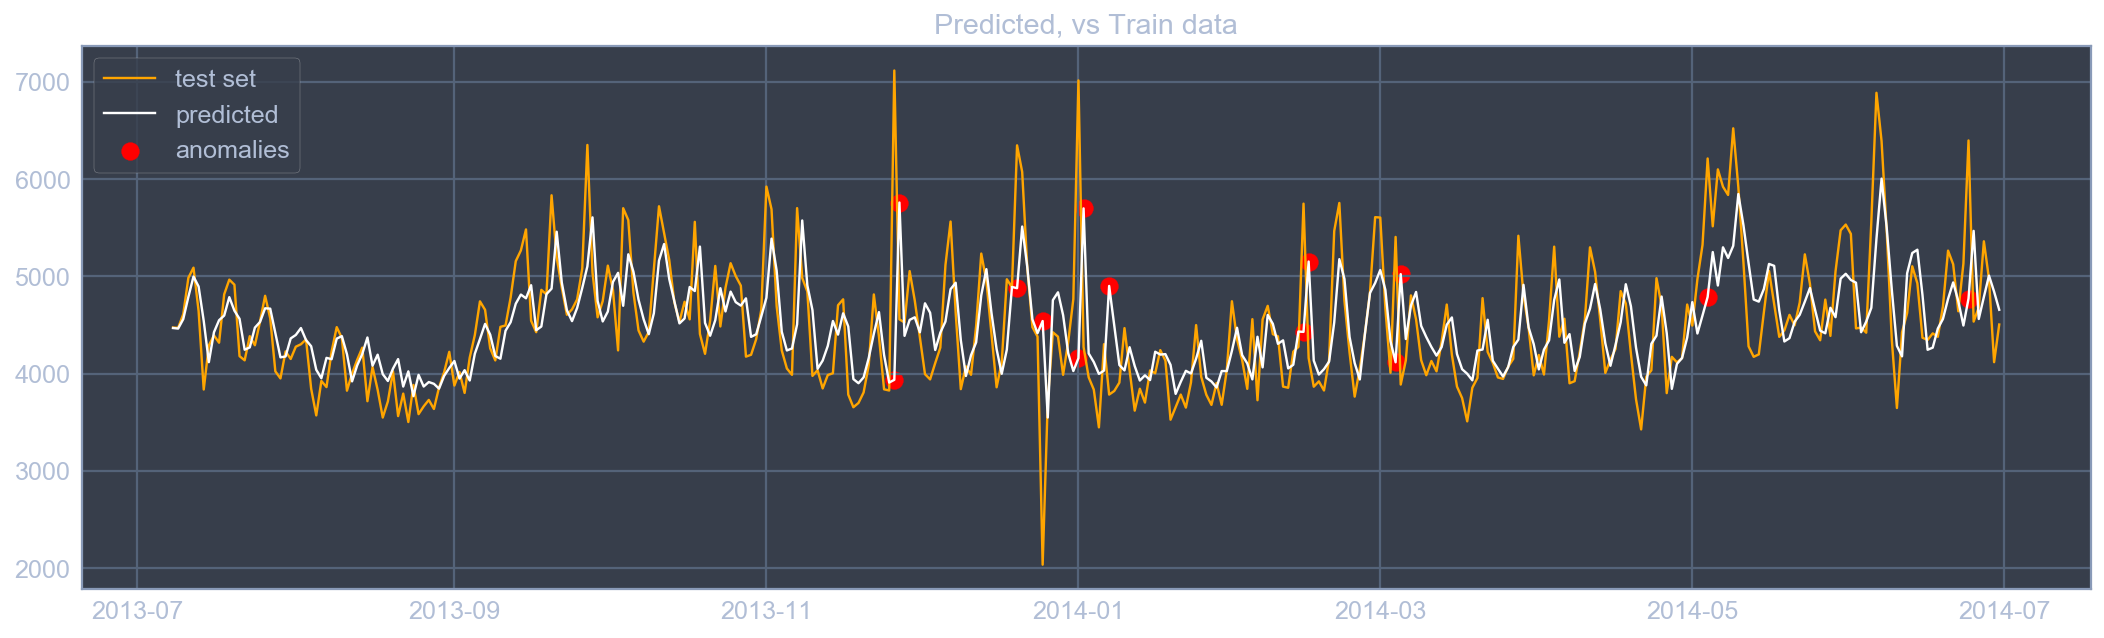

In [12]:
rel_anomalies = gaussian_anomaly_detection(X_train['rel_error'], 3).sort_index()

# Plot the series
plt.figure(figsize=(18,5))
plt.title('Predicted, vs Train data')
plt.plot(X_train.index, X_train['n_rides'], c='orange', label='test set')
plt.plot(X_train.index, X_train['predictions'], c='white', label='predicted')
plt.scatter(rel_anomalies.index, X_train[X_train.index.isin(rel_anomalies.index)].predictions.values, s=80, c='red', label='anomalies')

plt.legend()
plt.show()

### 2.4.2 Use the iterative gaussian process to find anomalies in the absolute error

try with threshold of 3

plot the original series and visualize anomalies

Series <abs_error>


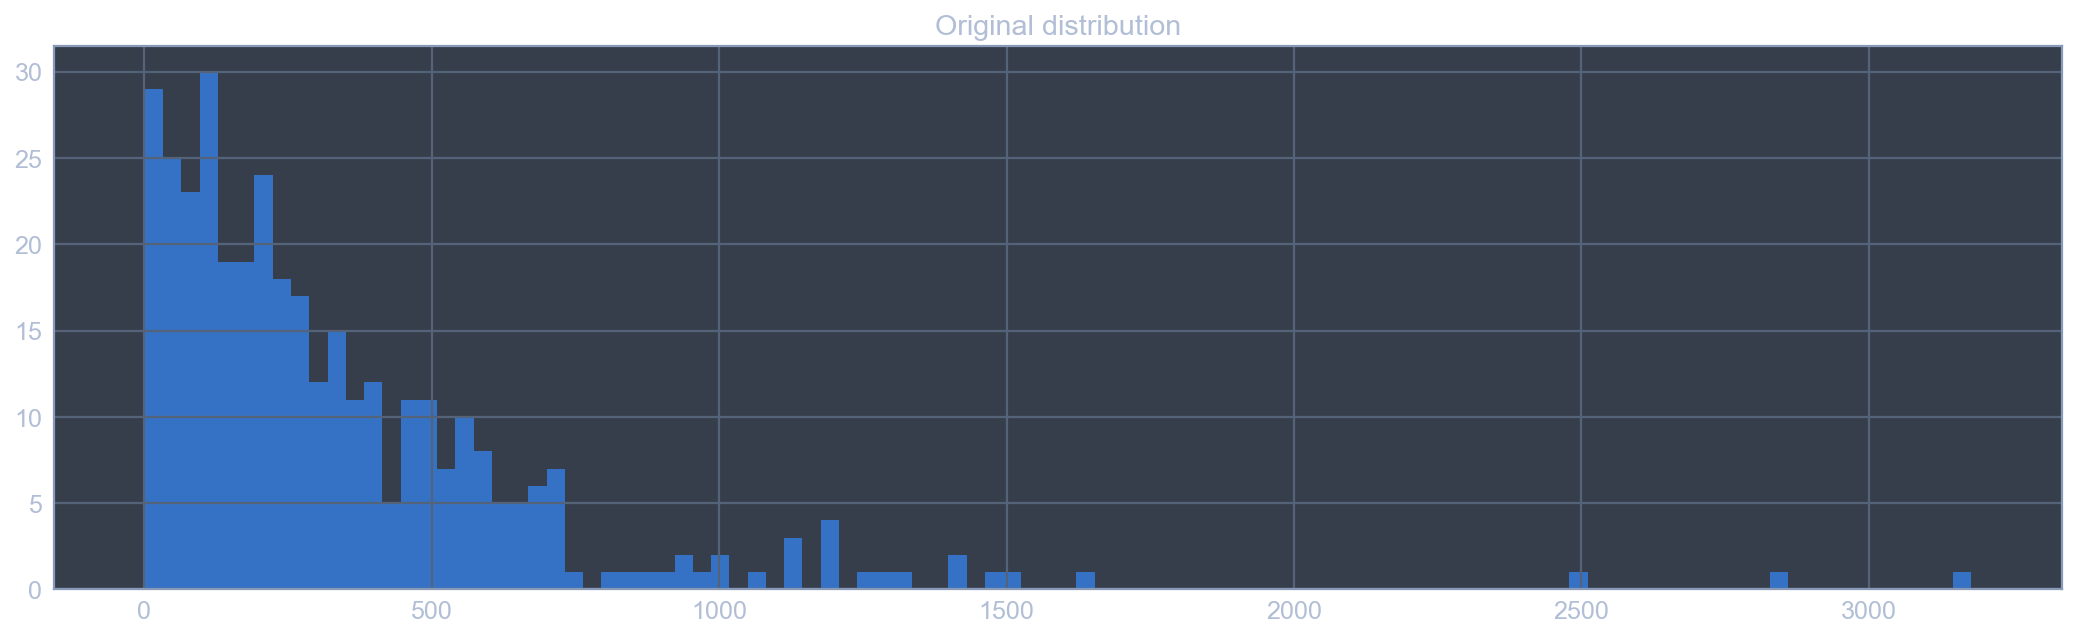

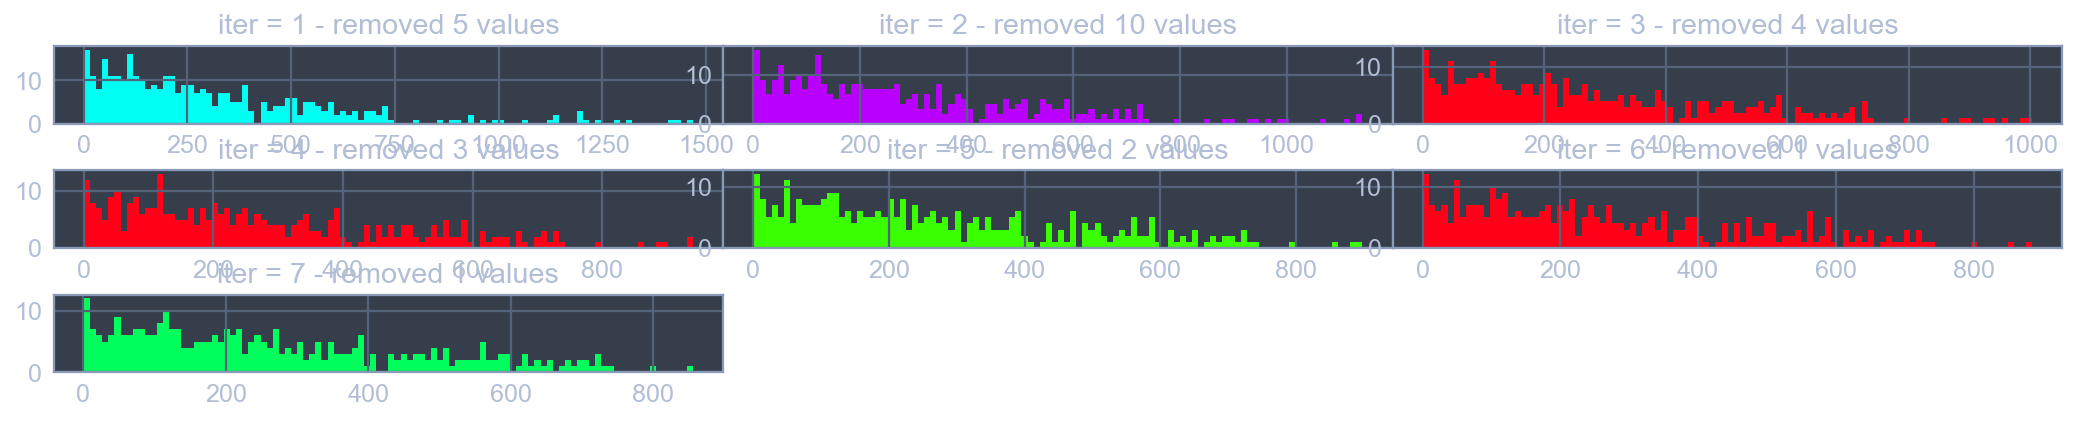

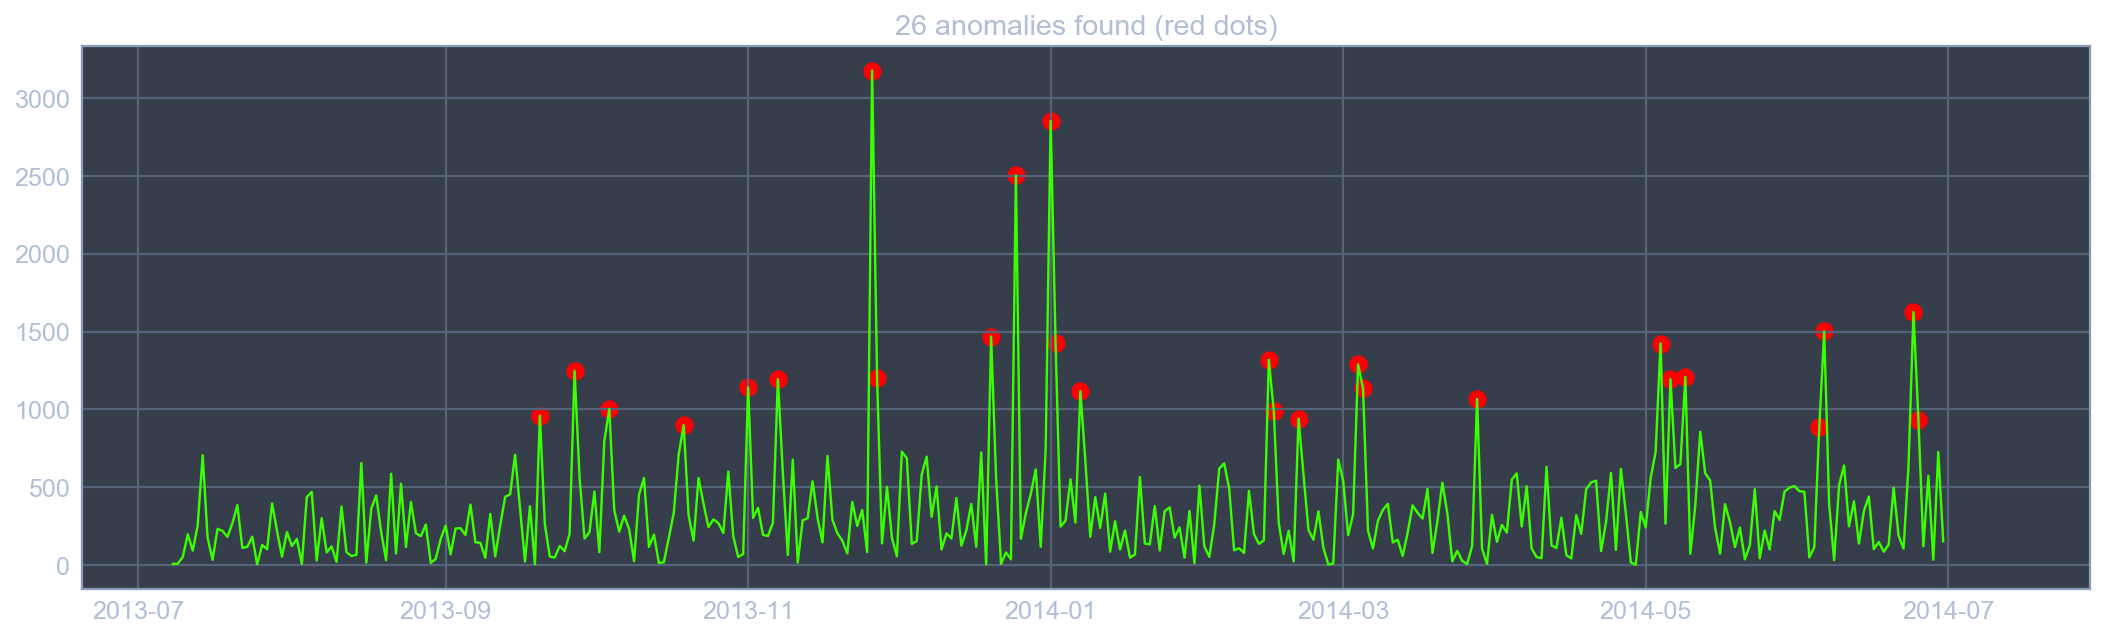

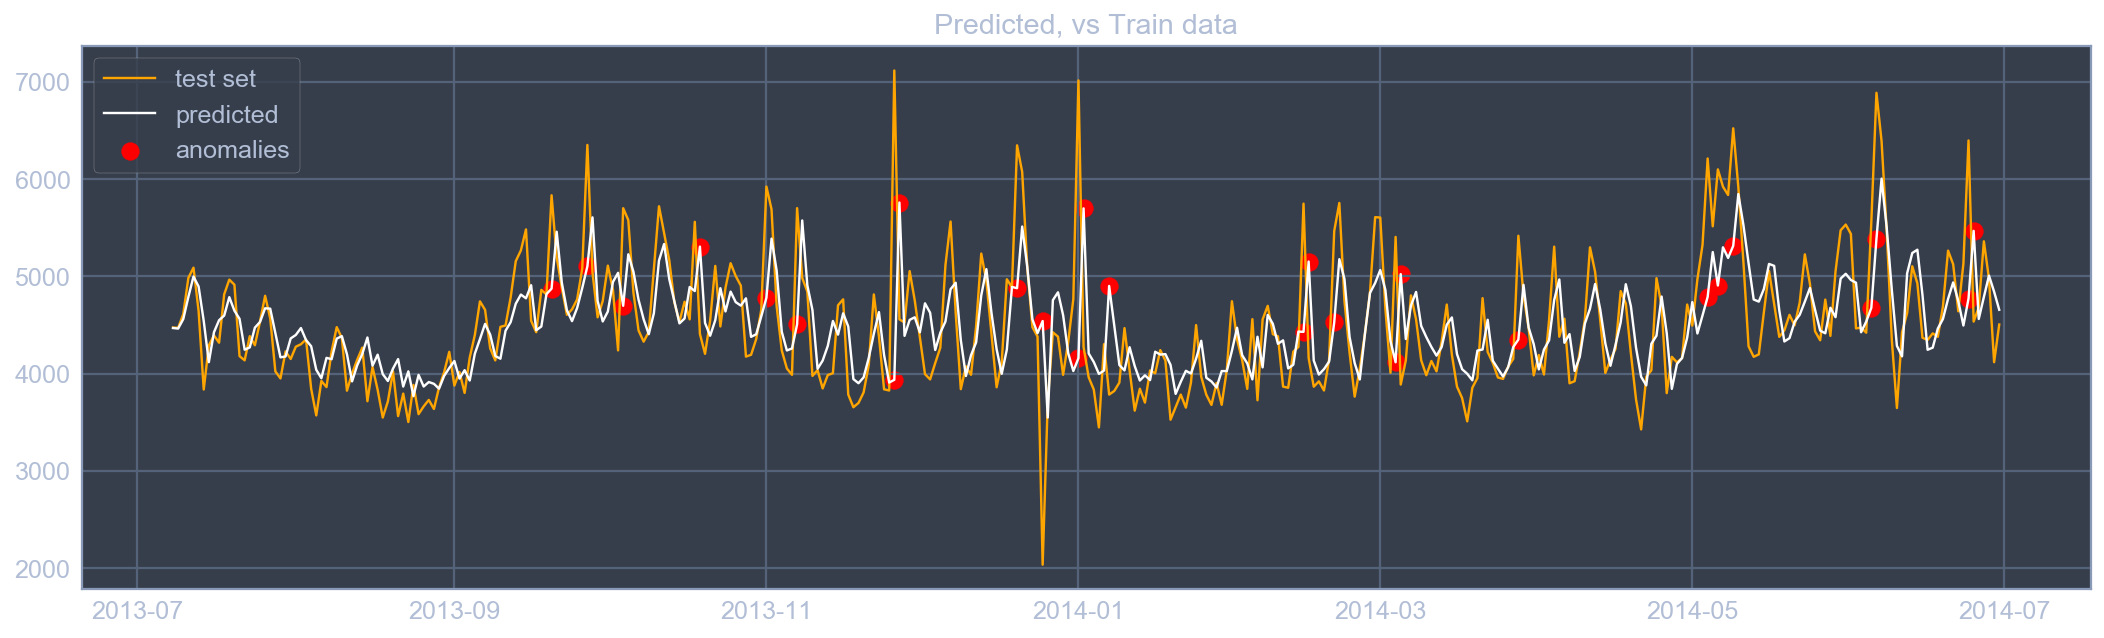

In [13]:
abs_anomalies = gaussian_anomaly_detection(X_train['abs_error'], 3).sort_index()

# Plot the series
plt.figure(figsize=(18,5))
plt.title('Predicted, vs Train data')
plt.plot(X_train.index, X_train['n_rides'], c='orange', label='test set')
plt.plot(X_train.index, X_train['predictions'], c='white', label='predicted')
plt.scatter(abs_anomalies.index, X_train[X_train.index.isin(abs_anomalies.index)].predictions.values, s=80, c='red', label='anomalies')

plt.legend()
plt.show()

### What is the difference between this method (model based) and the one performing on the values directly line in the first question?

Using the gaussian anomaly in the first question was able to identify the outliers in terms of value, and could be summed up as setting a tunnel of acceptable values and flagging any value outside this tunnel as an anomaly.

In the second question, the anomaly detection is a more complex process: we first build a prediction model, and then we flag the values that differ from the model prediction by a certain threshold. This explains why in the question 2 the red dots that represent the anomalies can be located at any position on the y-axis.

# 3. Density

## 3.1. Get Data

Form a data frame with the 
1. number of working taxis per day 
1. number of trips per day

plot a scatter plot of the two where each point is a day 

/Users/jeremybensoussan/anaconda3/envs/ITC/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


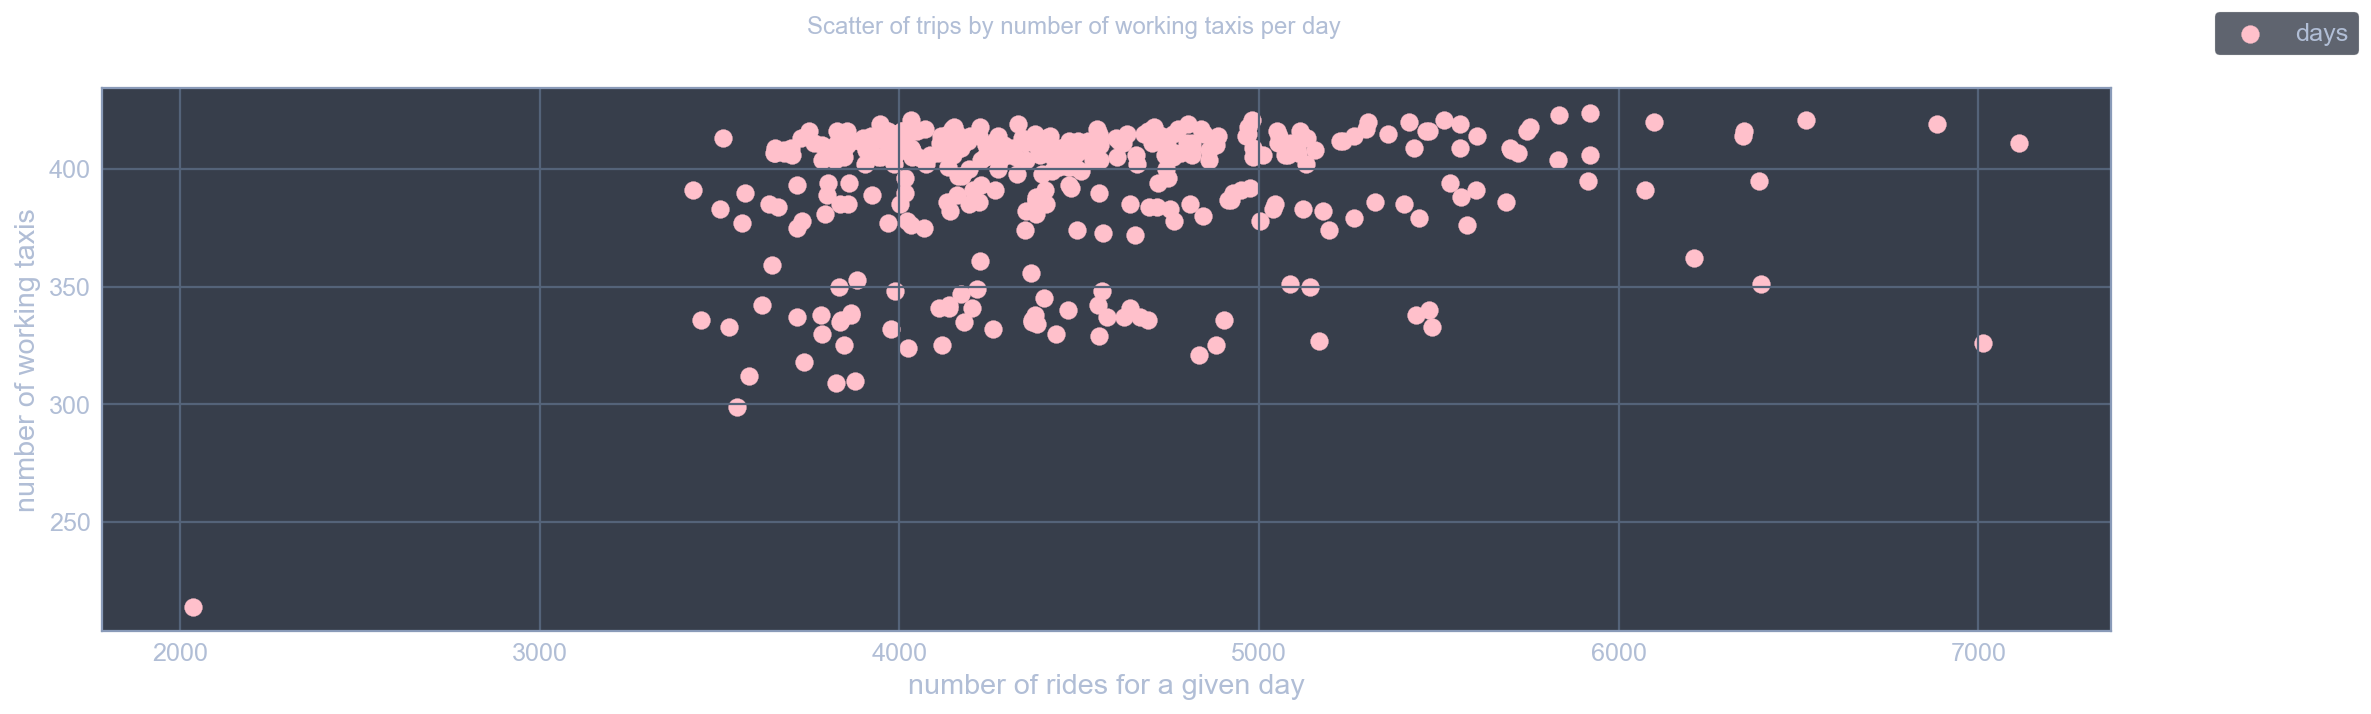

In [14]:
# Plot the series
fig, ax = plt.subplots(figsize=(18,5))
fig.suptitle('Scatter of trips by number of working taxis per day')
ax.scatter(df_rides.n_rides, df_rides.n_taxis, s=80, c='pink', label='days')
ax.set_xlabel('number of rides for a given day')
ax.set_ylabel('number of working taxis')
fig.legend()
fig.show()

## 3.2 Normalize data along each axis

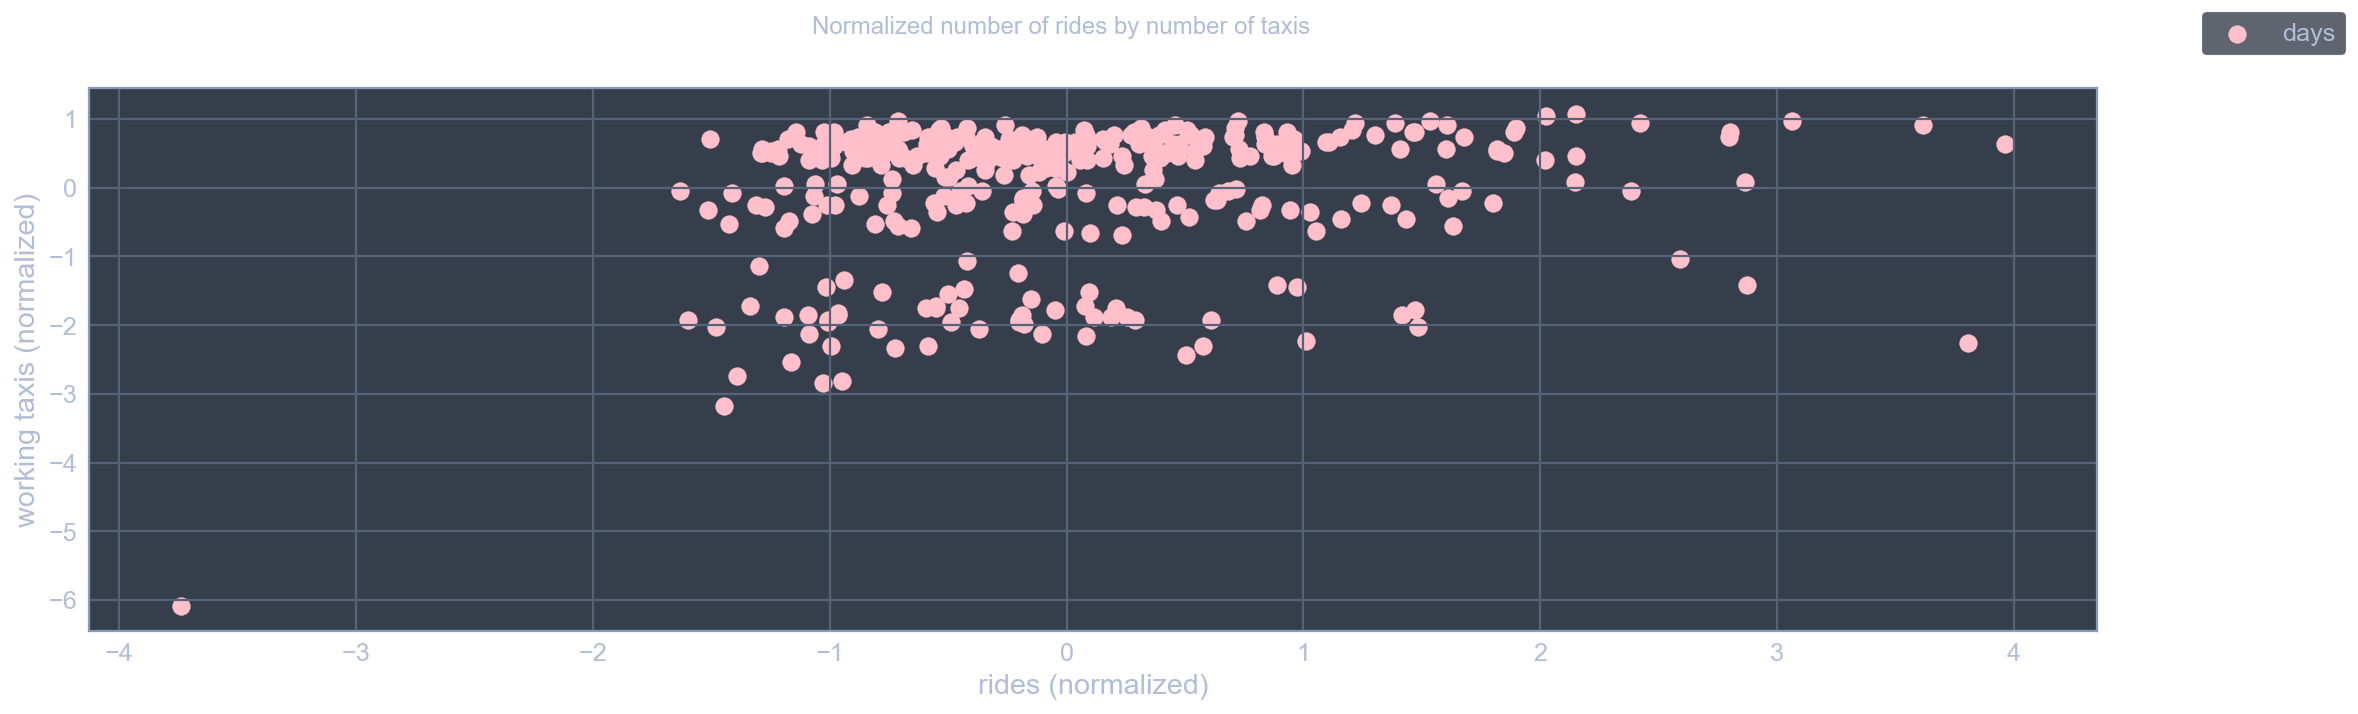

In [15]:
df_norm = pd.DataFrame()
df_norm['n_rides'] = (df_rides.n_rides - df_rides.n_rides.mean()) /  df_rides.n_rides.std()
df_norm['n_taxis'] = (df_rides.n_taxis - df_rides.n_taxis.mean()) / df_rides.n_taxis.std()

# Plot the series
fig, ax = plt.subplots(figsize=(18,5))
fig.suptitle('Normalized number of rides by number of taxis')
ax.scatter(df_norm.n_rides, df_norm.n_taxis, s=80, c='pink', label='days')
ax.set_xlabel('rides (normalized)')
ax.set_ylabel('working taxis (normalized)')
fig.legend()
fig.show()


## 3.3 Build a nearest neighbours index

use sklearn.neighbors.NearestNeighbors

plot the histogram of average distance to the 50 nearest neighbours for each day. This is the density score.

build the index over the normalized values

(365, 50)


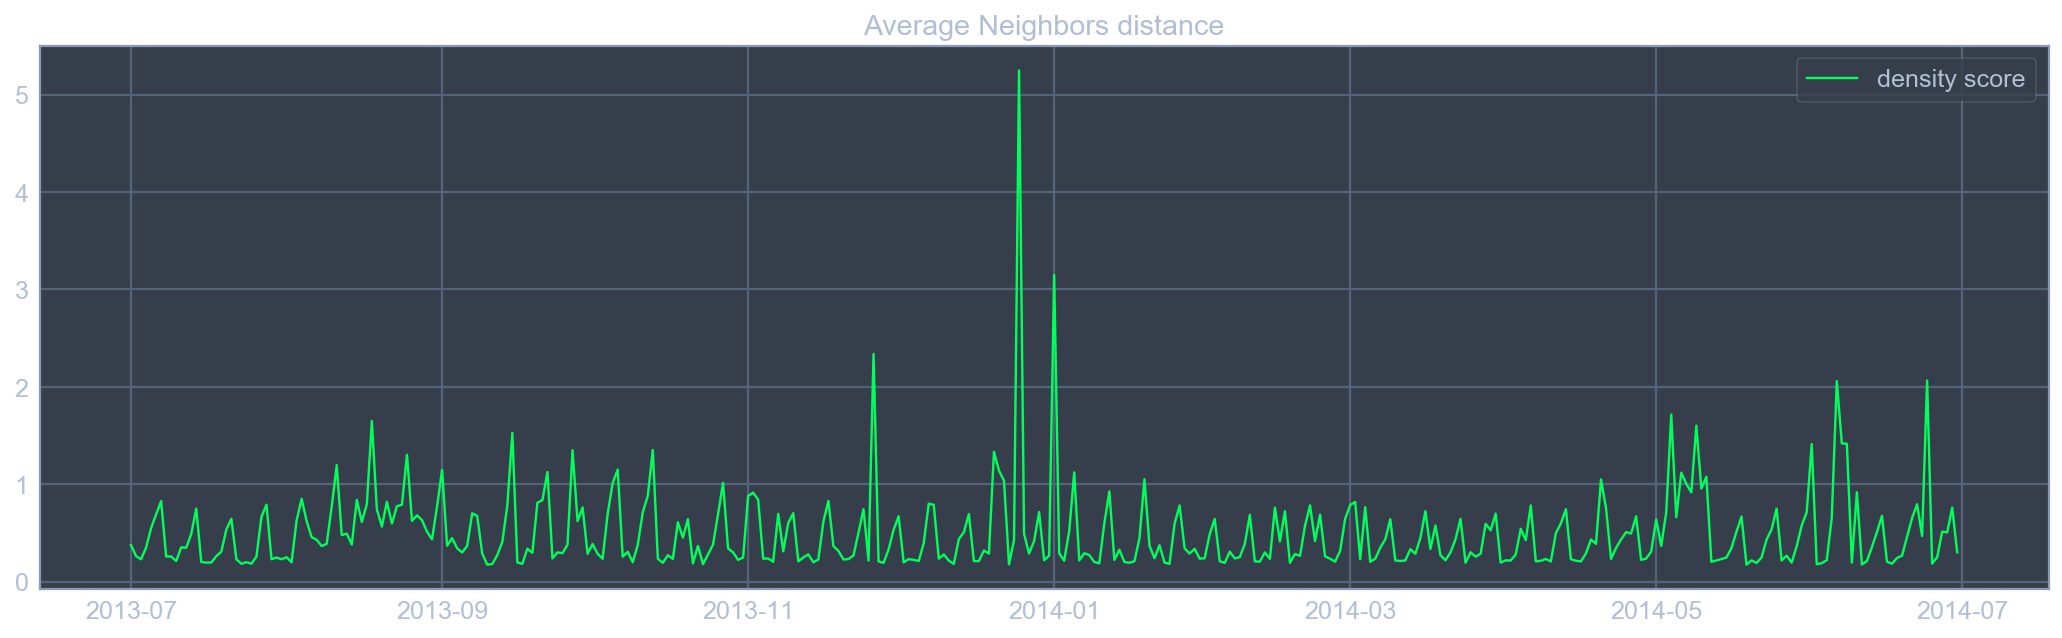

In [16]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(50)
neighbors.fit(df_norm.values)
# first value is the point itself, so requesting 51 neighbors and removing the first
distances = neighbors.kneighbors(df_norm.values, 51)[0][:,1:]
print(distances.shape)

df_norm['avg_dist'] = distances.mean(axis=1)

# Plot the series
plt.figure(figsize=(18,5))
plt.title('Average Neighbors distance')
plt.plot(df_norm.index, df_norm['avg_dist'], c=plt.cm.get_cmap('hsv', 11)(4), label='density score')
plt.legend()
plt.show()

## 3.4 Visualize all the days with density score larger than 1 as outliers

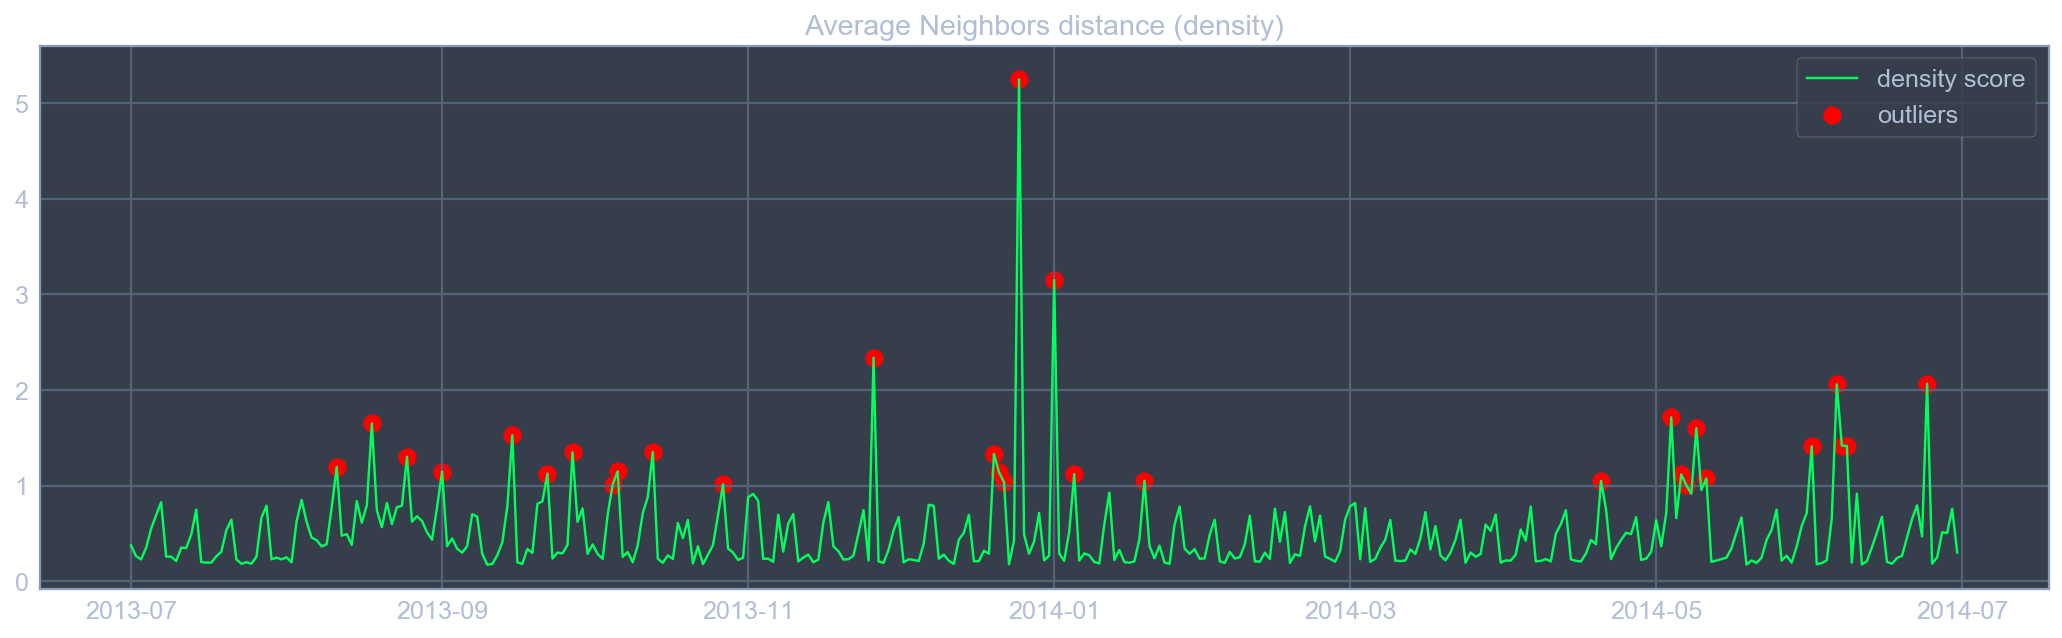

/Users/jeremybensoussan/anaconda3/envs/ITC/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/jeremybensoussan/anaconda3/envs/ITC/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


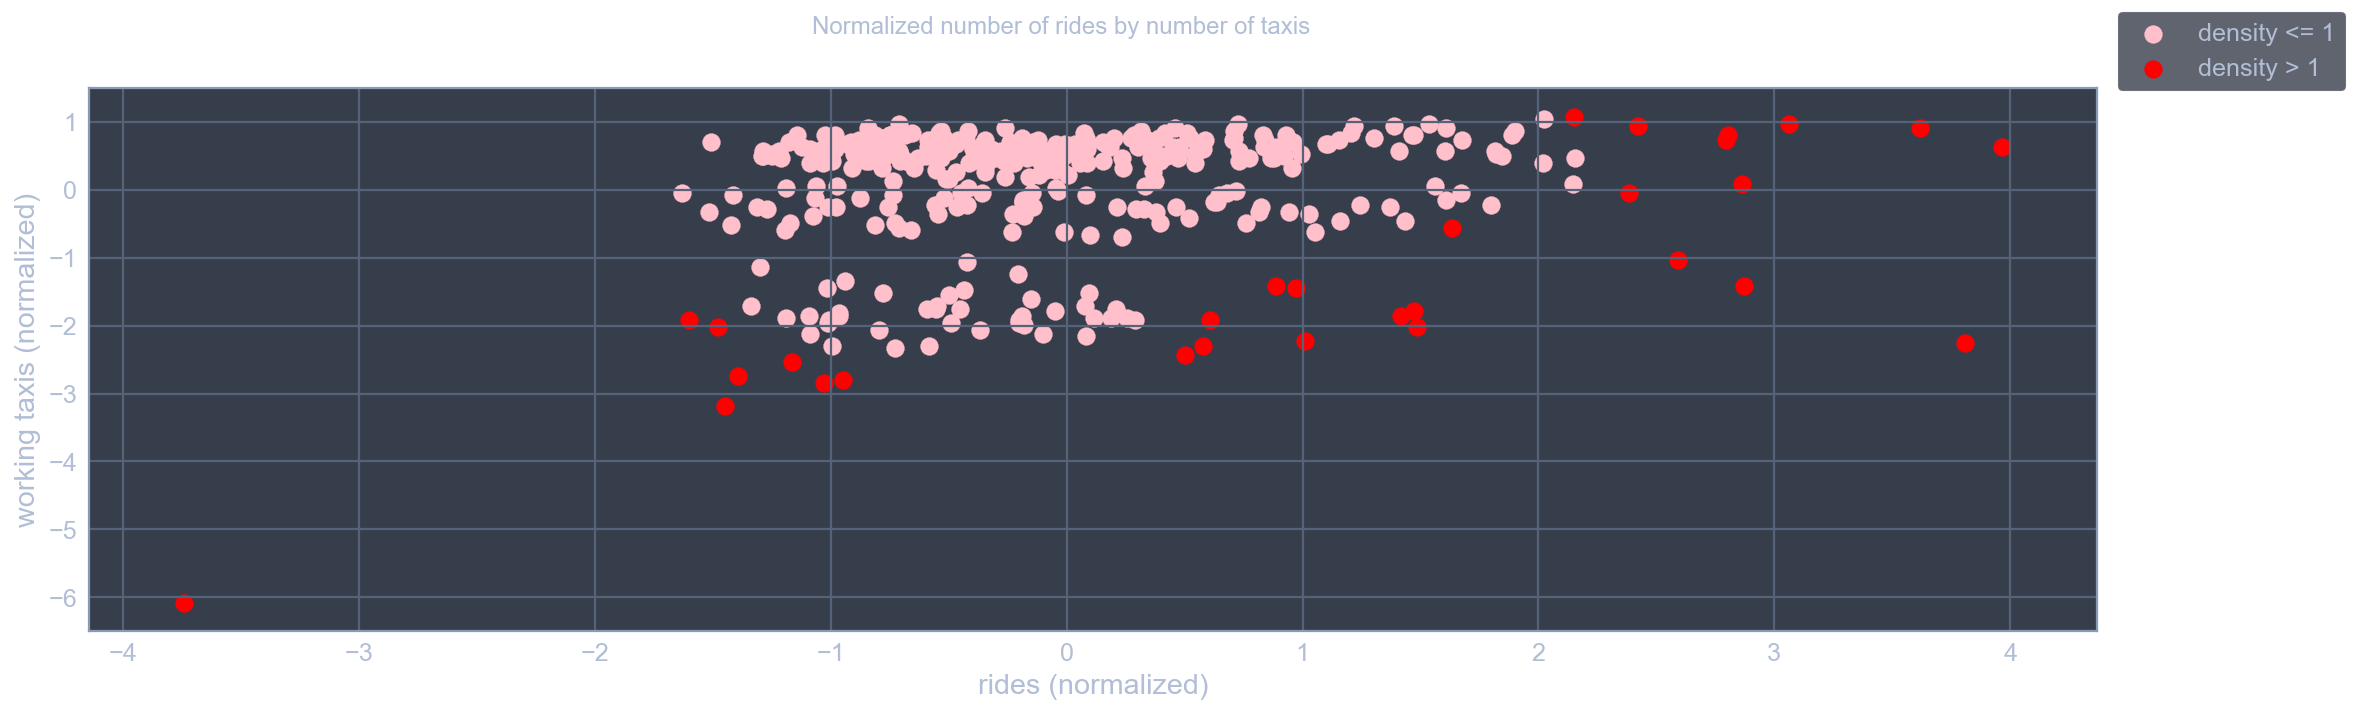

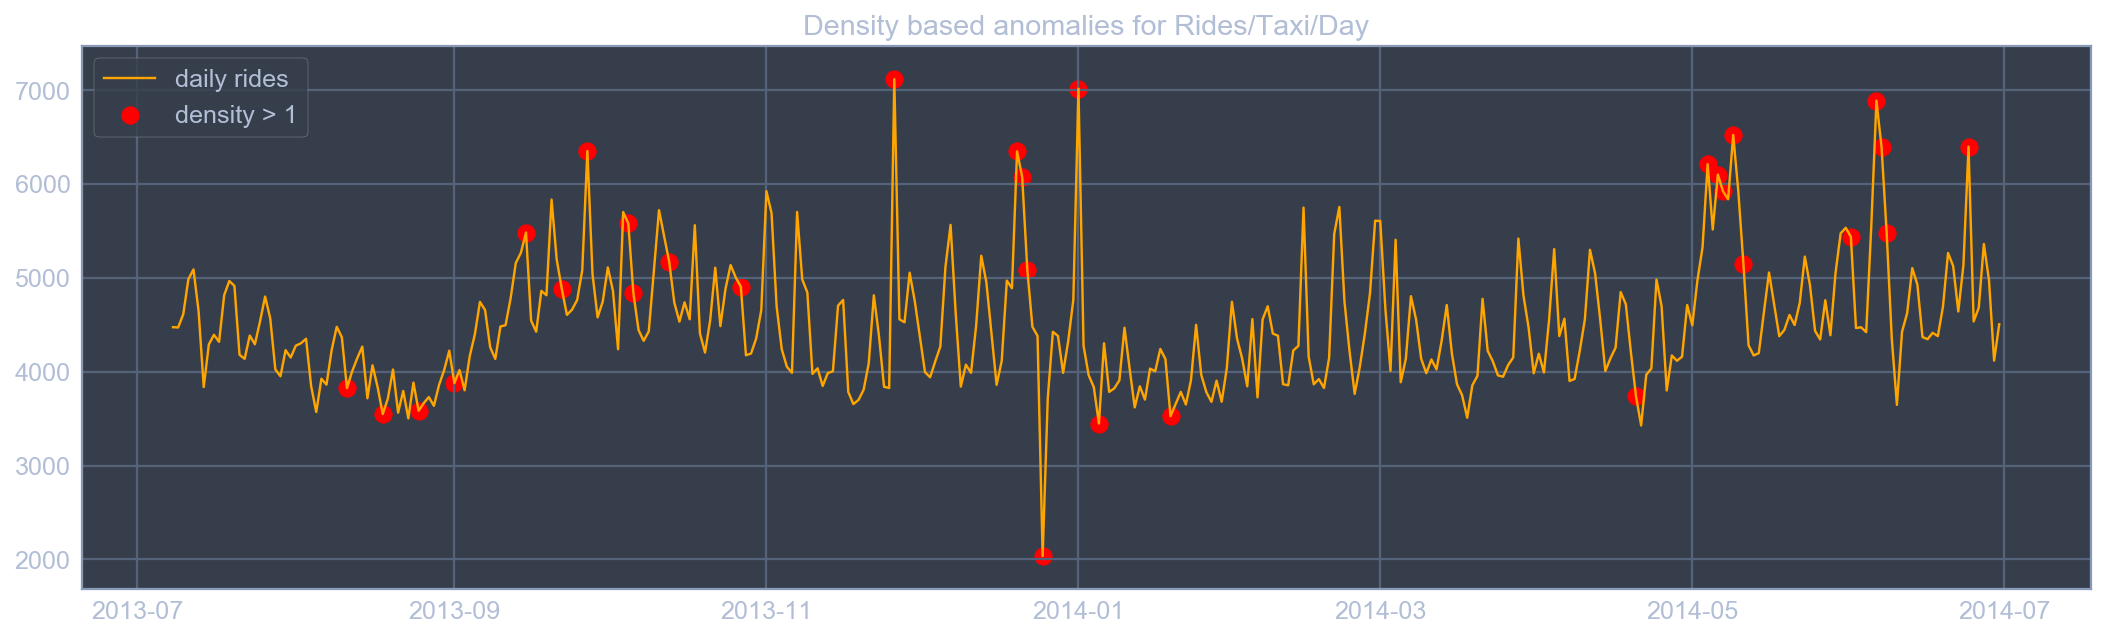

In [17]:
df_norm['anomalies'] = df_norm['avg_dist'] > 1

# Plot the series
plt.figure(figsize=(18,5))
plt.title('Average Neighbors distance (density)')
plt.plot(df_norm.index, df_norm['avg_dist'], c=plt.cm.get_cmap('hsv', 11)(4), label='density score')
plt.scatter(df_norm[df_norm['anomalies']].index, df_norm[df_norm['anomalies']].avg_dist.values, s=80, c='red', label='outliers')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(18,5))
fig.suptitle('Normalized number of rides by number of taxis')
ax.scatter(df_norm[~df_norm['anomalies']].n_rides, df_norm[~df_norm['anomalies']].n_taxis, s=80, c='pink', label='density <= 1')
ax.scatter(df_norm[df_norm['anomalies']].n_rides, df_norm[df_norm['anomalies']].n_taxis, s=80, c='red', label='density > 1')
ax.set_xlabel('rides (normalized)')
ax.set_ylabel('working taxis (normalized)')
fig.legend()
fig.show()

# Plot the series
plt.figure(figsize=(18,5))
plt.title('Density based anomalies for Rides/Taxi/Day')
plt.plot(X_train.index, X_train['n_rides'], c='orange', label='daily rides')
plt.scatter(X_train[df_norm['avg_dist'] > 1].index, X_train[df_norm['avg_dist'] > 1].n_rides.values, s=80, c='red', label='density > 1')
plt.legend()
plt.show()


## 3.5 Calcuate the LOF, plot its histogram and visualize anomalies with LOF > 2

In [43]:
from sklearn.neighbors import LocalOutlierFactor

# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=50, contamination=0.5)
clf.fit(df_norm.drop(['avg_dist', 'anomalies'], axis=1).values)

df_norm['skLOF'] = np.abs(clf.negative_outlier_factor_)

In [54]:
df_norm['LOF'] = df_norm['avg_dist']/((df_norm['avg_dist'].sum()-df_norm['avg_dist'])/(df_norm.shape[0]-1))
# df_norm['LOF'] = df_norm['avg_dist']/df_norm['avg_dist'].mean()
df_norm

n_rides   n_taxis  avg_dist  anomalies     skLOF       LOF
date                                                                   
2013-07-01 -0.044600  0.021946  0.376572      False  1.246963  0.746155
2013-07-02 -0.021843  0.294635  0.263337      False  1.054285  0.521466
2013-07-03  0.057049  0.396893  0.230272      False  0.992426  0.455908
2013-07-04  0.773142  0.465065  0.349759      False  1.090074  0.692926
2013-07-05  1.410344  0.567324  0.550851      False  1.242799  1.092517
2013-07-06  1.028023 -0.353002  0.691789      False  1.274390  1.373097
2013-07-07  0.081323 -2.159566  0.826730      False  1.044178  1.642144
2013-07-08 -0.043083  0.294635  0.259705      False  1.055158  0.514263
2013-07-09 -0.047634  0.294635  0.259115      False  1.055980  0.513093
2013-07-10  0.166283  0.669582  0.212935      False  0.998958  0.421544
2013-07-11  0.732179  0.430979  0.352970      False  1.079423  0.699300
2013-07-12  0.889963  0.635496  0.348981      False  1.136281  0.691383
2013-07-13  0.211798 -0.250743  0.489565      False  1.206701  0.970643
2013-07-14 -1.009505 -1.955049  0.750229      False  1.055050  1.489567
2013-07-15 -0.322238  0.567324  0.201810      False  0.973750  0.399495
2013-07-16 -0.165972  0.465065  0.196462      False  0.989494  0.388897
2013-07-17 -0.279758  0.567324  0.197366      False  0.973014  0.390688
2013-07-18  0.474264  0.635496  0.262935      False  1.048778  0.520669
2013-07-19  0.703353  0.737754  0.309730      False  1.073337  0.613489
2013-07-20  0.624462 -0.182571  0.535690      False  1.217535  1.062359
2013-07-21 -0.489124 -1.955049  0.645879      False  1.062407  1.281653
2013-07-22 -0.554361  0.465065  0.230570      False  0.980030  0.456499
2013-07-23 -0.178109  0.567324  0.184479      False  0.977979  0.365153
2013-07-24 -0.319204  0.601410  0.200773      False  0.974800  0.397441
2013-07-25  0.047946  0.601410  0.185659      False  0.975676  0.367491
2013-07-26  0.451507  0.635496  0.257993      False  1.051799  0.510870
2013-07-27  0.099529 -0.659777  0.667077      False  1.125853  1.323869
2013-07-28 -0.725799 -2.329997  0.790555      False  1.041186  1.569980
2013-07-29 -0.836551  0.430979  0.230827      False  0.994762  0.457009
2013-07-30 -0.414784  0.396893  0.248627      False  1.011571  0.492298
...              ...       ...       ...        ...       ...       ...
2014-06-01  1.416413 -1.852791  1.412272       True  1.551130  2.814205
2014-06-02 -0.056737  0.499152  0.179346      False  0.975244  0.354984
2014-06-03 -0.044600  0.669582  0.191048      False  0.973847  0.378169
2014-06-04 -0.123492  0.737754  0.220798      False  0.974754  0.437128
2014-06-05  1.606056  0.908185  0.661097      False  1.390201  1.311960
2014-06-06  3.616276  0.908185  2.058524       True  2.749316  4.116540
2014-06-07  2.863771  0.090118  1.419483       True  1.719550  2.828685
2014-06-08  1.472547 -1.784619  1.415571       True  1.552771  2.820829
2014-06-09 -0.229692  0.635496  0.196092      False  0.975601  0.388164
2014-06-10 -1.297763 -1.136982  0.918266      False  1.127768  1.824874
2014-06-11 -0.117423  0.567324  0.177118      False  0.972471  0.350569
2014-06-12  0.182972  0.635496  0.211989      False  0.996195  0.419668
2014-06-13  0.911203  0.635496  0.356157      False  1.145598  0.705626
2014-06-14  0.645702 -0.080313  0.511012      False  1.261662  1.013283
2014-06-15 -0.202383 -1.955049  0.675500      False  1.049559  1.340646
2014-06-16 -0.237278  0.669582  0.205069      False  0.974185  0.405953
2014-06-17 -0.134112  0.635496  0.184753      False  0.972262  0.365696
2014-06-18 -0.187212  0.771841  0.244428      False  0.997135  0.483972
2014-06-19  0.286138  0.805927  0.267490      False  1.047312  0.529702
2014-06-20  1.155463  0.737754  0.458745      False  1.267582  0.909385
2014-06-21  0.943063 -0.318915  0.652388      False  1.269335  1.294615
2014-06-22  0.210281 -1.750533  0.795053      False  1.042079  1.578950
2014-06-23  0.953683  0.328721  0.469493      False  

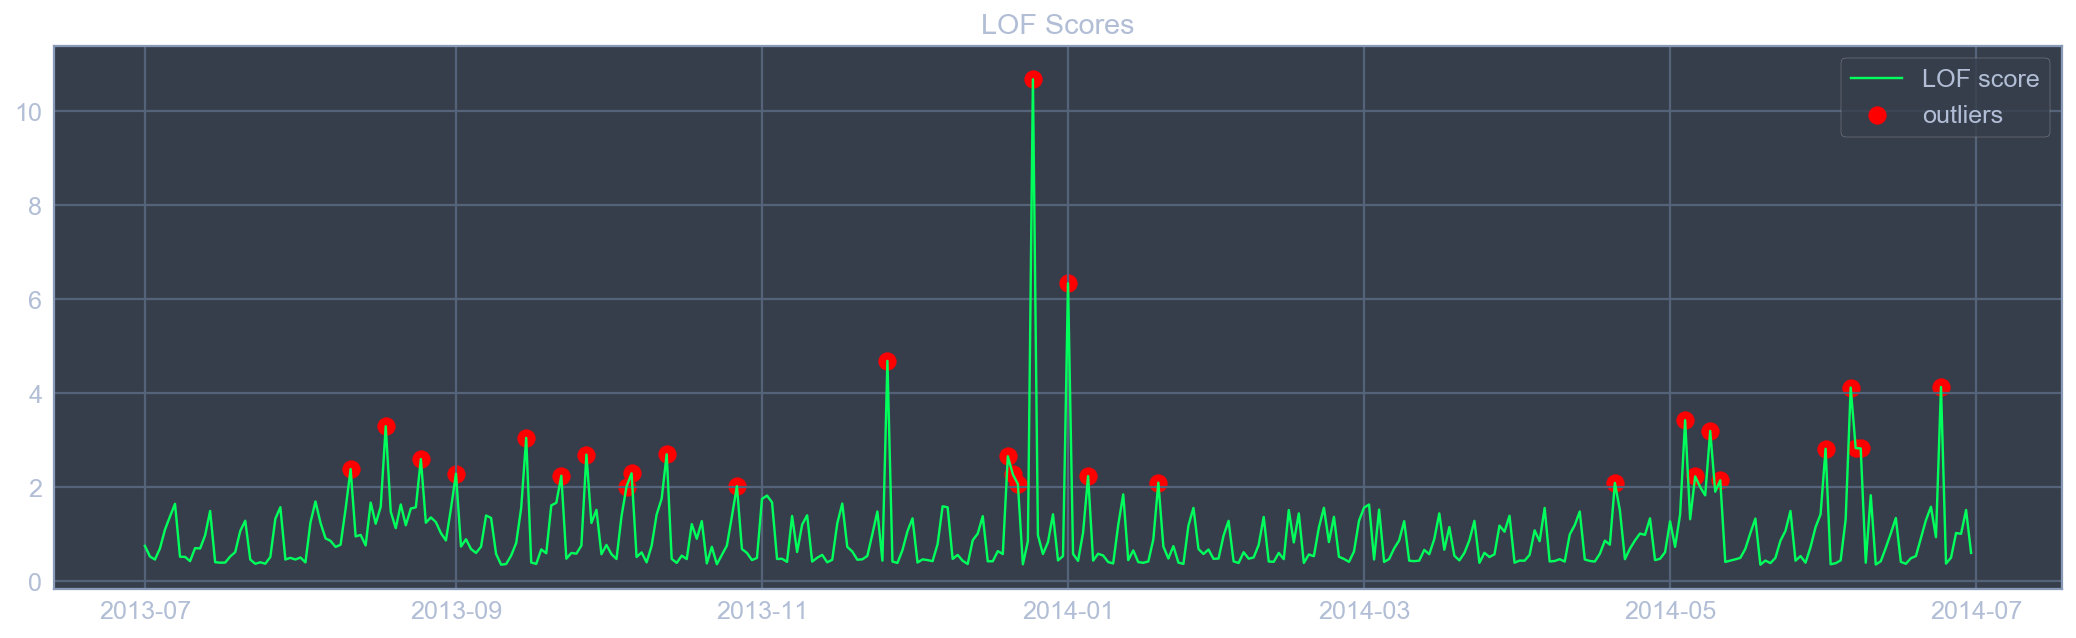

/Users/jeremybensoussan/anaconda3/envs/ITC/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


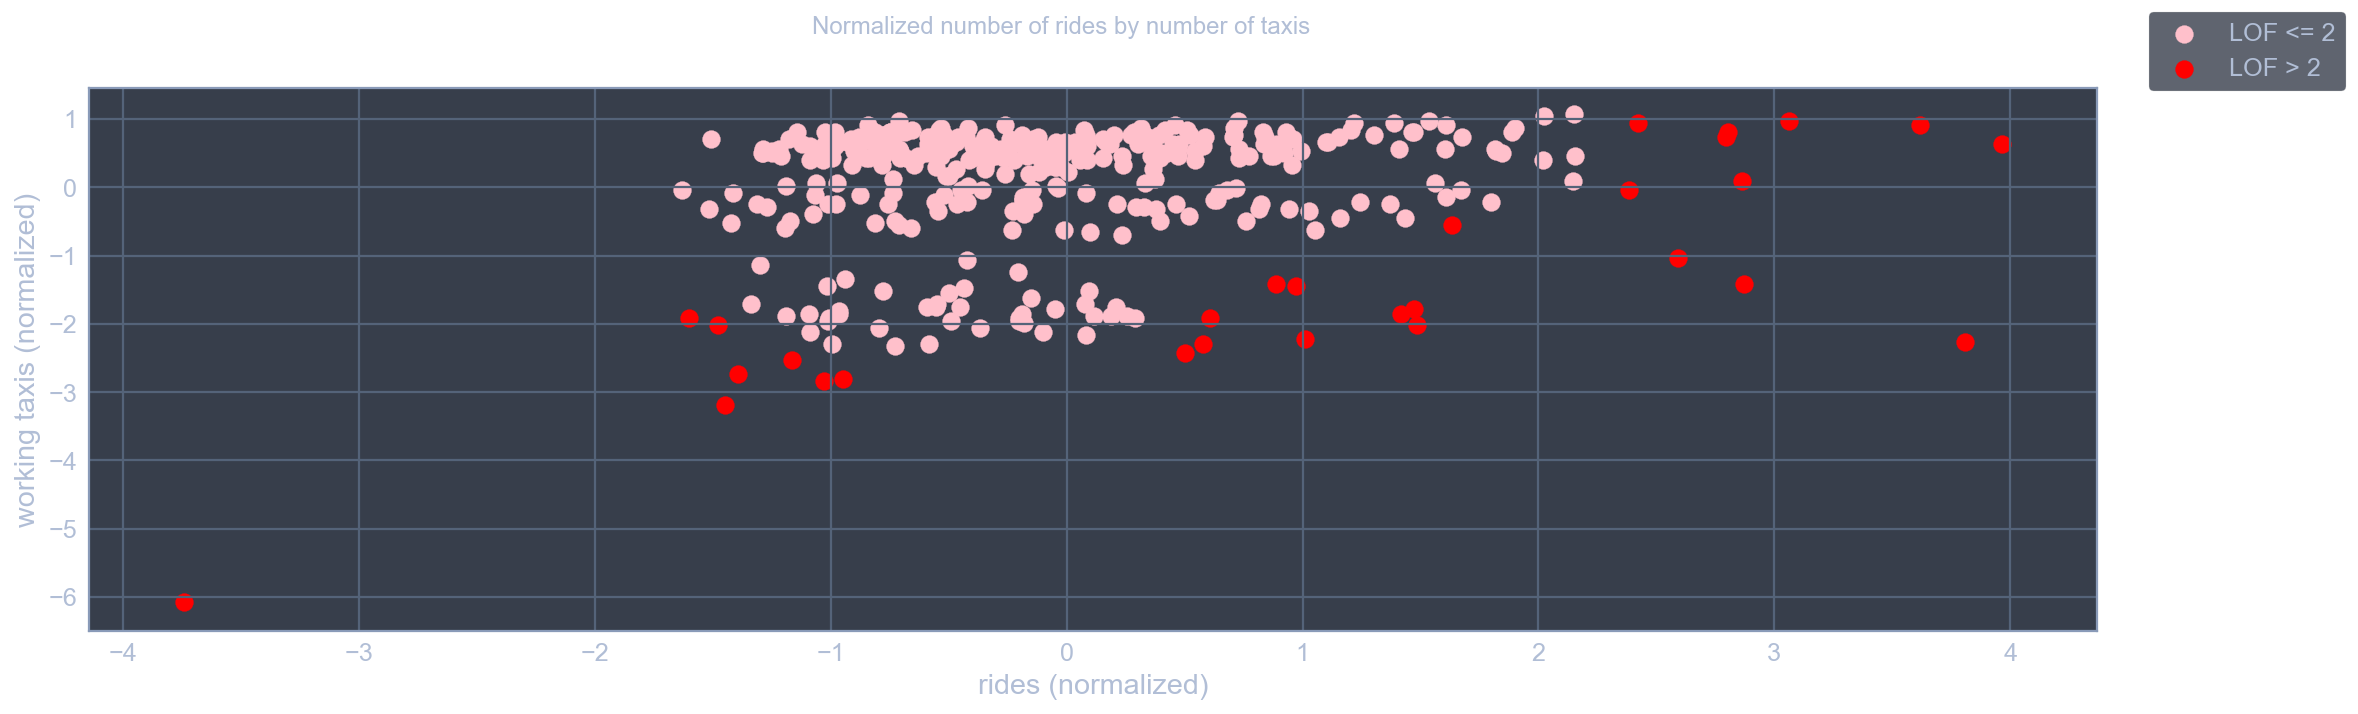

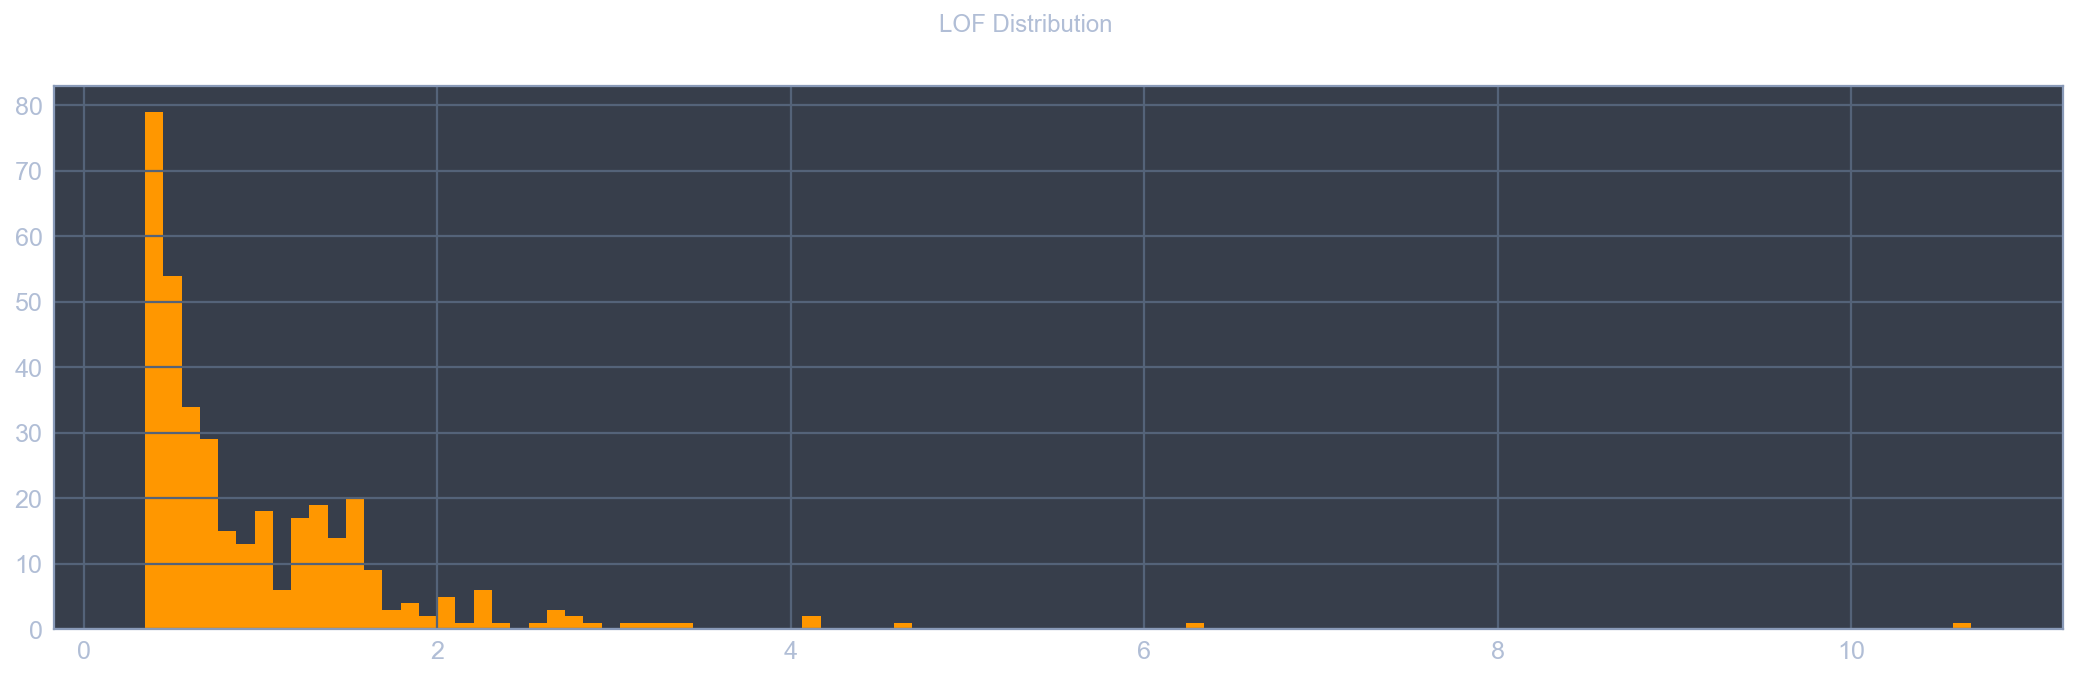

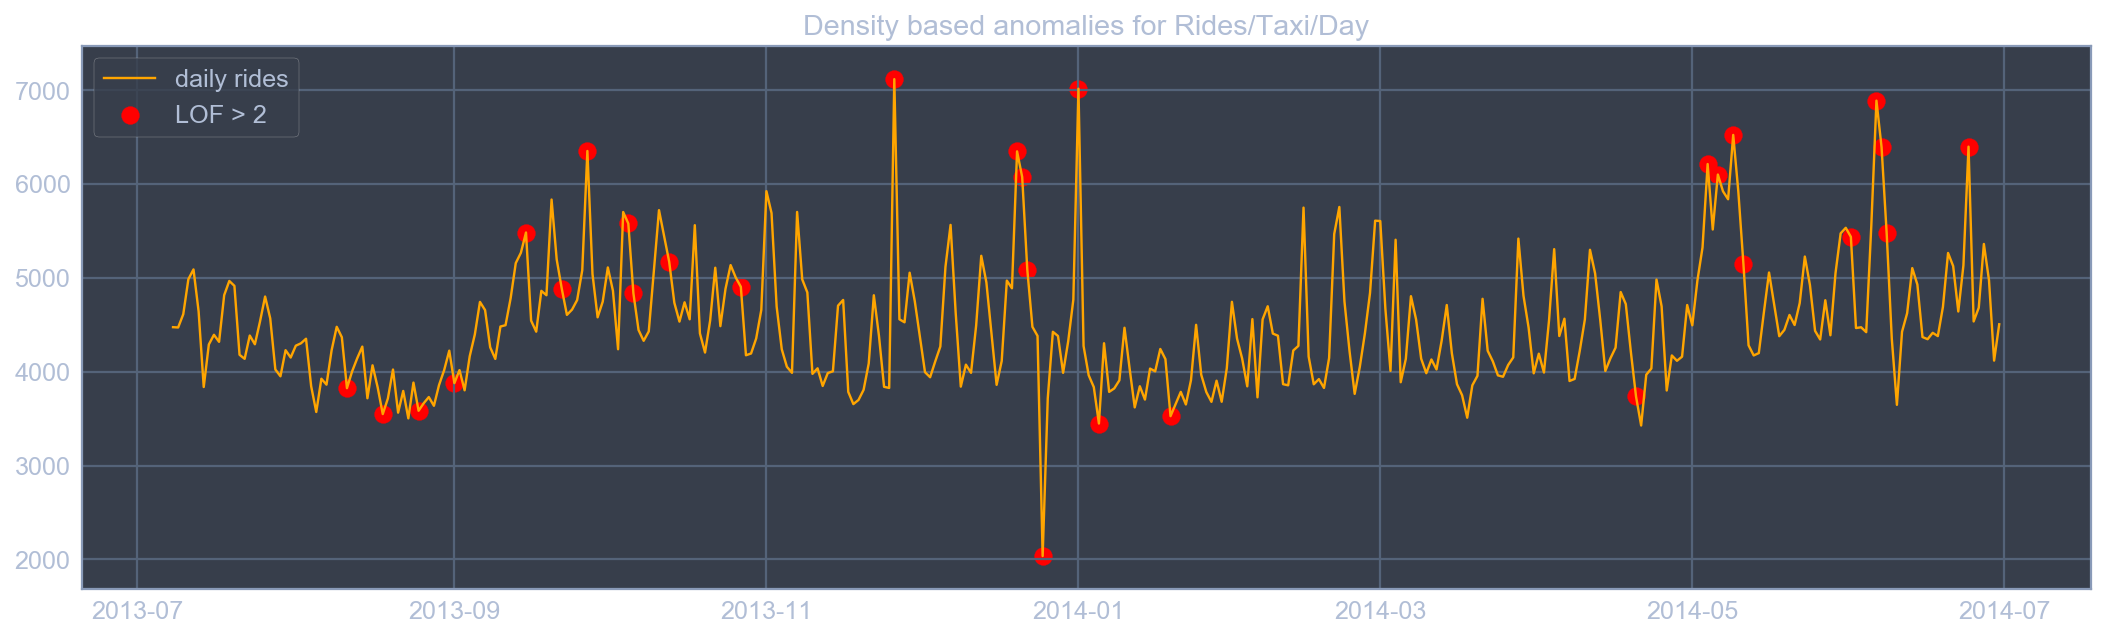

In [55]:
# Plot the series
plt.figure(figsize=(18,5))
plt.title('LOF Scores')
plt.plot(df_norm.index, df_norm['LOF'], c=plt.cm.get_cmap('hsv', 11)(4), label='LOF score')
plt.scatter(df_norm[df_norm['LOF'] > 2].index, df_norm[df_norm['LOF'] > 2].LOF.values, s=80, c='red', label='outliers')
plt.legend()
plt.show()


fig, ax = plt.subplots(figsize=(18,5))
fig.suptitle('Normalized number of rides by number of taxis')
ax.scatter(df_norm[~(df_norm['LOF'] > 2)].n_rides, df_norm[~(df_norm['LOF'] > 2)].n_taxis, s=80, c='pink', label='LOF <= 2')
ax.scatter(df_norm[df_norm['LOF'] > 2].n_rides, df_norm[df_norm['LOF'] > 2].n_taxis, s=80, c='red', label='LOF > 2')
ax.set_xlabel('rides (normalized)')
ax.set_ylabel('working taxis (normalized)')
fig.legend()
fig.show()

# Plot the histogram
fig, ax = plt.subplots(figsize=(18,5))
fig.suptitle('LOF Distribution')
ax.hist(df_norm['LOF'], bins=100,  color=plt.cm.get_cmap('hsv', 11)(np.random.randint(11)))
fig.show()

# Plot the series
plt.figure(figsize=(18,5))
plt.title('Density based anomalies for Rides/Taxi/Day')
plt.plot(X_train.index, X_train['n_rides'], c='orange', label='daily rides')
plt.scatter(X_train[df_norm['LOF'] > 2].index, X_train[df_norm['LOF'] > 2].n_rides.values, s=80, c='red', label='LOF > 2')
plt.legend()
plt.show()

## 3.6 Apply the iterative method to find outliers with LOF
use threshold of 4

Series <LOF>


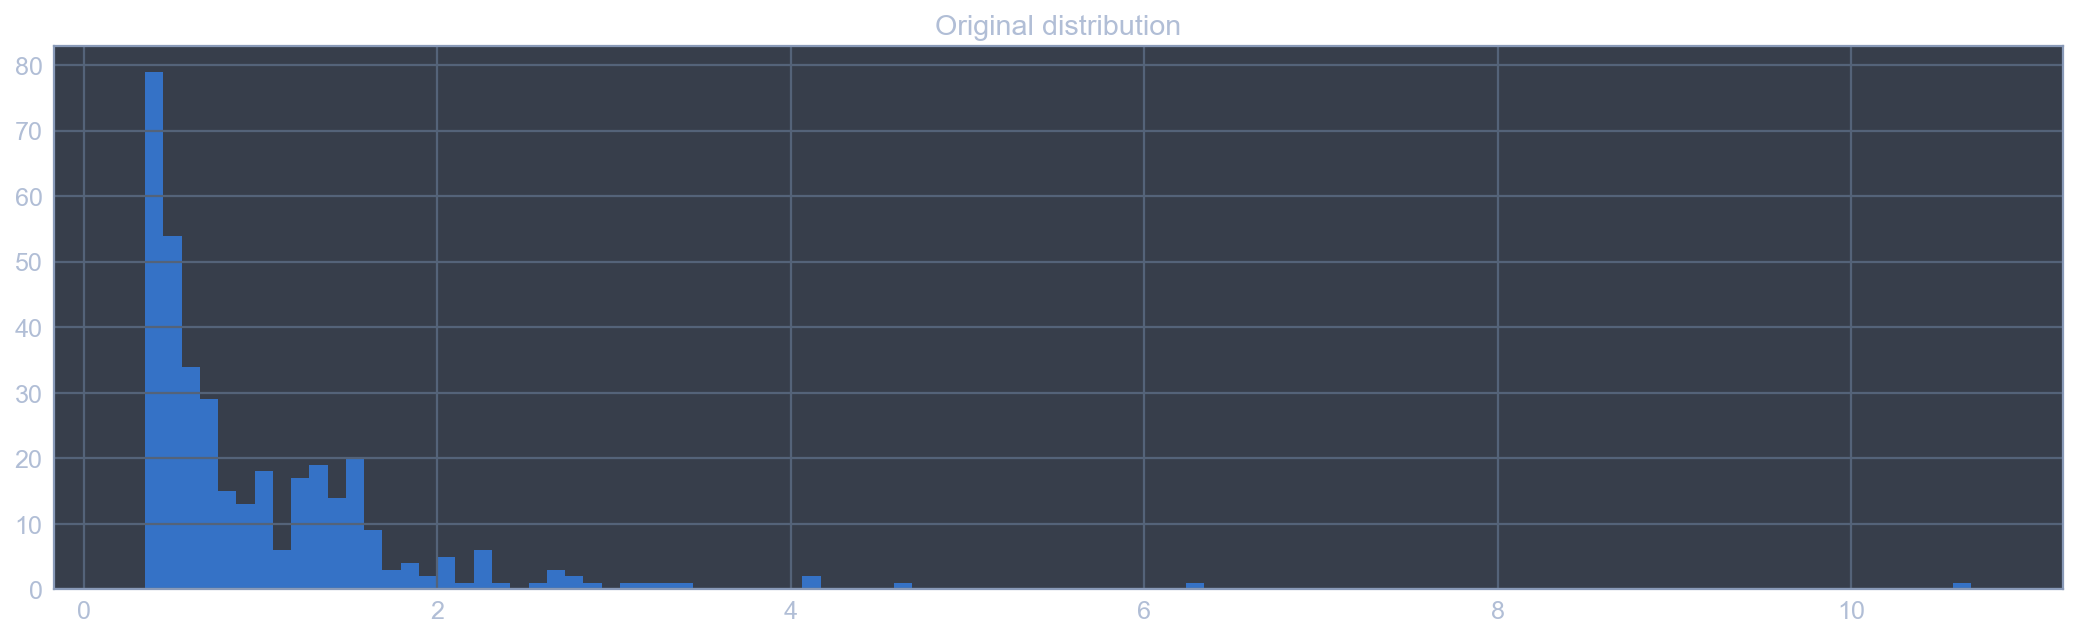

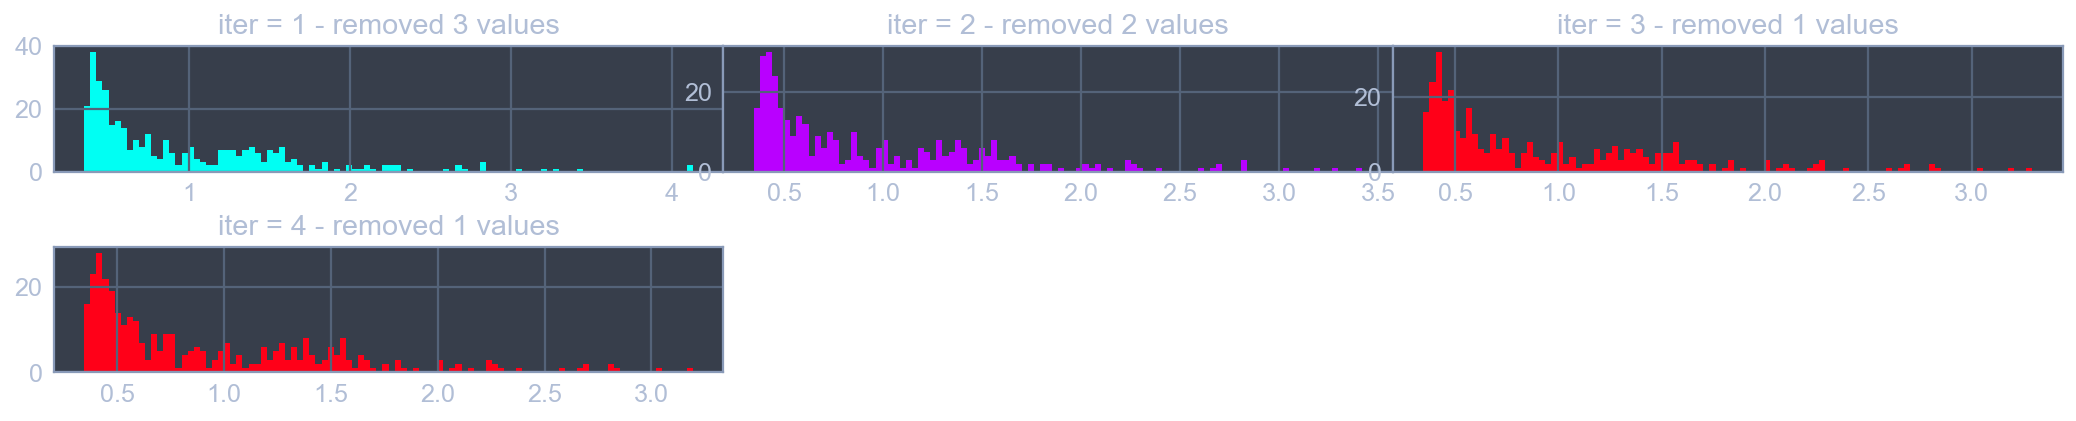

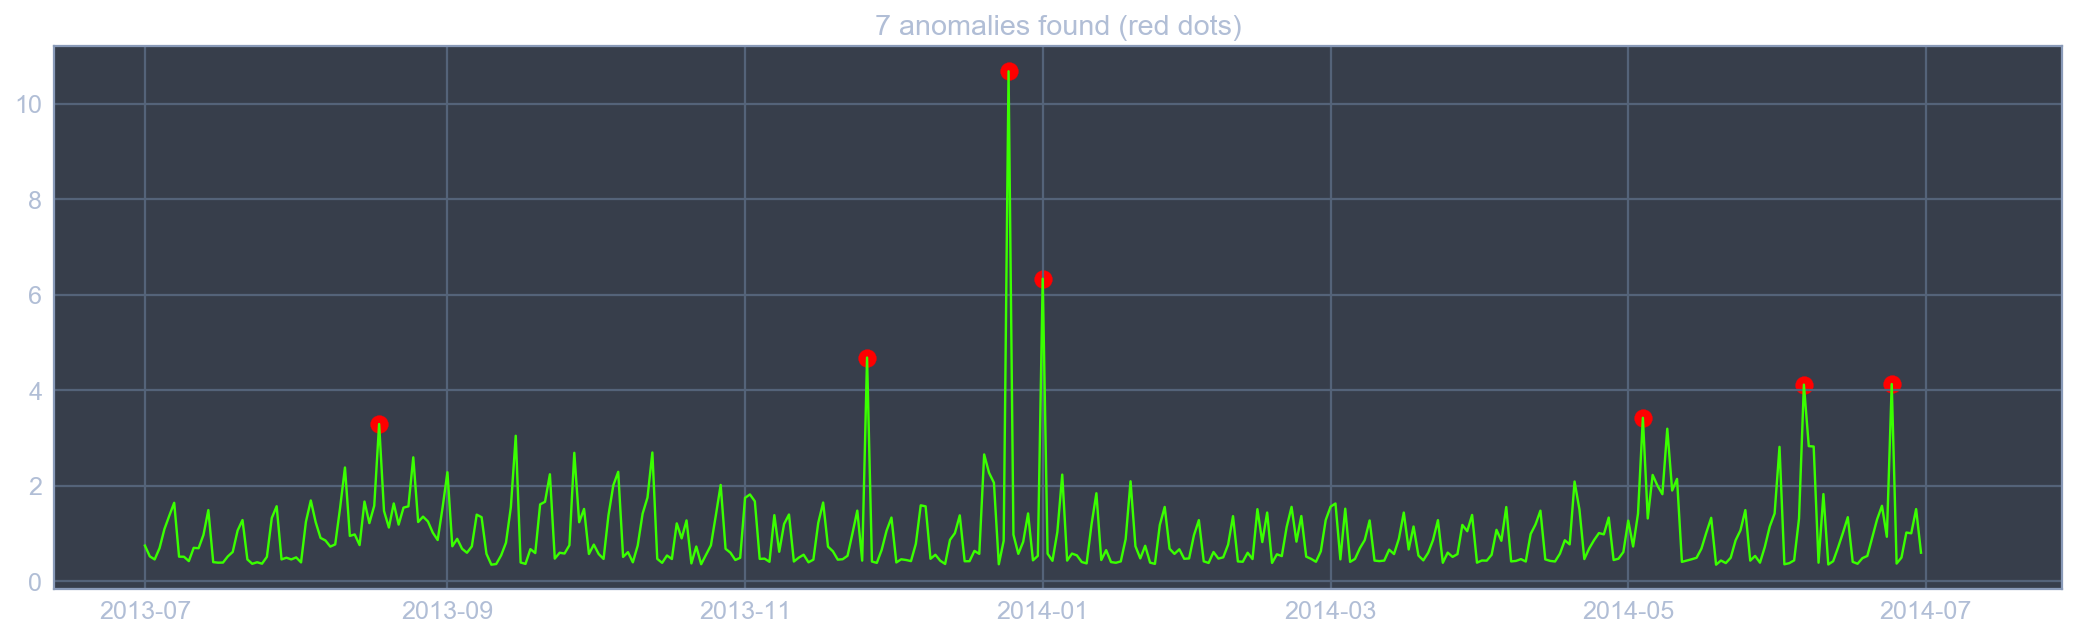

In [56]:
lof_anomalies = gaussian_anomaly_detection(df_norm['LOF'], 4)

## Visualize anomalies in the scatter plot and the time series (on trips and taxis per day)

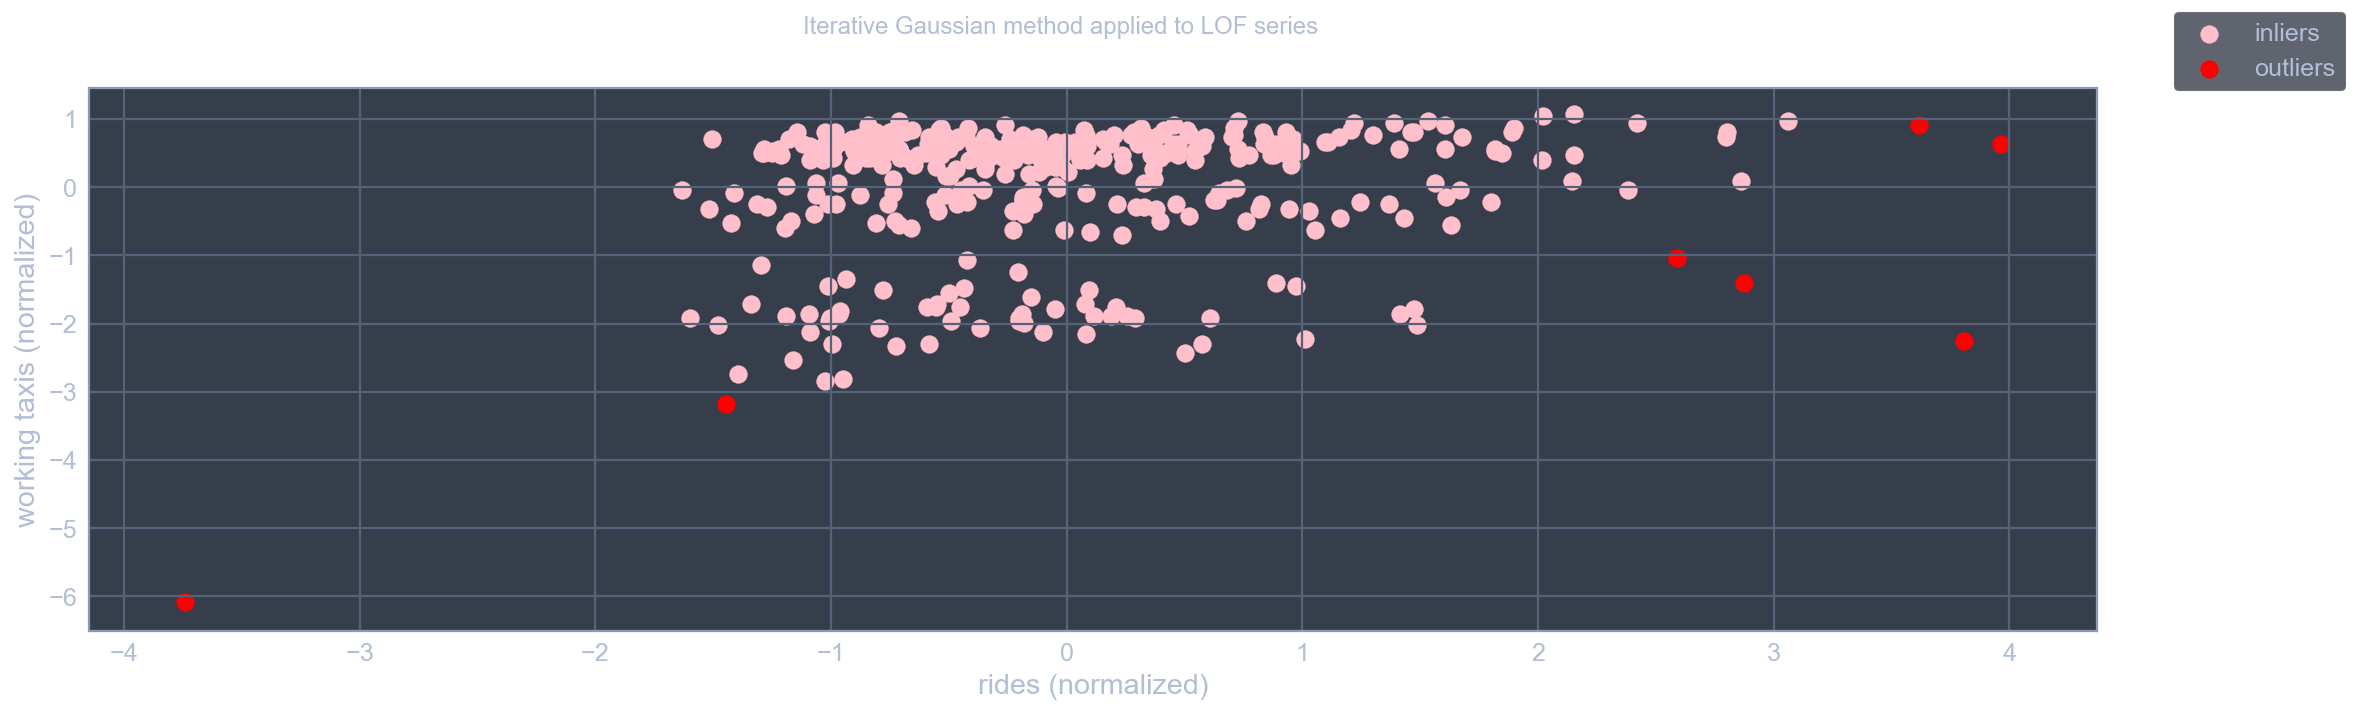

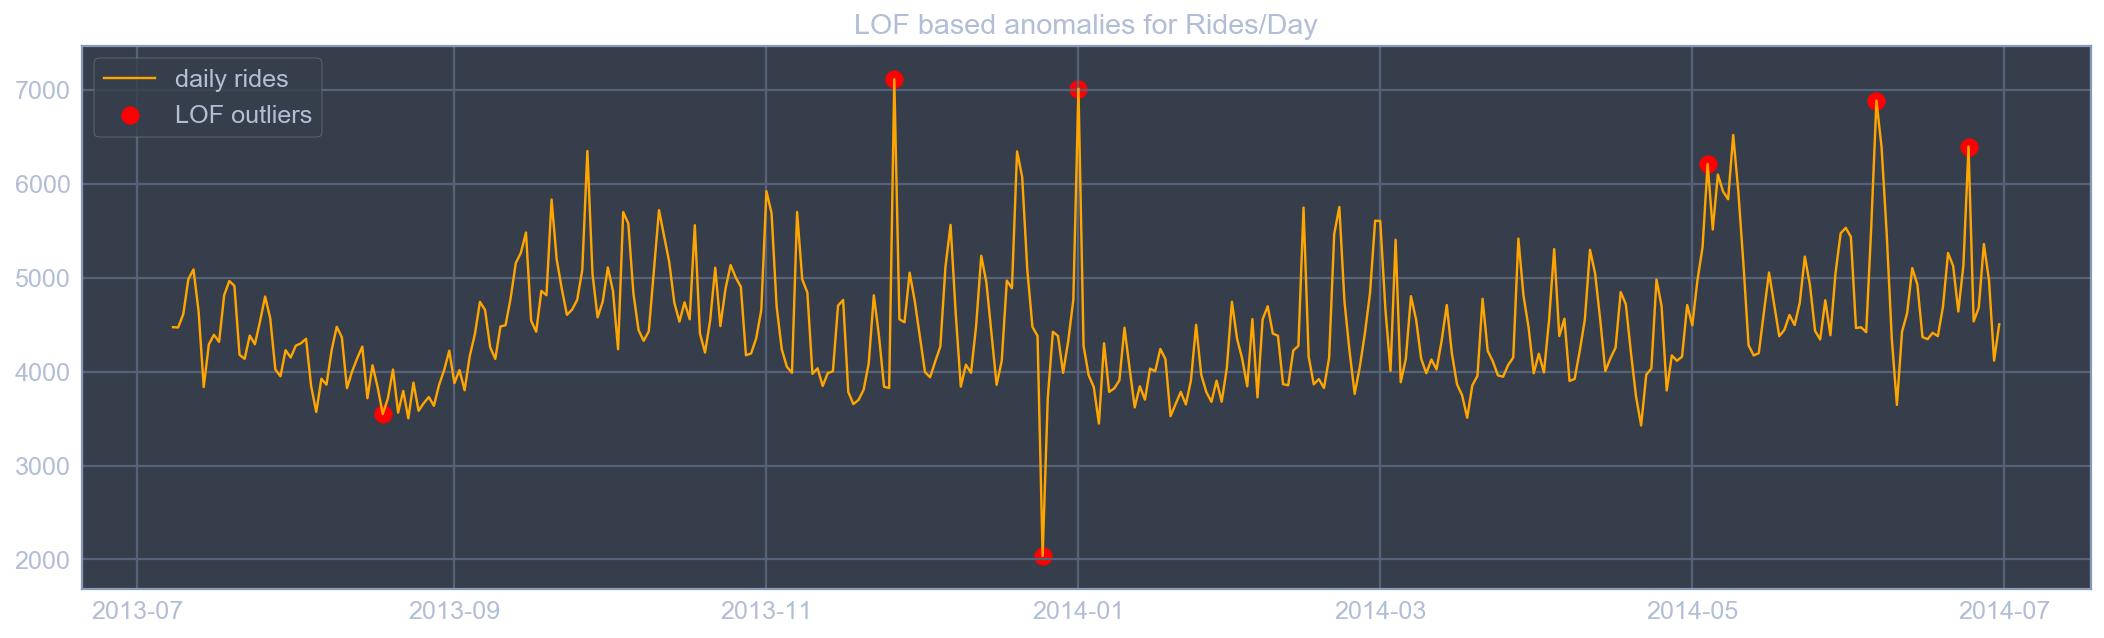

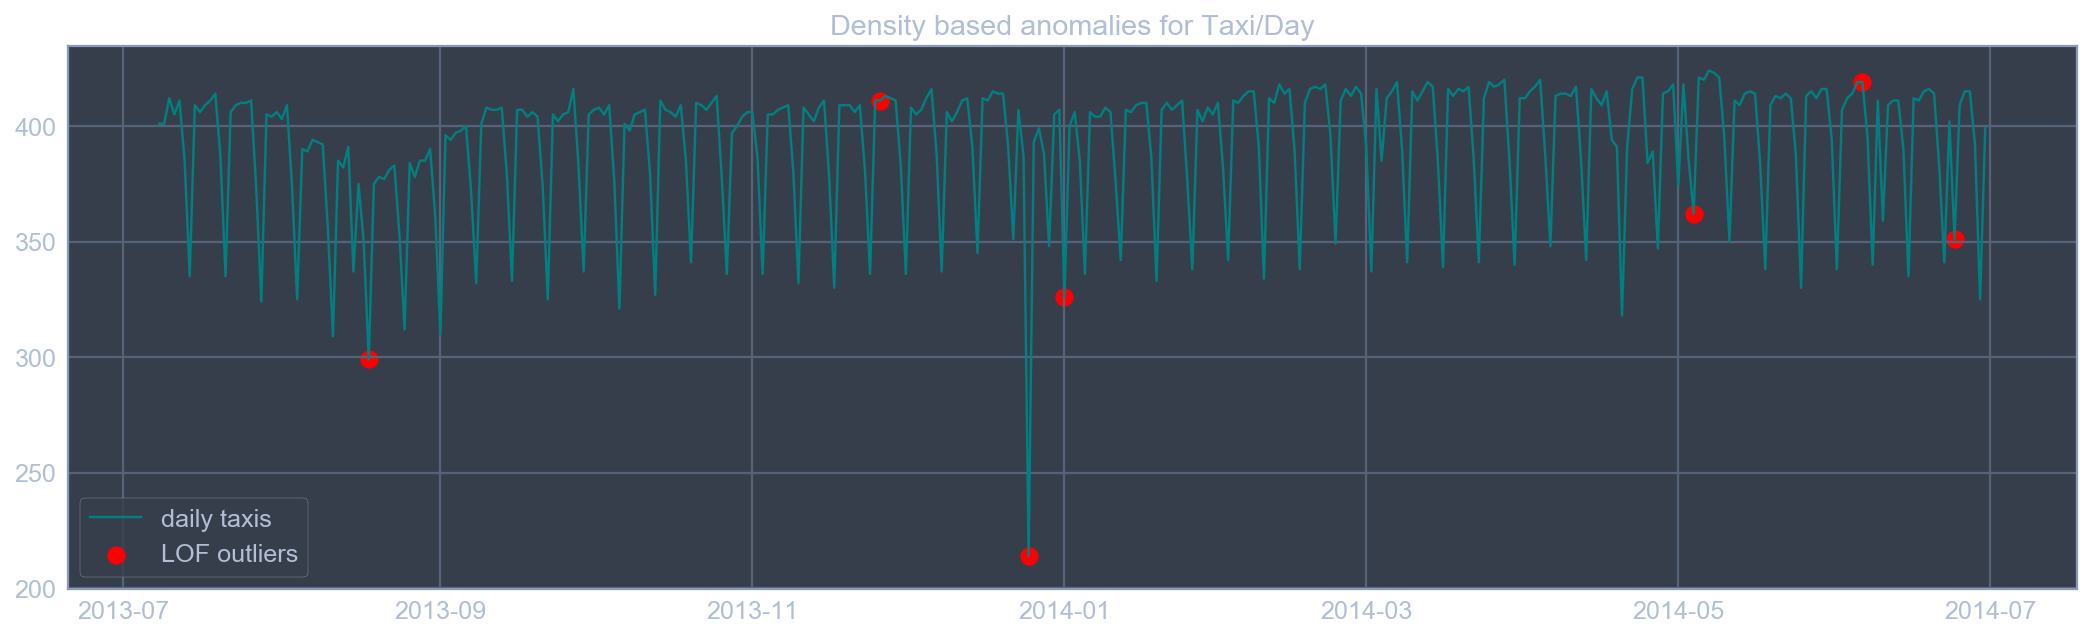

In [57]:
fig, ax = plt.subplots(figsize=(18,5))
fig.suptitle('Iterative Gaussian method applied to LOF series')
ax.scatter(df_norm[~(df_norm.index.isin(lof_anomalies.index))].n_rides, df_norm[~(df_norm.index.isin(lof_anomalies.index))].n_taxis, s=80, c='pink', label='inliers')
ax.scatter(df_norm[(df_norm.index.isin(lof_anomalies.index))].n_rides, df_norm[(df_norm.index.isin(lof_anomalies.index))].n_taxis, s=80, c='red', label='outliers')
ax.set_xlabel('rides (normalized)')
ax.set_ylabel('working taxis (normalized)')
fig.legend()
fig.show()

# Plot the series
plt.figure(figsize=(18,5))
plt.title('LOF based anomalies for Rides/Day')
plt.plot(X_train.index, X_train['n_rides'], c='orange', label='daily rides')
plt.scatter(X_train[(X_train.index.isin(lof_anomalies.index))].index, X_train[(X_train.index.isin(lof_anomalies.index))].n_rides.values, s=80, c='red', label='LOF outliers')
plt.legend()
plt.show()

plt.figure(figsize=(18,5))
plt.title('Density based anomalies for Taxi/Day')
plt.plot(X_train.index, X_train['n_taxis'], c='teal', label='daily taxis')
plt.scatter(X_train[(X_train.index.isin(lof_anomalies.index))].index, X_train[(X_train.index.isin(lof_anomalies.index))].n_taxis.values, s=80, c='red', label='LOF outliers')
plt.legend()
plt.show()

### Conclusion
Interestingly, the LOF methodology applied to the dataset of number of rides per number of taxis per day spotted the same outliers as the initial methodology that consisted in only considering the standard deviation.

While this is true for the main peaks and downpeaks of number of rides, we don't expect this similarity to hold true if we lower the LOF threshold.

As a final note, all the methods tried in this exercise successfully flagged the extreme peaks of usage, but then differed when lowering the thresholds and flagging more values as outliers. Depending on the problem at hand, and what kind of outliers we would like to identify we may decide to use one method over the other.